In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import os
import random
import gc  # Import garbage collection

# -------------------------
# Residual Dense Block (RDB)
# -------------------------
class ResidualDenseBlock(nn.Module):
    def __init__(self, channels=64, growth_channels=32):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, growth_channels, 3, 1, 1)
        self.conv2 = nn.Conv2d(channels + growth_channels, growth_channels, 3, 1, 1)
        self.conv3 = nn.Conv2d(channels + 2 * growth_channels, growth_channels, 3, 1, 1)
        self.conv4 = nn.Conv2d(channels + 3 * growth_channels, growth_channels, 3, 1, 1)
        self.conv5 = nn.Conv2d(channels + 4 * growth_channels, channels, 3, 1, 1)
        self.lrelu = nn.LeakyReLU(0.2, inplace=True)
        self.res_scale = 0.2

    def forward(self, x):
        x1 = self.lrelu(self.conv1(x))
        x2 = self.lrelu(self.conv2(torch.cat([x, x1], 1)))
        x3 = self.lrelu(self.conv3(torch.cat([x, x1, x2], 1)))
        x4 = self.lrelu(self.conv4(torch.cat([x, x1, x2, x3], 1)))
        x5 = self.conv5(torch.cat([x, x1, x2, x3, x4], 1))
        return x + x5 * self.res_scale

# -------------------------
# Residual in Residual Dense Block (RRDB)
# -------------------------
class RRDB(nn.Module):
    def __init__(self, channels, growth_channels=32):
        super().__init__()
        self.rdb1 = ResidualDenseBlock(channels, growth_channels)
        self.rdb2 = ResidualDenseBlock(channels, growth_channels)
        self.rdb3 = ResidualDenseBlock(channels, growth_channels)
        self.res_scale = 0.2

    def forward(self, x):
        out = self.rdb1(x)
        out = self.rdb2(out)
        out = self.rdb3(out)
        return x + out * self.res_scale

# -------------------------
# ESRGAN Generator
# -------------------------
class Generator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, channels=64, num_blocks=23, growth_channels=32, scale_factor=4):
        super().__init__()
        self.conv_first = nn.Conv2d(in_channels, channels, 3, 1, 1)
        self.RRDB_trunk = nn.Sequential(*[RRDB(channels, growth_channels) for _ in range(num_blocks)])
        self.trunk_conv = nn.Conv2d(channels, channels, 3, 1, 1)

        # Upsampling layers (x4)
        upsample_layers = []
        for _ in range(int(scale_factor // 2)):
            upsample_layers += [
                nn.Conv2d(channels, channels * 4, 3, 1, 1),
                nn.PixelShuffle(2),
                nn.LeakyReLU(0.2, inplace=True)
            ]
        self.upsampling = nn.Sequential(*upsample_layers)

        self.conv_last = nn.Conv2d(channels, out_channels, 3, 1, 1)

    def forward(self, x):
        fea = self.conv_first(x)
        trunk = self.trunk_conv(self.RRDB_trunk(fea))
        fea = fea + trunk
        out = self.upsampling(fea)
        out = self.conv_last(out)
        return out

# -------------------------
# ESRGAN Discriminator (no batch norm)
# -------------------------
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, base_channels=64):
        super().__init__()
        def conv_block(in_c, out_c, stride):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, stride, 1),
                nn.LeakyReLU(0.2, inplace=True)
            )
        self.net = nn.Sequential(
            conv_block(in_channels, base_channels, 1),
            conv_block(base_channels, base_channels, 2),
            conv_block(base_channels, base_channels * 2, 1),
            conv_block(base_channels * 2, base_channels * 2, 2),
            conv_block(base_channels * 2, base_channels * 4, 1),
            conv_block(base_channels * 4, base_channels * 4, 2),
            conv_block(base_channels * 4, base_channels * 8, 1),
            conv_block(base_channels * 8, base_channels * 8, 2),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(base_channels * 8, 100),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(100, 1)
        )

    def forward(self, x):
        return self.net(x)

# -------------------------
# VGG19 Feature Extractor for Perceptual Loss
# -------------------------
class VGGFeatureExtractor(nn.Module):
    def __init__(self, feature_layer=35, use_cuda=True):
        super().__init__()
        vgg19 = models.vgg19(pretrained=True).features
        self.features = nn.Sequential(*list(vgg19.children())[:feature_layer]).eval()
        for param in self.features.parameters():
            param.requires_grad = False
        if use_cuda:
            self.features = self.features.cuda()

    def forward(self, x):
        return self.features(x)

# -------------------------
# Relativistic Average GAN Loss
# -------------------------
def relativistic_loss_D(real_pred, fake_pred):
    real_loss = torch.mean((real_pred - torch.mean(fake_pred) - 1) ** 2)
    fake_loss = torch.mean((fake_pred - torch.mean(real_pred) + 1) ** 2)
    return (real_loss + fake_loss) / 2

def relativistic_loss_G(real_pred, fake_pred):
    return torch.mean((real_pred - torch.mean(fake_pred) + 1) ** 2) + torch.mean((fake_pred - torch.mean(real_pred) - 1) ** 2)

# -------------------------
# Dataset (example DIV2K-like)
# -------------------------
class DIV2KDataset(Dataset):
    def __init__(self, hr_dir, scale=4, patch_size=96, transform=None): # Added patch_size
        super().__init__()
        self.hr_images = [os.path.join(hr_dir, f) for f in os.listdir(hr_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
        self.scale = scale
        self.patch_size = patch_size  # Store patch size
        self.transform = transform or transforms.ToTensor()

    def __len__(self):
        return len(self.hr_images)

    def __getitem__(self, idx):
        hr = Image.open(self.hr_images[idx]).convert('RGB')
        w, h = hr.size

        # Random Crop
        hr_width, hr_height = hr.size
        lr_width = hr_width // self.scale
        lr_height = hr_height // self.scale

        if hr_width < self.patch_size or hr_height < self.patch_size:
            hr = hr.resize((self.patch_size, self.patch_size), Image.BICUBIC)

        # Ensure the patch size is smaller than the image dimensions
        if hr_width > self.patch_size and hr_height > self.patch_size:
            i = random.randint(0, hr_height - self.patch_size)
            j = random.randint(0, hr_width - self.patch_size)
        else:
            i = 0
            j = 0
            self.patch_size = min(hr_width, hr_height) # Adapt patch size

        hr_crop = hr.crop((j, i, j+self.patch_size, i+self.patch_size)) # HR Crop
        lr_img = hr_crop.resize((self.patch_size // self.scale, self.patch_size // self.scale), Image.BICUBIC) # Create LR from HR

        if self.transform:
            lr_img = self.transform(lr_img)
            hr_crop = self.transform(hr_crop)
        return lr_img, hr_crop

# -------------------------
# Training Loop
# -------------------------
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchmetrics.image.psnr import PeakSignalNoiseRatio
from torchmetrics.image.ssim import StructuralSimilarityIndexMeasure
from torch.cuda.amp import autocast, GradScaler  # Import for mixed precision

# def train_srgan_with_plots(generator, discriminator, train_loader, val_loader, epochs, device, lr=1e-4, lambda_perceptual=0.006, lambda_adv=0.005):
#     g = generator.to(device)
#     d = discriminator.to(device)
#     vgg = VGGFeatureExtractor(use_cuda=device.type == 'cuda').to(device)
#     vgg.eval()

#     opt_g = torch.optim.Adam(g.parameters(), lr=lr)
#     opt_d = torch.optim.Adam(d.parameters(), lr=lr)

#     criterion_rec = nn.L1Loss()

#     psnr_metric = PeakSignalNoiseRatio().to(device)
#     ssim_metric = StructuralSimilarityIndexMeasure().to(device)

#     g_losses = []
#     d_losses = []
#     psnrs = []
#     ssims = []

#     scaler_g = GradScaler()  # Define GradScaler for generator
#     scaler_d = GradScaler()  # Define GradScaler for discriminator

#     for epoch in range(epochs):
#         g.train()
#         d.train()
#         g_loss_epoch, d_loss_epoch = 0, 0

#         pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]")
#         for lr_img, hr_crop in pbar:  # Use hr_crop
#             lr_img, hr_crop = lr_img.to(device), hr_crop.to(device)  # Use hr_crop

#             # Train Discriminator
#             opt_d.zero_grad()
#             with autocast():  # Use autocast
#                 real_pred = d(hr_crop)  # Use hr_crop
#                 fake_pred = d(g(lr_img).detach())
#                 loss_d = relativistic_loss_D(real_pred, fake_pred)
#             scaler_d.scale(loss_d).backward()  # Scale loss
#             scaler_d.step(opt_d)  # Step optimizer
#             scaler_d.update()  # Update scaler

#             # Train Generator
#             opt_g.zero_grad()
#             with autocast():  # Use autocast
#                 gen_hr = g(lr_img)
#                 real_pred = d(hr_crop).detach()
#                 fake_pred = d(gen_hr)
#                 loss_g_adv = relativistic_loss_G(real_pred, fake_pred)
#                 loss_g_rec = criterion_rec(gen_hr, hr_crop) # Use hr_crop
#                 vgg_loss = 0.006 * nn.L1Loss()(vgg(gen_hr), vgg(hr_crop))  # Perceptual loss # Use hr_crop
#                 loss_g = loss_g_rec + lambda_adv * loss_g_adv + vgg_loss
#             scaler_g.scale(loss_g).backward()  # Scale loss
#             scaler_g.step(opt_g)  # Step optimizer
#             scaler_g.update()  # Update scaler

#             g_loss_epoch += loss_g.item()
#             d_loss_epoch += loss_d.item()

#             pbar.set_postfix({"G Loss": loss_g.item(), "D Loss": loss_d.item()})

#             del lr_img, hr_crop, gen_hr, loss_g, loss_d, real_pred, fake_pred # Delete
#             torch.cuda.empty_cache()
#             gc.collect()

#         g_losses.append(g_loss_epoch / len(train_loader))
#         d_losses.append(d_loss_epoch / len(train_loader))


#         # Validation
#         g.eval()
#         val_psnr, val_ssim = 0, 0
#         val_batches = 0
#         val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]")
#         with torch.no_grad():
#             for lr_img, hr_crop in val_pbar:
#                 lr_img, hr_crop = lr_img.to(device), hr_crop.to(device)
#                 with autocast():
#                     sr_img = g(lr_img)
#                 # Clamp outputs to [0,1]
#                 # sr_img = torch.clamp(sr_img, 0.0, 1.0)
#                 # hr_img = torch.clamp(hr_img, 0.0, 1.0)
#                 psnr = psnr_metric(sr_img, hr_crop).item()
#                 sr_img = torch.clamp(sr_img, 0, 1)
#                 hr_crop = torch.clamp(hr_crop, 0, 1)
#                 ssim = ssim_metric(sr_img, hr_crop).item()
#                 val_psnr += psnr
#                 val_ssim += ssim
#                 val_batches += 1
#                 val_pbar.set_postfix({"PSNR": psnr, "SSIM": ssim})
#                 del lr_img, hr_crop, sr_img # Delete

                

#         val_psnr /= val_batches
#         val_ssim /= val_batches
#         psnrs.append(val_psnr)
#         ssims.append(val_ssim)

#         print(f"\nEpoch {epoch+1}/{epochs} Summary -- G Loss: {g_losses[-1]:.4f}, D Loss: {d_losses[-1]:.4f}, PSNR: {val_psnr:.2f}, SSIM: {val_ssim:.3f}")
#         torch.cuda.empty_cache()
#         gc.collect()
#         # Plot results after each epoch
#         plt.figure(figsize=(15, 4))

#         plt.subplot(1, 3, 1)
#         plt.plot(g_losses, label="Generator Loss")
#         plt.plot(d_losses, label="Discriminator Loss")
#         plt.title("Loss per Epoch")
#         plt.xlabel("Epoch")
#         plt.ylabel("Loss")
#         plt.legend()

#         plt.subplot(1, 3, 2)
#         plt.plot(psnrs, label="PSNR", color="green")
#         plt.title("Validation PSNR")
#         plt.xlabel("Epoch")
#         plt.ylabel("PSNR (dB)")
#         plt.legend()

#         plt.subplot(1, 3, 3)
#         plt.plot(ssims, label="SSIM", color="orange")
#         plt.title("Validation SSIM")
#         plt.xlabel("Epoch")
#         plt.ylabel("SSIM")
#         plt.legend()

#         plt.tight_layout()
#         plt.savefig("training_metrics.png")
#         plt.show()

#     return g, d

def train_srgan_with_plots(generator, discriminator, train_loader, val_loader, epochs, device, lr=1e-4, lambda_perceptual=0.006, lambda_adv=0.005):
    import matplotlib.pyplot as plt
    from tqdm import tqdm
    from torchmetrics.image.psnr import PeakSignalNoiseRatio
    from torchmetrics.image.ssim import StructuralSimilarityIndexMeasure
    from torch.cuda.amp import autocast, GradScaler
    import gc

    g = generator.to(device)
    d = discriminator.to(device)
    vgg = VGGFeatureExtractor(use_cuda=device.type == 'cuda').to(device)
    vgg.eval()

    opt_g = torch.optim.Adam(g.parameters(), lr=lr)
    opt_d = torch.optim.Adam(d.parameters(), lr=lr)

    criterion_rec = nn.L1Loss()

    psnr_metric = PeakSignalNoiseRatio().to(device)
    ssim_metric = StructuralSimilarityIndexMeasure().to(device)

    g_losses = []
    d_losses = []
    psnrs = []
    ssims = []

    scaler_g = GradScaler()
    scaler_d = GradScaler()

    for epoch in range(epochs):
        g.train()
        d.train()
        g_loss_epoch, d_loss_epoch = 0, 0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]")
        for lr_img, hr_crop in pbar:
            lr_img, hr_crop = lr_img.to(device), hr_crop.to(device)

            # Train Discriminator
            opt_d.zero_grad()
            with autocast():
                real_pred = d(hr_crop)
                fake_pred = d(g(lr_img).detach())
                loss_d = relativistic_loss_D(real_pred, fake_pred)
            scaler_d.scale(loss_d).backward()
            scaler_d.step(opt_d)
            scaler_d.update()

            # Train Generator
            opt_g.zero_grad()
            with autocast():
                gen_hr = g(lr_img)
                real_pred = d(hr_crop).detach()
                fake_pred = d(gen_hr)
                loss_g_adv = relativistic_loss_G(real_pred, fake_pred)
                loss_g_rec = criterion_rec(gen_hr, hr_crop)
                vgg_loss = lambda_perceptual * nn.L1Loss()(vgg(gen_hr), vgg(hr_crop))
                loss_g = loss_g_rec + lambda_adv * loss_g_adv + vgg_loss
            scaler_g.scale(loss_g).backward()
            scaler_g.step(opt_g)
            scaler_g.update()

            g_loss_epoch += loss_g.item()
            d_loss_epoch += loss_d.item()

            pbar.set_postfix({"G Loss": loss_g.item(), "D Loss": loss_d.item()})

            del lr_img, hr_crop, gen_hr, loss_g, loss_d, real_pred, fake_pred
            torch.cuda.empty_cache()
            gc.collect()

        g_losses.append(g_loss_epoch / len(train_loader))
        d_losses.append(d_loss_epoch / len(train_loader))

        # Validation
        g.eval()
        val_psnr, val_ssim = 0, 0
        val_batches = 0
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]")
        with torch.no_grad():
            for lr_img, hr_crop in val_pbar:
                lr_img, hr_crop = lr_img.to(device), hr_crop.to(device)
                with autocast():
                    sr_img = g(lr_img)
                # Clamp outputs to [0,1]
                sr_img = torch.clamp(sr_img, 0.0, 1.0)
                hr_crop = torch.clamp(hr_crop, 0.0, 1.0)

                # Check for NaNs
                if torch.isnan(sr_img).any() or torch.isnan(hr_crop).any():
                    print("NaN detected in images. Skipping this batch.")
                    print("SR min/max:", sr_img.min().item(), sr_img.max().item())
                    print("HR min/max:", hr_crop.min().item(), hr_crop.max().item())
                    continue

                psnr = psnr_metric(sr_img, hr_crop).item()
                ssim = ssim_metric(sr_img, hr_crop).item()
                if not (torch.isnan(torch.tensor(ssim)) or torch.isnan(torch.tensor(psnr))):
                    val_psnr += psnr
                    val_ssim += ssim
                    val_batches += 1
                val_pbar.set_postfix({"PSNR": psnr, "SSIM": ssim})
                del lr_img, hr_crop, sr_img
                torch.cuda.empty_cache()
                gc.collect()

        if val_batches > 0:
            val_psnr /= val_batches
            val_ssim /= val_batches
        else:
            val_psnr, val_ssim = float('nan'), float('nan')
        psnrs.append(val_psnr)
        ssims.append(val_ssim)

        print(f"\nEpoch {epoch+1}/{epochs} Summary -- G Loss: {g_losses[-1]:.4f}, D Loss: {d_losses[-1]:.4f}, PSNR: {val_psnr:.2f}, SSIM: {val_ssim:.3f}")
        torch.cuda.empty_cache()
        gc.collect()

        # Plot results after each epoch
        plt.figure(figsize=(15, 4))

        plt.subplot(1, 3, 1)
        plt.plot(g_losses, label="Generator Loss")
        plt.plot(d_losses, label="Discriminator Loss")
        plt.title("Loss per Epoch")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()

        plt.subplot(1, 3, 2)
        plt.plot(psnrs, label="PSNR", color="green")
        plt.title("Validation PSNR")
        plt.xlabel("Epoch")
        plt.ylabel("PSNR (dB)")
        plt.legend()

        plt.subplot(1, 3, 3)
        plt.plot(ssims, label="SSIM", color="orange")
        plt.title("Validation SSIM")
        plt.xlabel("Epoch")
        plt.ylabel("SSIM")
        plt.legend()

        plt.tight_layout()
        plt.savefig("training_metrics.png")
        plt.show()

    return g, d


In [12]:
    # Paths to your high-res images folder (DIV2K or similar)
hr_train_dir = "./DIV2K_train_HR_Cropped"
hr_val_dir = "./DIV2K_valid_HR_Cropped"

transform = transforms.Compose([
   transforms.ToTensor()
])

# Create datasets with smaller patch_size and batch_size
train_dataset = DIV2KDataset(hr_train_dir, scale=4, patch_size=96, transform=transform)
val_dataset = DIV2KDataset(hr_val_dir, scale=4, patch_size=96, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator(num_blocks=23, scale_factor=4)
discriminator = Discriminator()

epochs = 100 # Set as needed

In [22]:
def check_memory_usage():
    import torch
    print(f"Allocated VRAM: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
    print(f"Reserved VRAM:  {torch.cuda.memory_reserved() / 1e9:.2f} GB")
def clear_cpu_cache():
    import torch
    import gc
# Delete all PyTorch objects
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

def clear_gpu_cache():
    import torch
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()


In [23]:
check_memory_usage()
clear_cpu_cache()
clear_gpu_cache()
check_memory_usage()

Allocated VRAM: 0.19 GB
Reserved VRAM:  0.56 GB
Allocated VRAM: 0.19 GB
Reserved VRAM:  0.31 GB


c:\Users\zeina\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\zeina\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\zeina\AppData\Local\Temp\ipykernel_22212\200772710.py:348: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_g = GradScaler()
C:\Users\zeina\AppData\Local\Temp\ipykernel_22212\200772710.py:349: FutureWarning: `torch.cuda.a


Epoch 1/100 Summary -- G Loss: 0.1108, D Loss: 0.9965, PSNR: 20.70, SSIM: 0.483


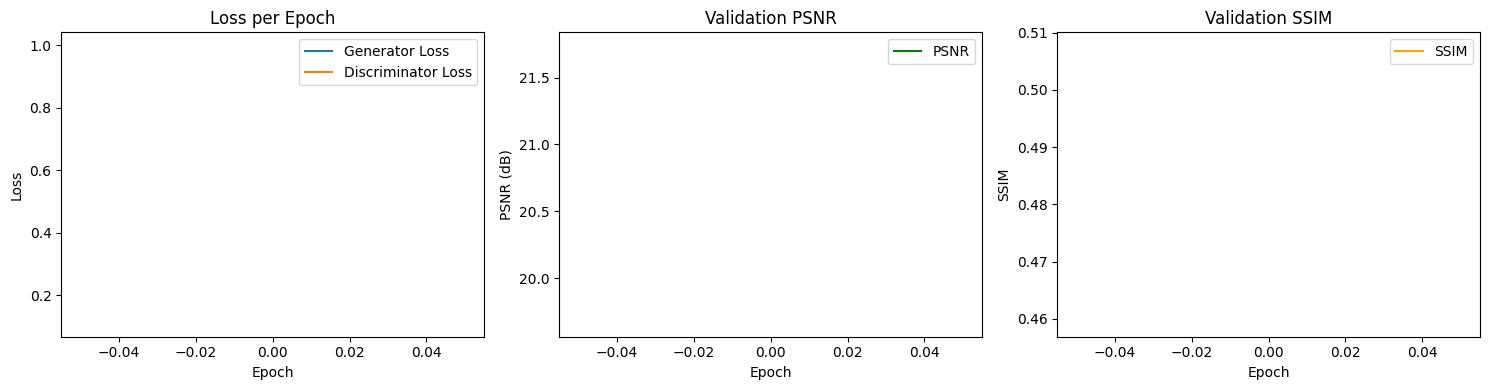

Epoch 2/100 [Validation]: 100%|██████████| 100/100 [00:18<00:00,  5.31it/s, PSNR=24.1, SSIM=0.69]



Epoch 2/100 Summary -- G Loss: 0.0721, D Loss: 1.0031, PSNR: 23.23, SSIM: 0.531


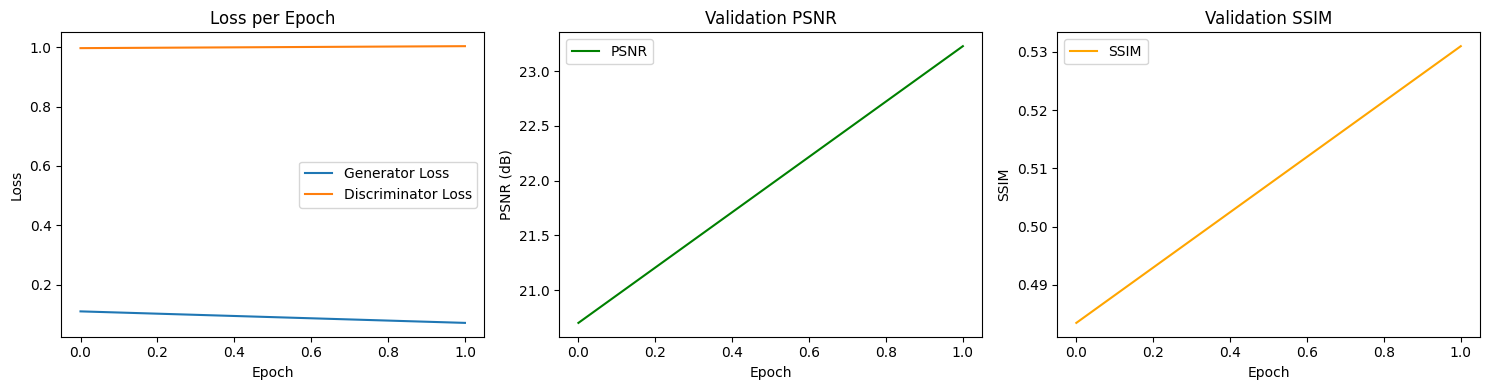

Epoch 3/100 [Validation]: 100%|██████████| 100/100 [00:19<00:00,  5.14it/s, PSNR=20.1, SSIM=0.516]



Epoch 3/100 Summary -- G Loss: 0.0681, D Loss: 0.9426, PSNR: 24.93, SSIM: 0.586


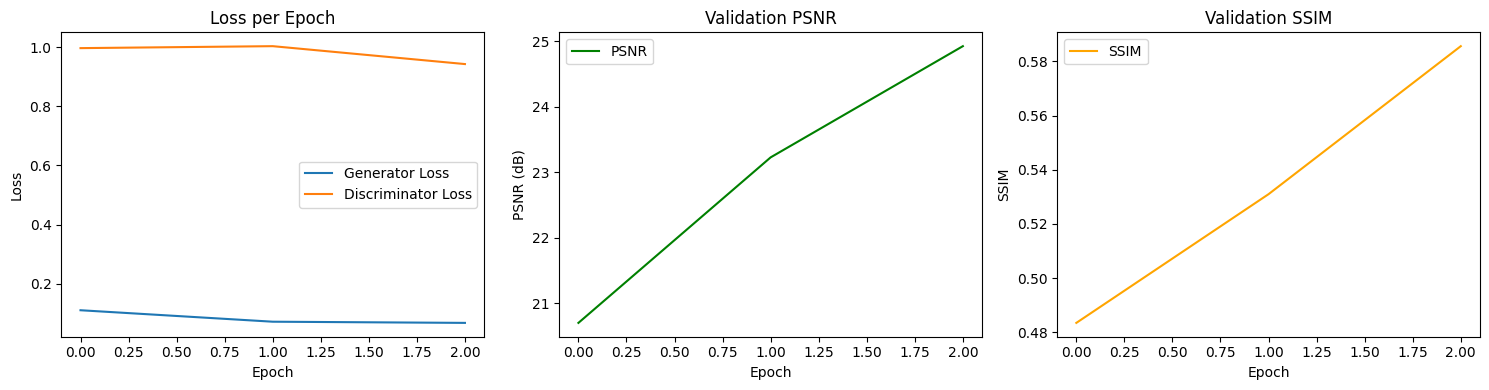

Epoch 4/100 [Validation]: 100%|██████████| 100/100 [00:18<00:00,  5.51it/s, PSNR=22.6, SSIM=0.646]



Epoch 4/100 Summary -- G Loss: 0.0689, D Loss: 0.9389, PSNR: 24.20, SSIM: 0.597


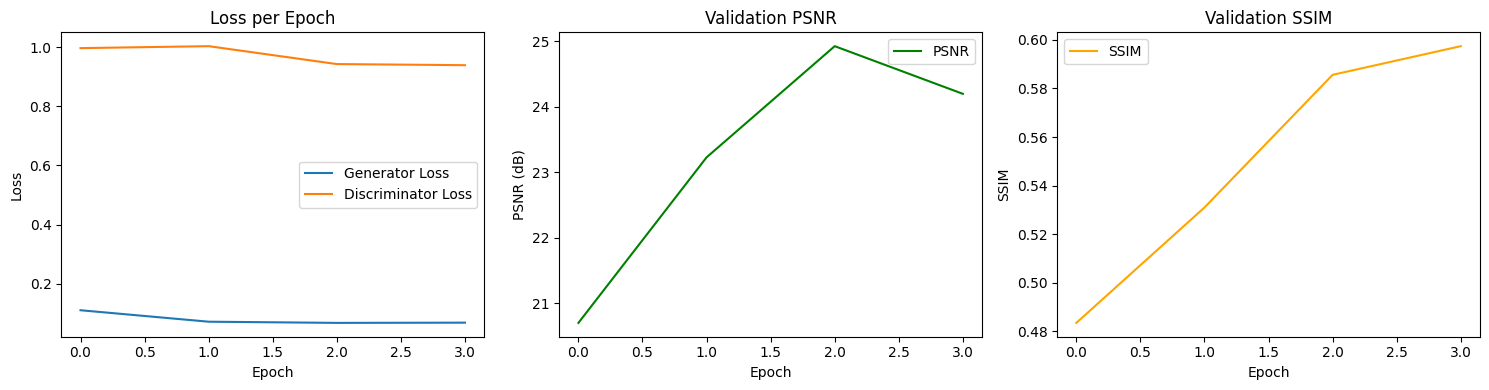

Epoch 5/100 [Validation]: 100%|██████████| 100/100 [00:19<00:00,  5.24it/s, PSNR=27.6, SSIM=0.811]



Epoch 5/100 Summary -- G Loss: 0.0721, D Loss: 0.8477, PSNR: 24.75, SSIM: 0.610


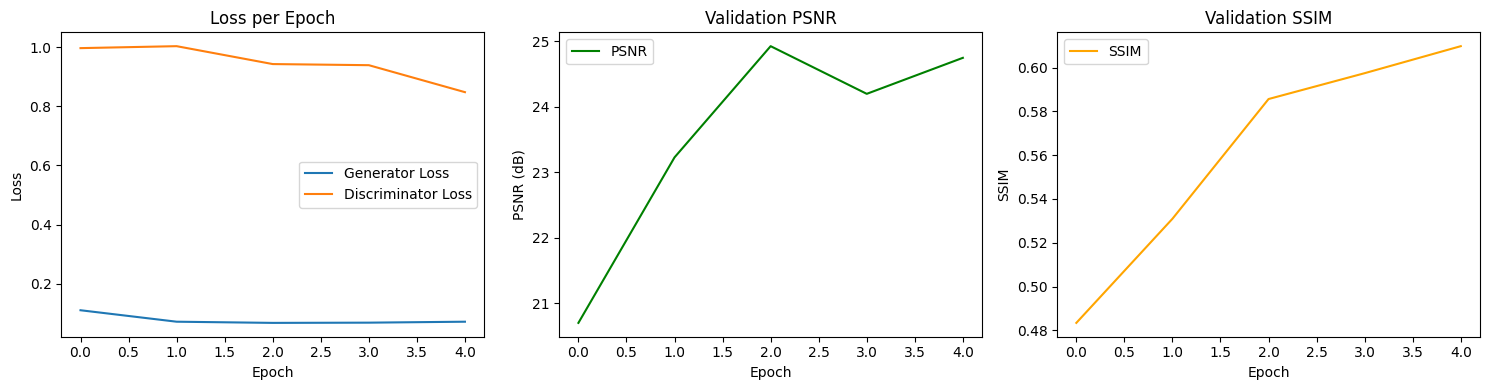

Epoch 6/100 [Validation]: 100%|██████████| 100/100 [00:18<00:00,  5.34it/s, PSNR=16.4, SSIM=0.392]



Epoch 6/100 Summary -- G Loss: 0.0692, D Loss: 0.7686, PSNR: 24.40, SSIM: 0.586


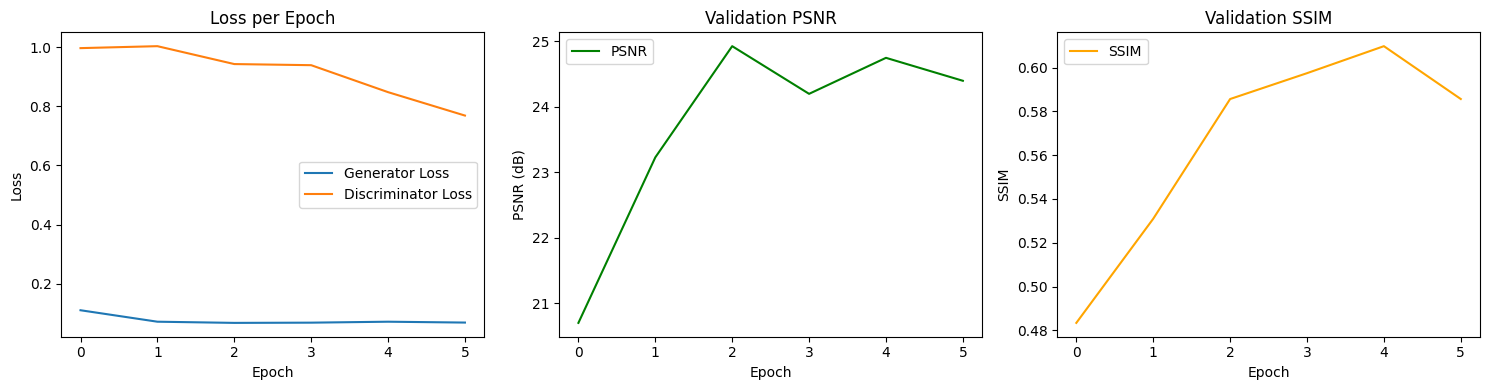

Epoch 7/100 [Validation]: 100%|██████████| 100/100 [00:18<00:00,  5.34it/s, PSNR=23.5, SSIM=0.55]



Epoch 7/100 Summary -- G Loss: 0.0712, D Loss: 0.7511, PSNR: 24.38, SSIM: 0.615


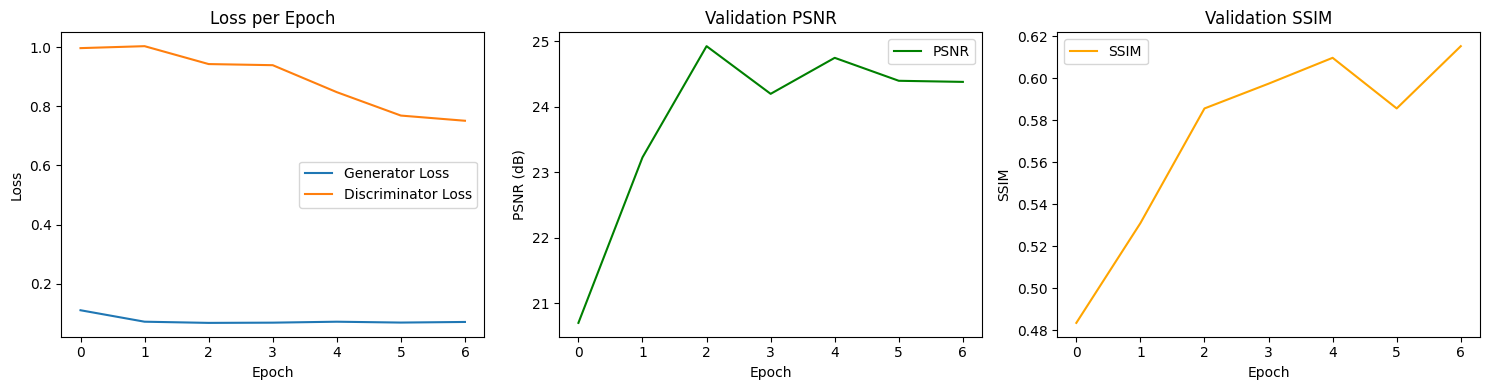

Epoch 8/100 [Validation]: 100%|██████████| 100/100 [00:19<00:00,  5.22it/s, PSNR=22.9, SSIM=0.642]



Epoch 8/100 Summary -- G Loss: 0.0692, D Loss: 0.8369, PSNR: 23.84, SSIM: 0.588


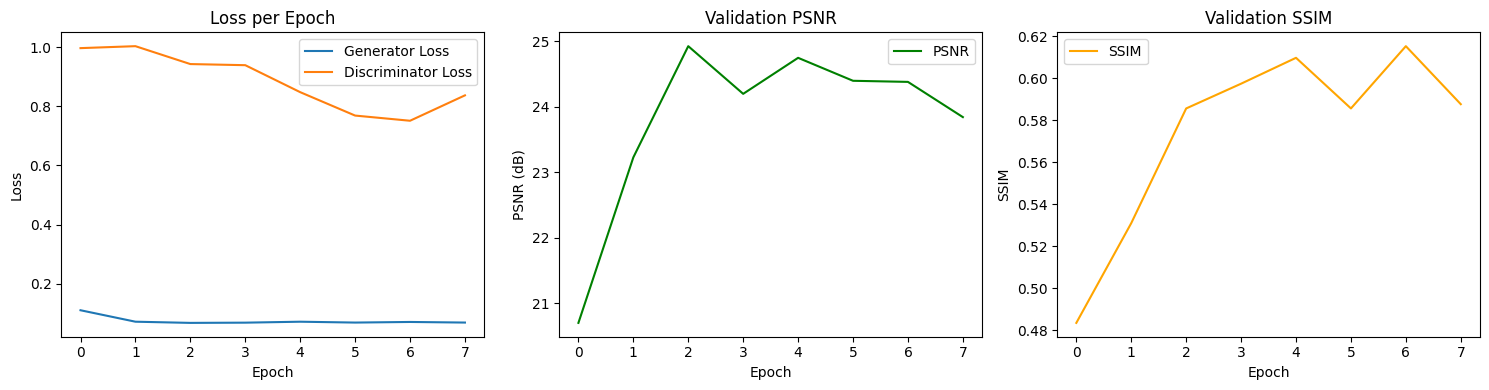

Epoch 9/100 [Validation]: 100%|██████████| 100/100 [00:18<00:00,  5.29it/s, PSNR=26.2, SSIM=0.757]



Epoch 9/100 Summary -- G Loss: 0.0708, D Loss: 0.7599, PSNR: 25.17, SSIM: 0.612


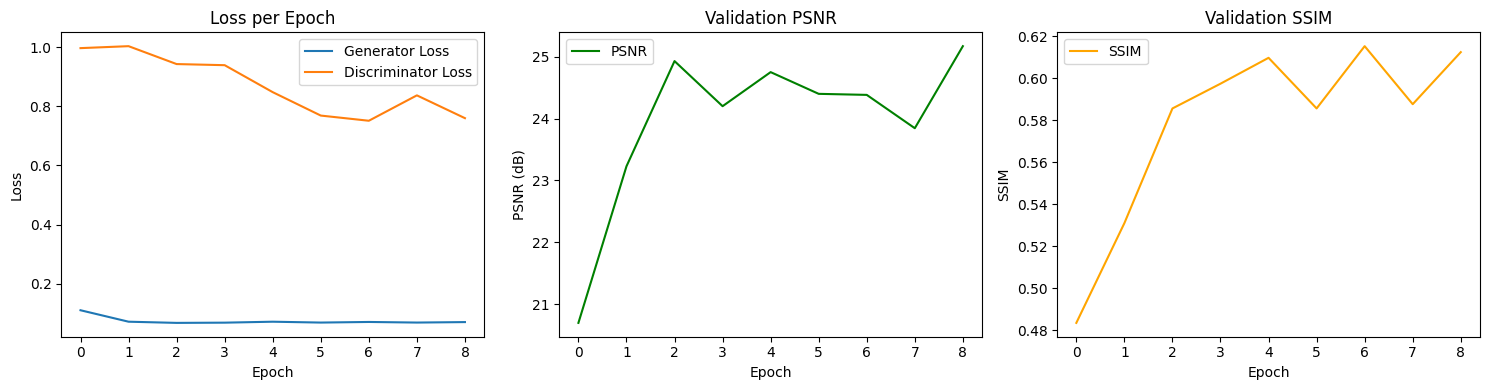

Epoch 10/100 [Validation]: 100%|██████████| 100/100 [00:19<00:00,  5.17it/s, PSNR=23.9, SSIM=0.631] 



Epoch 10/100 Summary -- G Loss: 0.0709, D Loss: 0.7592, PSNR: 24.34, SSIM: 0.580


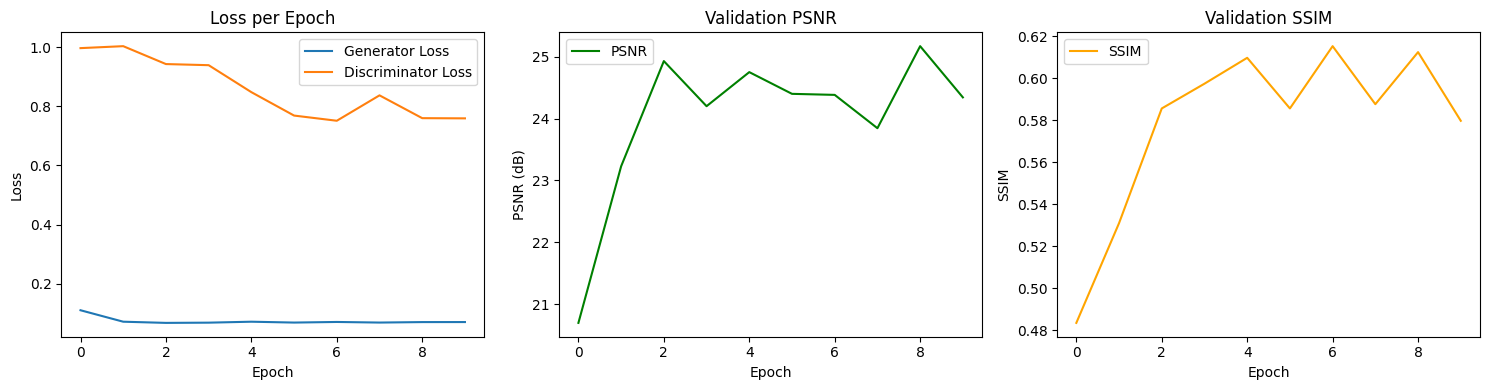

Epoch 11/100 [Validation]: 100%|██████████| 100/100 [00:19<00:00,  5.25it/s, PSNR=20.5, SSIM=0.59]



Epoch 11/100 Summary -- G Loss: 0.0724, D Loss: 0.7529, PSNR: 22.98, SSIM: 0.581


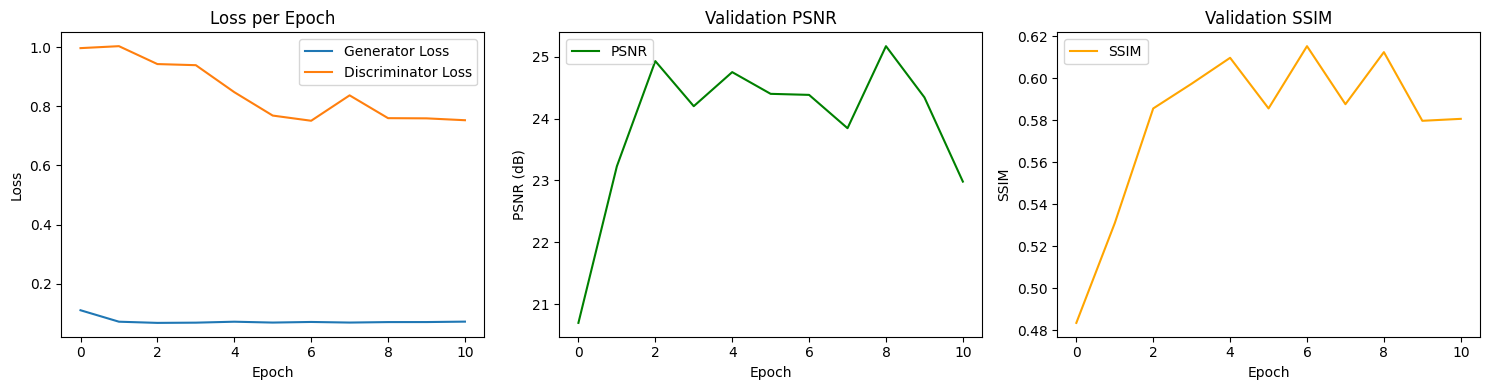

Epoch 12/100 [Validation]: 100%|██████████| 100/100 [00:19<00:00,  5.17it/s, PSNR=17.8, SSIM=0.421]



Epoch 12/100 Summary -- G Loss: 0.0737, D Loss: 0.7707, PSNR: 24.43, SSIM: 0.542


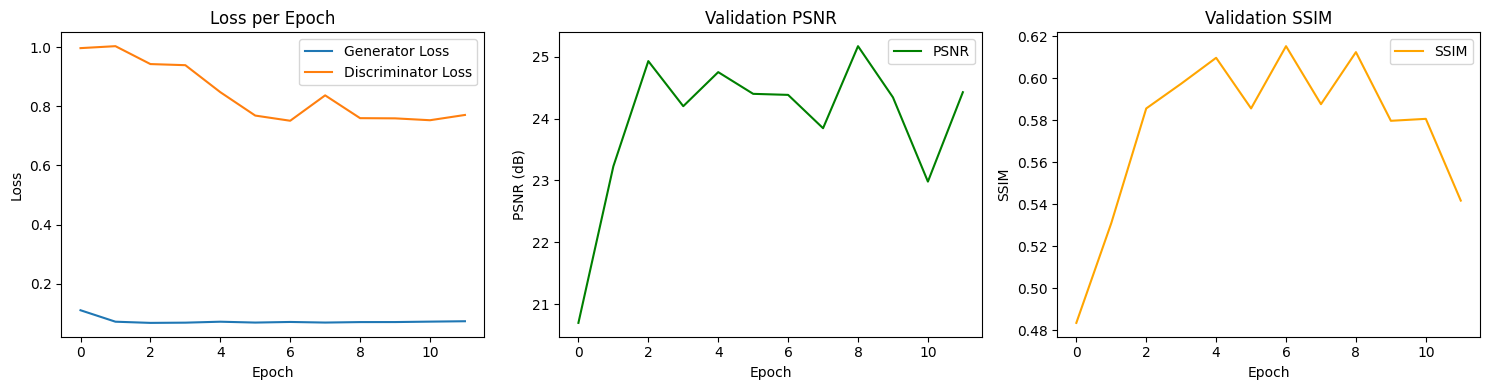

Epoch 13/100 [Validation]: 100%|██████████| 100/100 [00:18<00:00,  5.31it/s, PSNR=19, SSIM=0.478]    



Epoch 13/100 Summary -- G Loss: 0.0734, D Loss: 0.7387, PSNR: 23.81, SSIM: 0.557


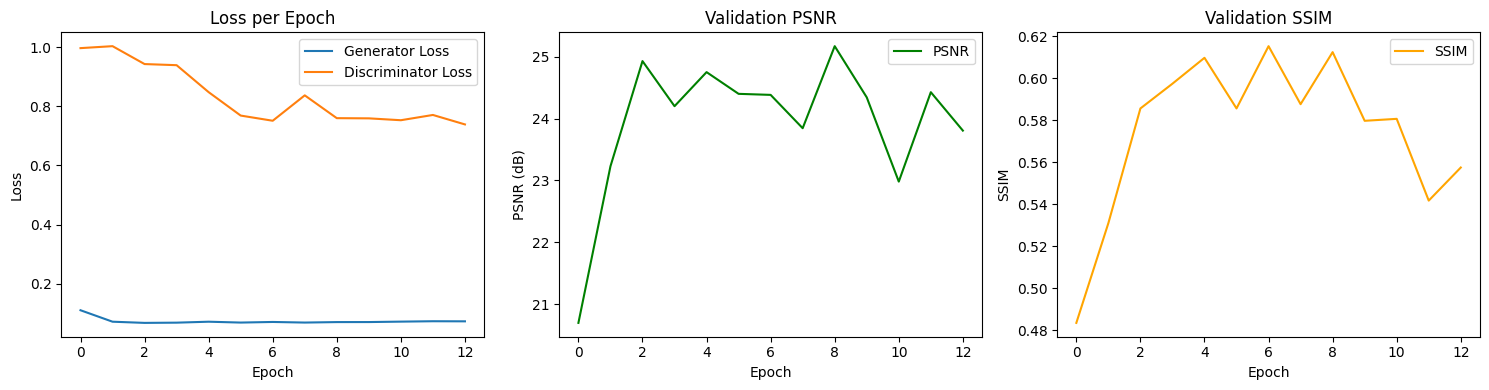

Epoch 14/100 [Validation]: 100%|██████████| 100/100 [00:19<00:00,  5.26it/s, PSNR=24.4, SSIM=0.642]



Epoch 14/100 Summary -- G Loss: 0.0725, D Loss: 0.7636, PSNR: 24.07, SSIM: 0.580


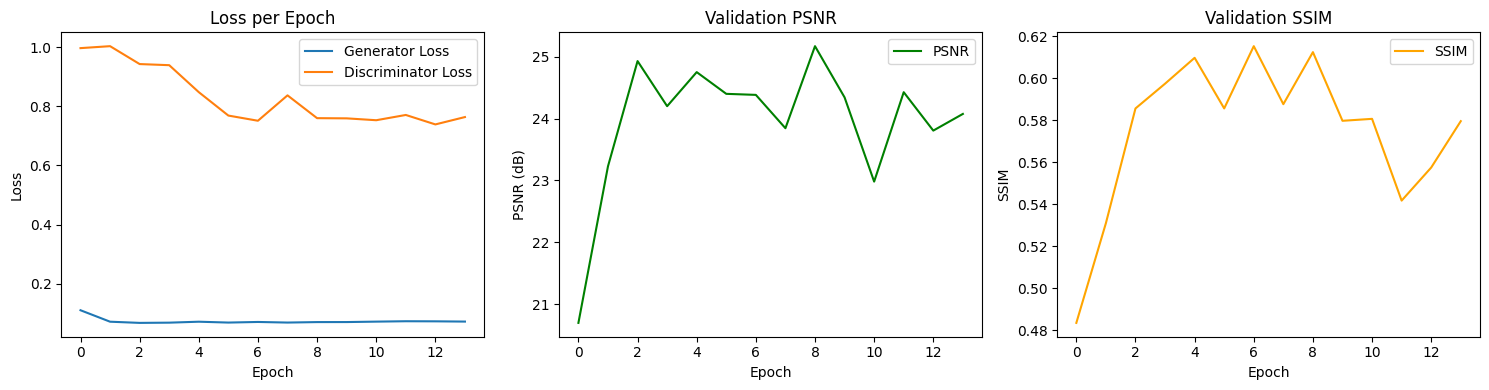

Epoch 15/100 [Validation]: 100%|██████████| 100/100 [00:19<00:00,  5.13it/s, PSNR=24.7, SSIM=0.628] 



Epoch 15/100 Summary -- G Loss: 0.0719, D Loss: 0.7790, PSNR: 24.29, SSIM: 0.553


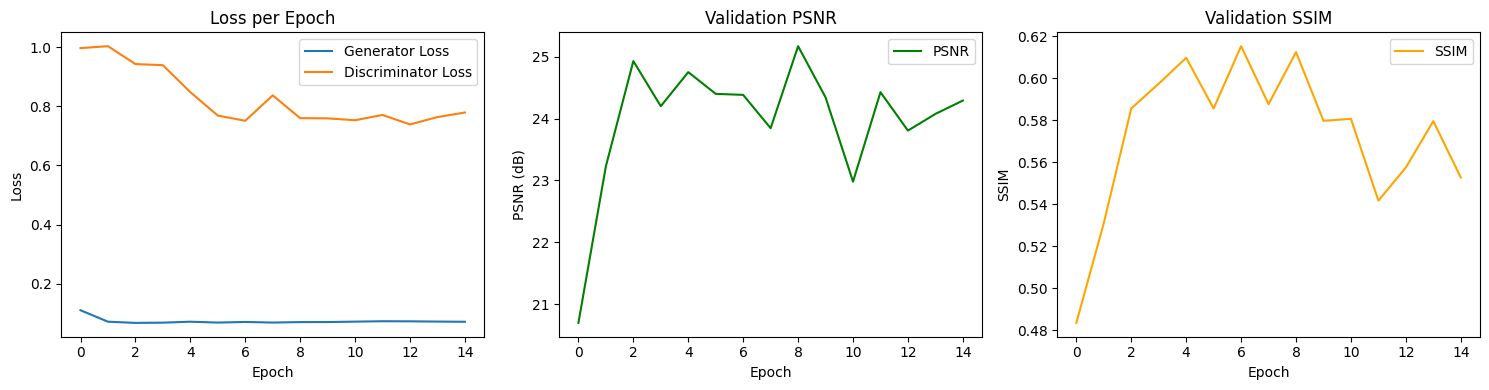

Epoch 16/100 [Validation]: 100%|██████████| 100/100 [00:19<00:00,  5.23it/s, PSNR=22.7, SSIM=0.655]



Epoch 16/100 Summary -- G Loss: 0.0738, D Loss: 0.7488, PSNR: 22.82, SSIM: 0.552


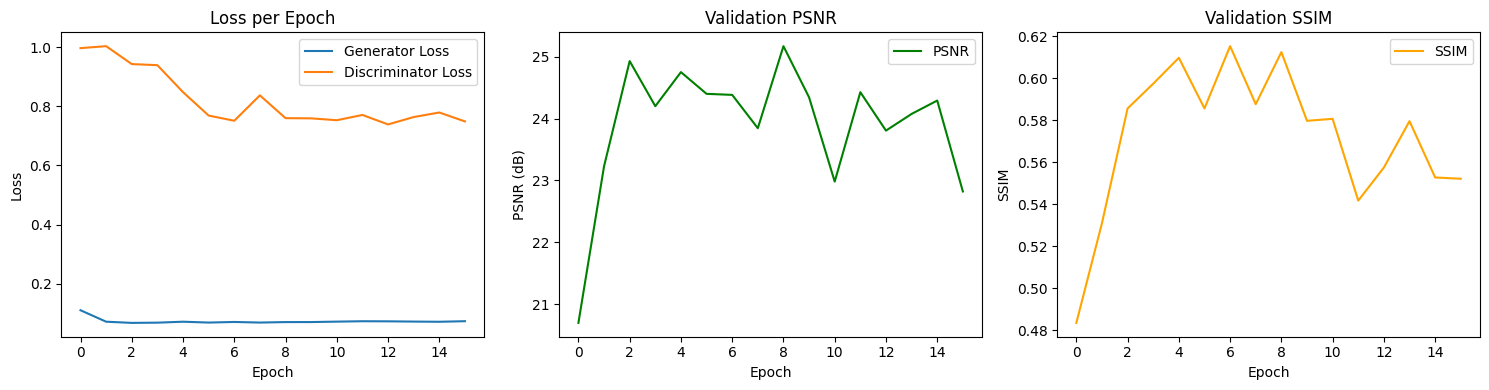

Epoch 17/100 [Validation]: 100%|██████████| 100/100 [00:19<00:00,  5.22it/s, PSNR=27.3, SSIM=0.809]



Epoch 17/100 Summary -- G Loss: 0.0736, D Loss: 0.7630, PSNR: 25.46, SSIM: 0.617


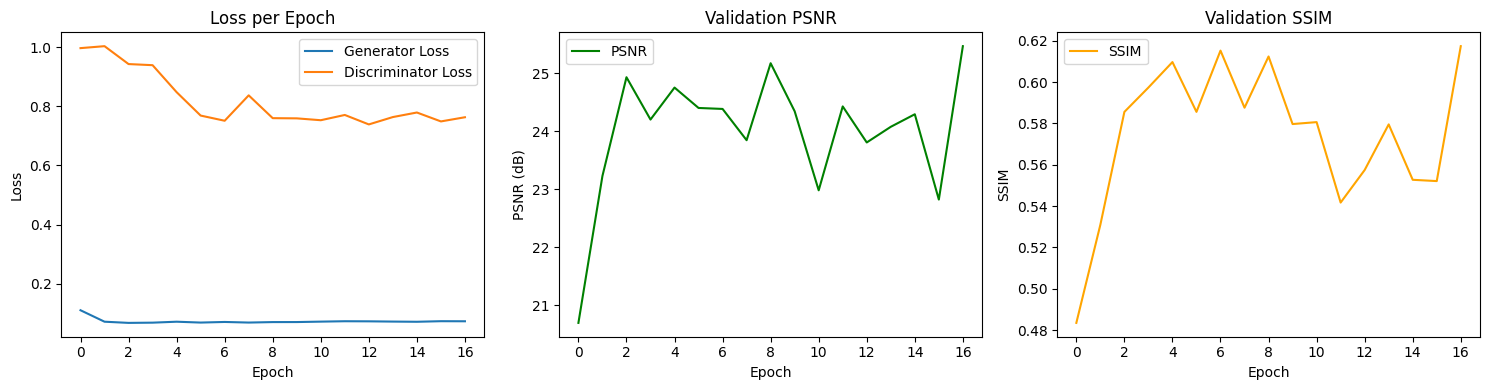

Epoch 18/100 [Validation]: 100%|██████████| 100/100 [00:18<00:00,  5.34it/s, PSNR=24.2, SSIM=0.737]



Epoch 18/100 Summary -- G Loss: 0.0715, D Loss: 0.7486, PSNR: 25.25, SSIM: 0.613


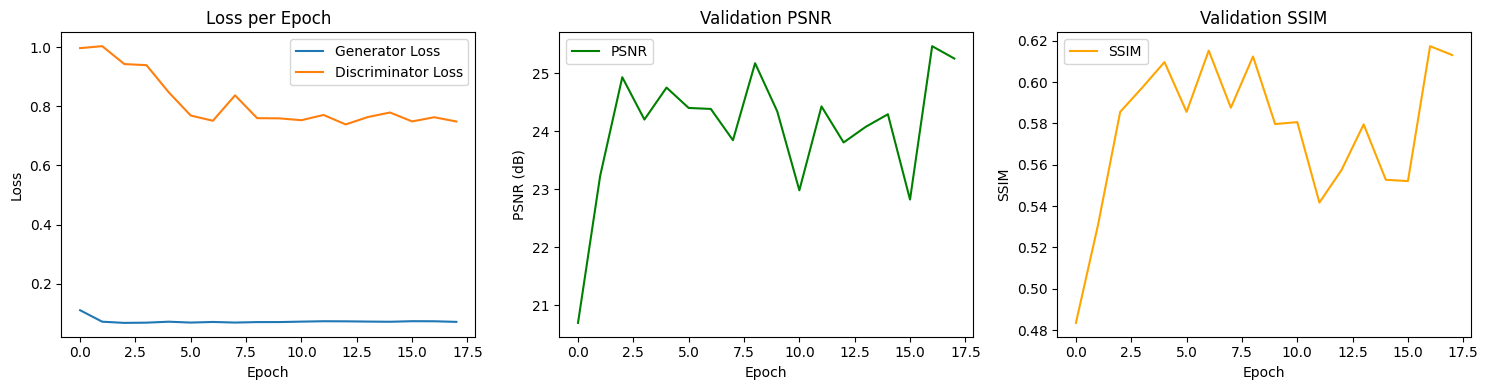

Epoch 19/100 [Validation]: 100%|██████████| 100/100 [00:19<00:00,  5.11it/s, PSNR=25.5, SSIM=0.678]



Epoch 19/100 Summary -- G Loss: 0.0716, D Loss: 0.7456, PSNR: 23.40, SSIM: 0.500


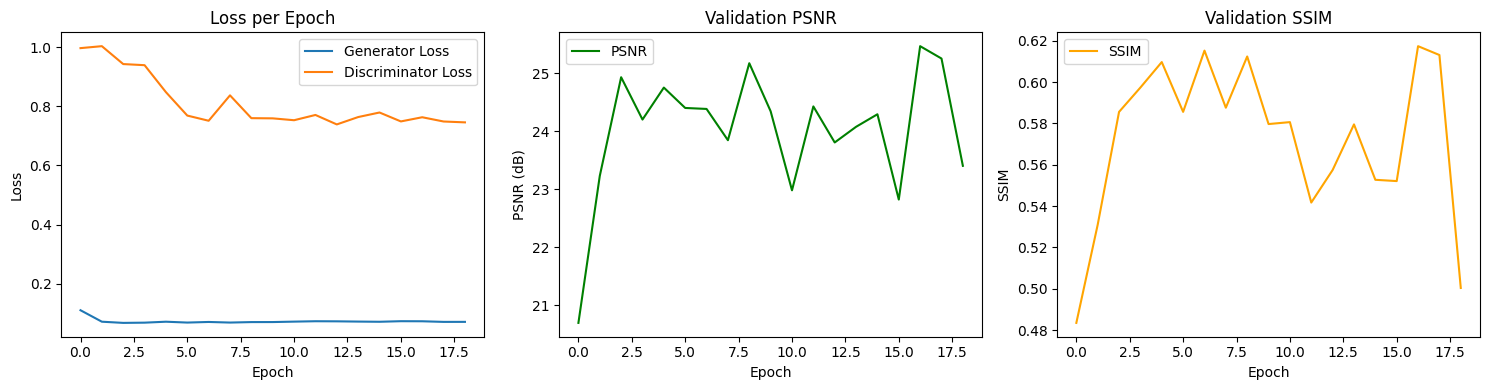

Epoch 20/100 [Validation]: 100%|██████████| 100/100 [00:19<00:00,  5.12it/s, PSNR=27.2, SSIM=0.783]



Epoch 20/100 Summary -- G Loss: 0.0709, D Loss: 0.7687, PSNR: 25.07, SSIM: 0.565


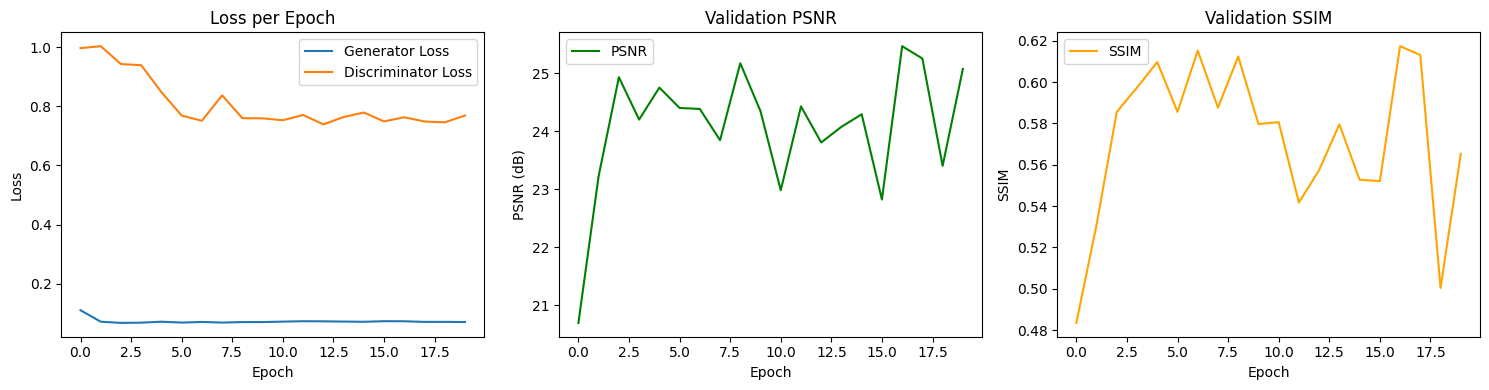

Epoch 21/100 [Validation]: 100%|██████████| 100/100 [00:18<00:00,  5.26it/s, PSNR=27.7, SSIM=0.692]



Epoch 21/100 Summary -- G Loss: 0.0683, D Loss: 0.7773, PSNR: 25.01, SSIM: 0.586


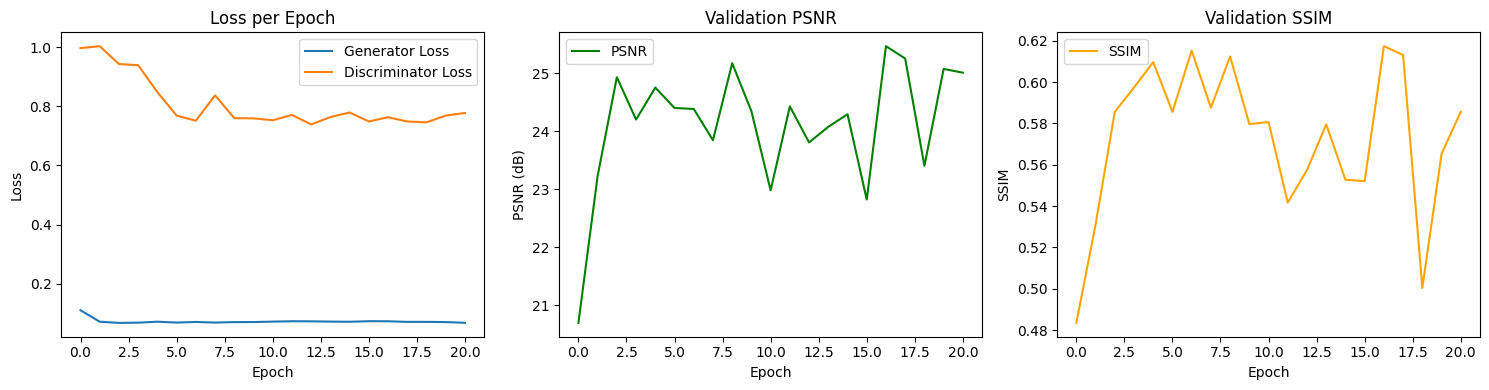

Epoch 22/100 [Validation]: 100%|██████████| 100/100 [00:18<00:00,  5.26it/s, PSNR=22.9, SSIM=0.644] 



Epoch 22/100 Summary -- G Loss: 0.0708, D Loss: 0.7895, PSNR: 24.46, SSIM: 0.540


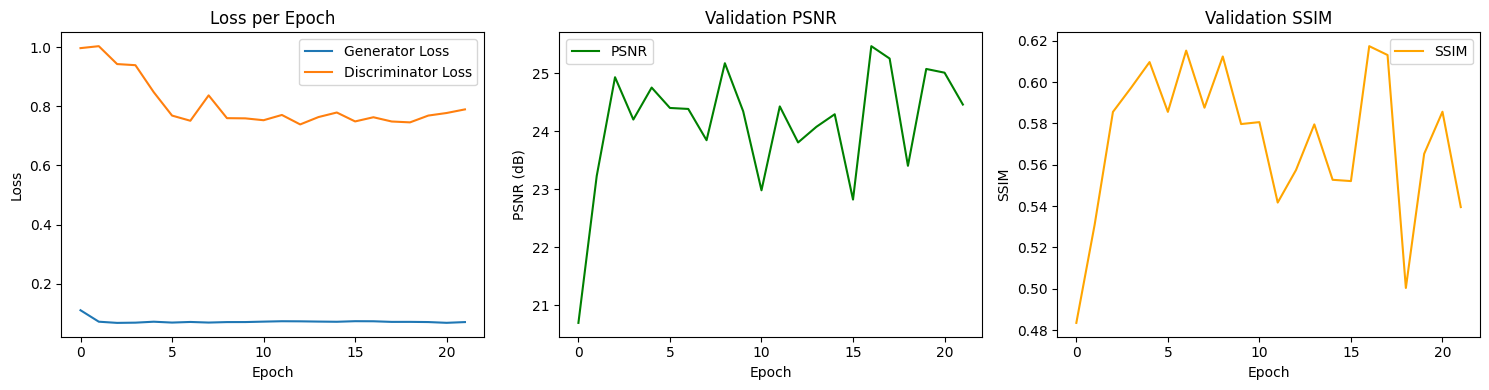

Epoch 23/100 [Validation]: 100%|██████████| 100/100 [00:19<00:00,  5.25it/s, PSNR=17, SSIM=0.474]  



Epoch 23/100 Summary -- G Loss: 0.0690, D Loss: 0.7954, PSNR: 22.95, SSIM: 0.550


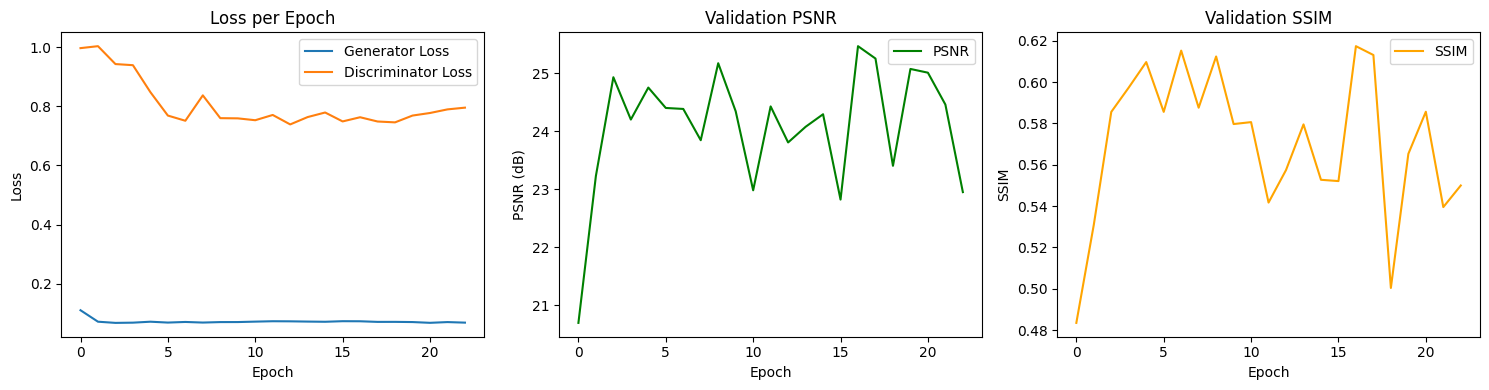

Epoch 24/100 [Validation]: 100%|██████████| 100/100 [00:19<00:00,  5.15it/s, PSNR=24.1, SSIM=0.696]



Epoch 24/100 Summary -- G Loss: 0.0683, D Loss: 0.7962, PSNR: 25.11, SSIM: 0.573


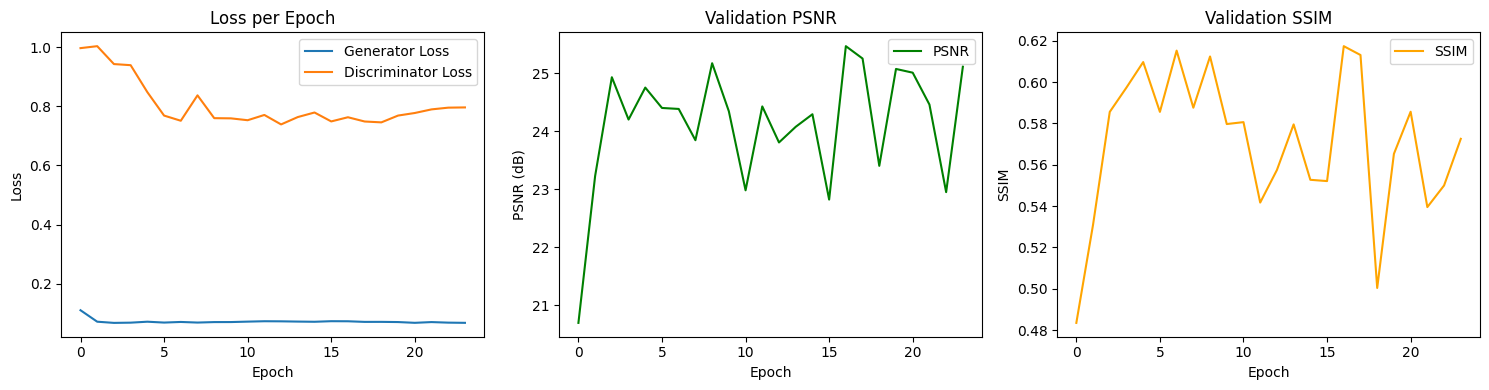

Epoch 25/100 [Validation]: 100%|██████████| 100/100 [00:19<00:00,  5.14it/s, PSNR=26.1, SSIM=0.635]  



Epoch 25/100 Summary -- G Loss: 0.0688, D Loss: 0.7944, PSNR: 23.12, SSIM: 0.548


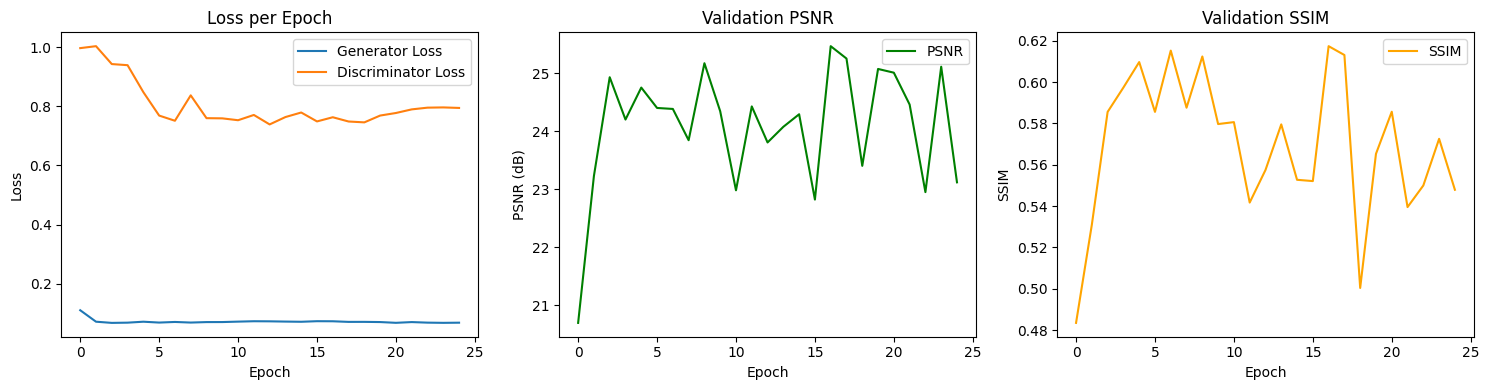

Epoch 26/100 [Validation]: 100%|██████████| 100/100 [00:19<00:00,  5.20it/s, PSNR=27.5, SSIM=0.716]



Epoch 26/100 Summary -- G Loss: 0.0673, D Loss: 0.7793, PSNR: 25.22, SSIM: 0.565


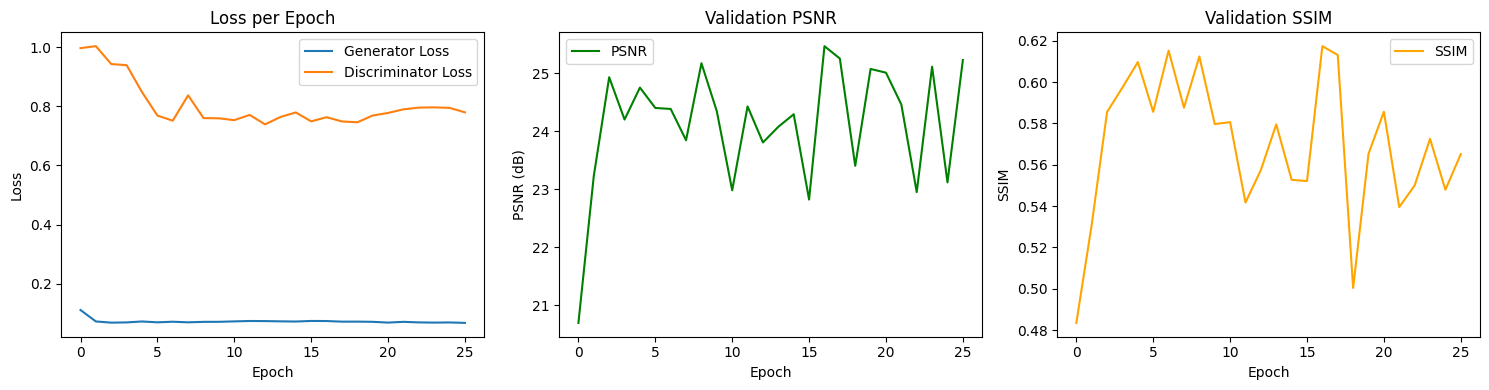

Epoch 27/100 [Validation]: 100%|██████████| 100/100 [00:18<00:00,  5.32it/s, PSNR=26.1, SSIM=0.658]



Epoch 27/100 Summary -- G Loss: 0.0658, D Loss: 0.8048, PSNR: 23.37, SSIM: 0.565


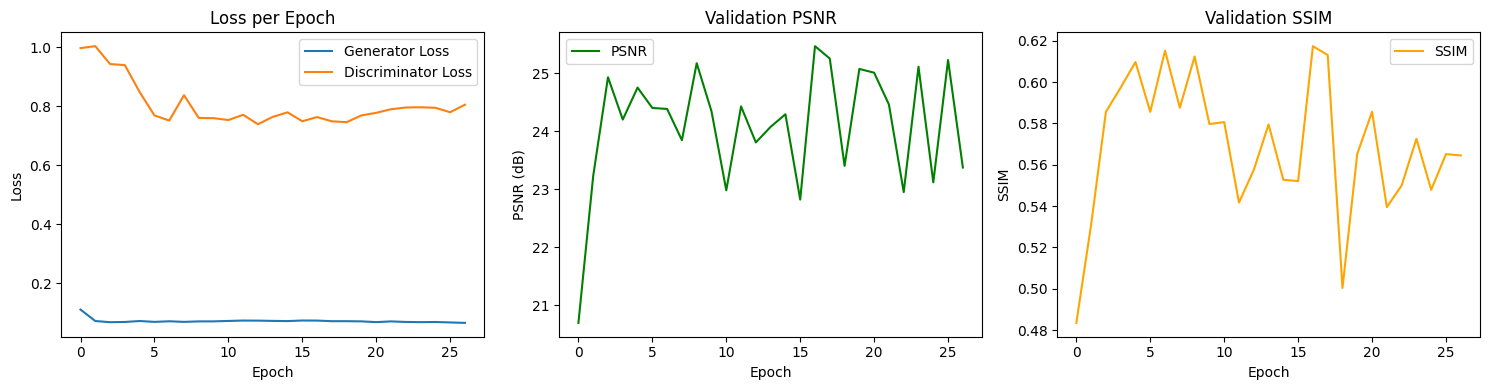

Epoch 28/100 [Validation]: 100%|██████████| 100/100 [00:18<00:00,  5.34it/s, PSNR=26.3, SSIM=0.623]



Epoch 28/100 Summary -- G Loss: 0.0677, D Loss: 0.8005, PSNR: 25.65, SSIM: 0.621


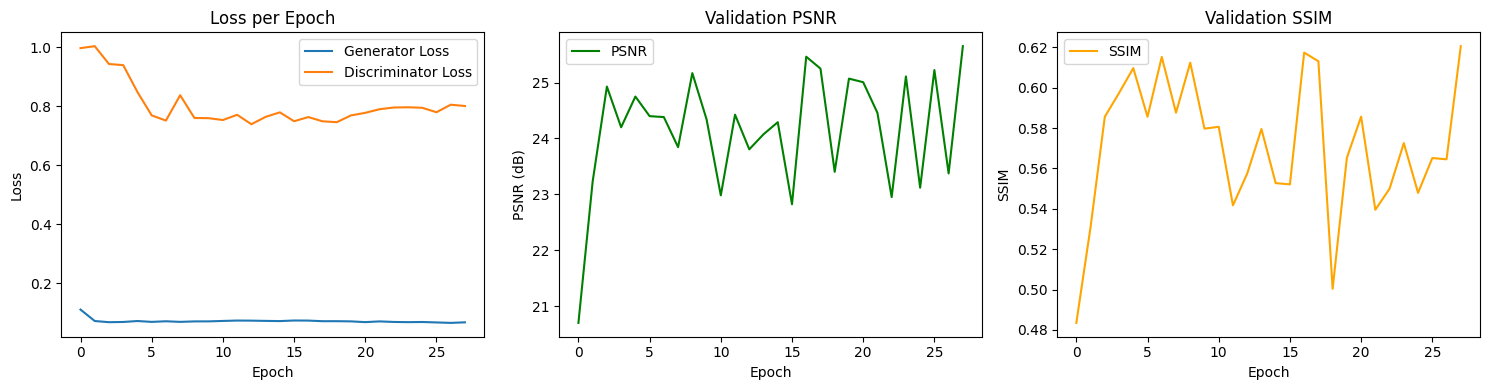

Epoch 29/100 [Validation]: 100%|██████████| 100/100 [00:19<00:00,  5.21it/s, PSNR=24.3, SSIM=0.71]  



Epoch 29/100 Summary -- G Loss: 0.0675, D Loss: 0.7889, PSNR: 25.41, SSIM: 0.548


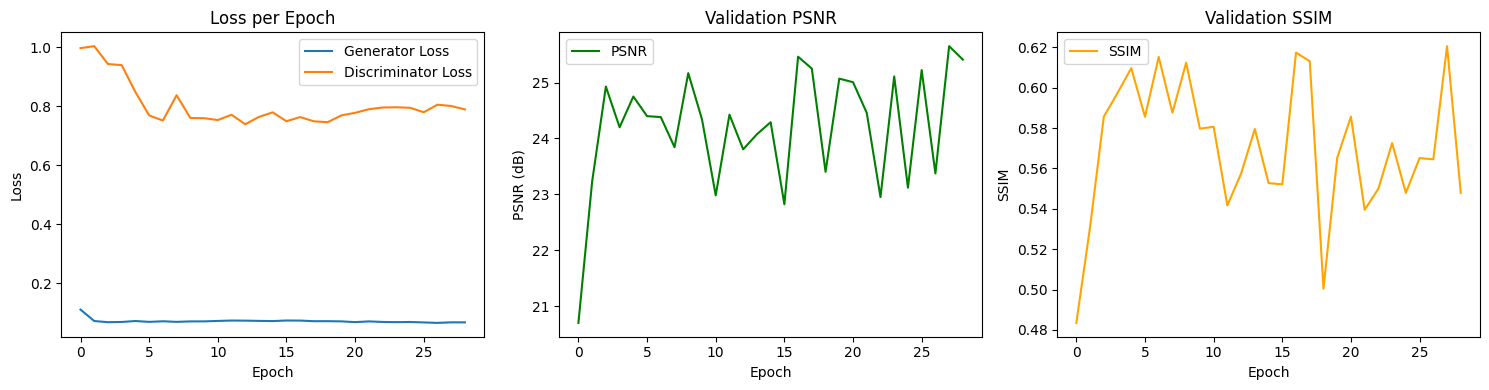

Epoch 30/100 [Validation]: 100%|██████████| 100/100 [00:19<00:00,  5.12it/s, PSNR=28, SSIM=0.819]  



Epoch 30/100 Summary -- G Loss: 0.0687, D Loss: 0.7981, PSNR: 24.00, SSIM: 0.573


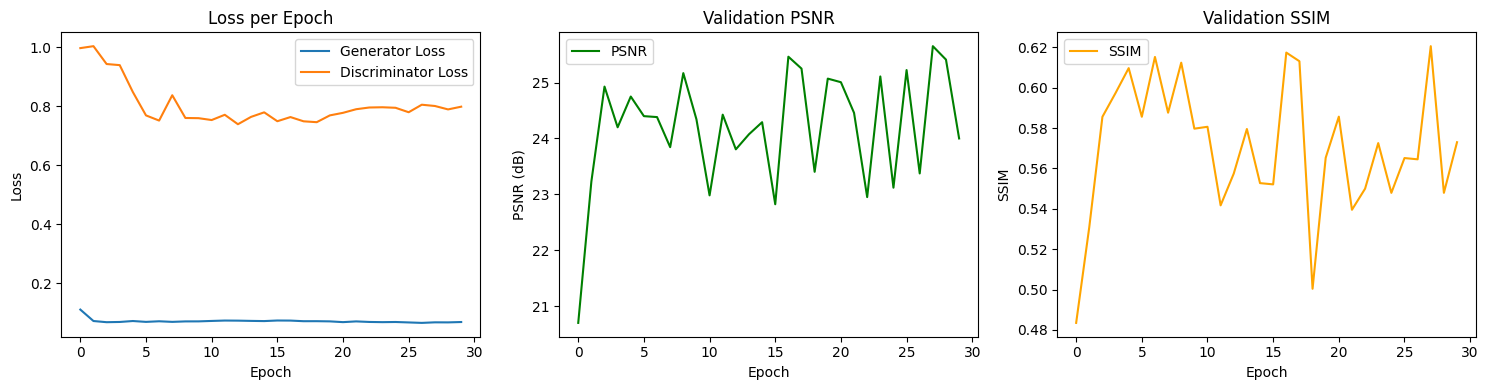

Epoch 31/100 [Validation]: 100%|██████████| 100/100 [00:19<00:00,  5.16it/s, PSNR=19.5, SSIM=0.655]



Epoch 31/100 Summary -- G Loss: 0.0673, D Loss: 0.7923, PSNR: 25.18, SSIM: 0.523


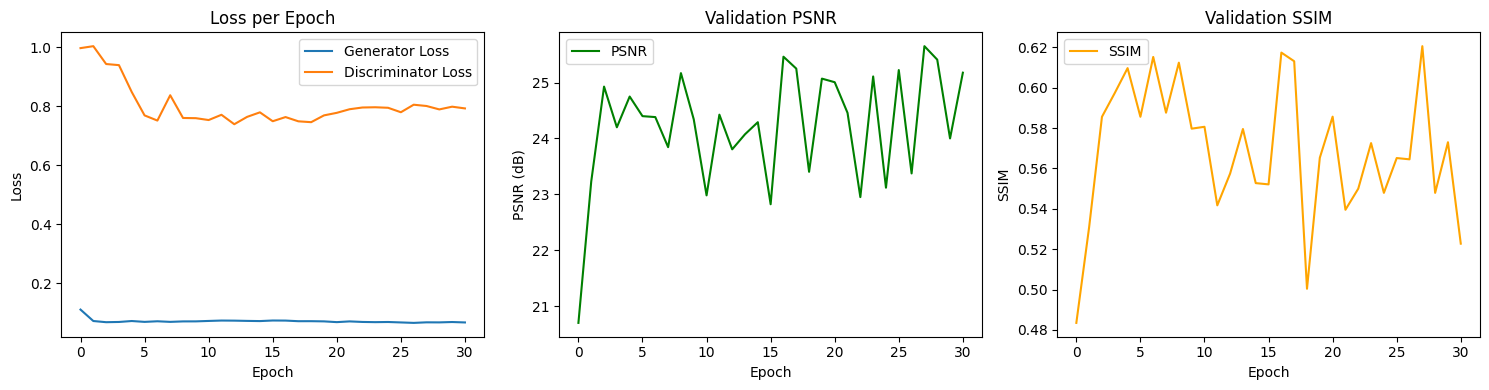

Epoch 32/100 [Validation]: 100%|██████████| 100/100 [00:19<00:00,  5.21it/s, PSNR=21.2, SSIM=0.562]



Epoch 32/100 Summary -- G Loss: 0.0690, D Loss: 0.8128, PSNR: 24.03, SSIM: 0.555


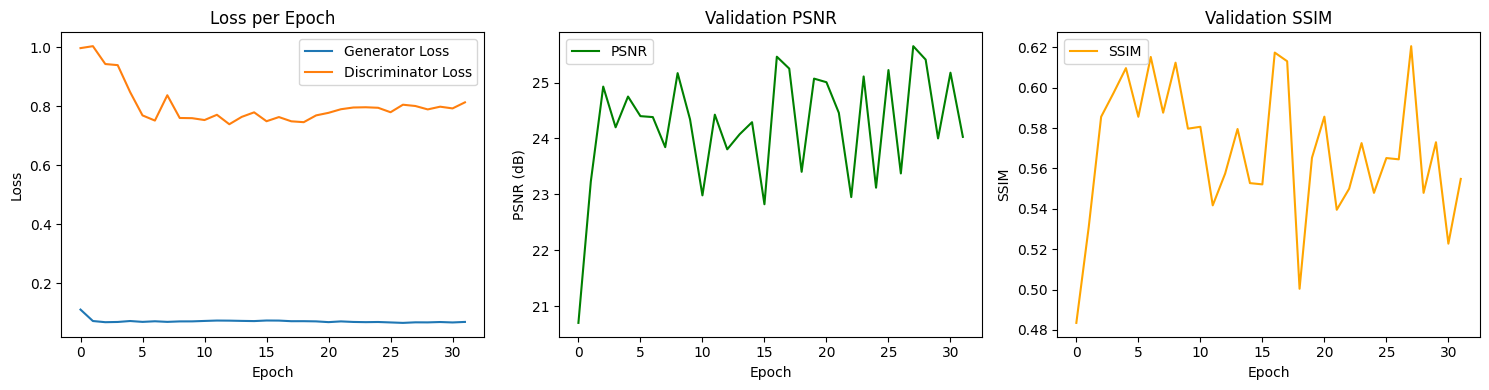

Epoch 33/100 [Validation]: 100%|██████████| 100/100 [00:18<00:00,  5.32it/s, PSNR=25.5, SSIM=0.708]



Epoch 33/100 Summary -- G Loss: 0.0656, D Loss: 0.7929, PSNR: 24.95, SSIM: 0.612


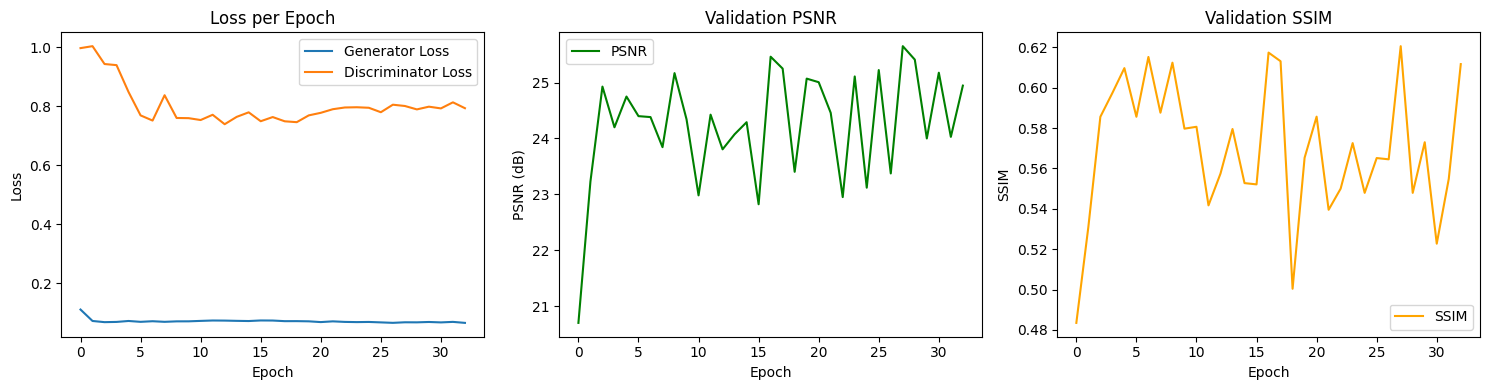

Epoch 34/100 [Validation]: 100%|██████████| 100/100 [00:19<00:00,  5.13it/s, PSNR=22.8, SSIM=nan]   



Epoch 34/100 Summary -- G Loss: 0.0684, D Loss: 0.8003, PSNR: 24.22, SSIM: 0.482


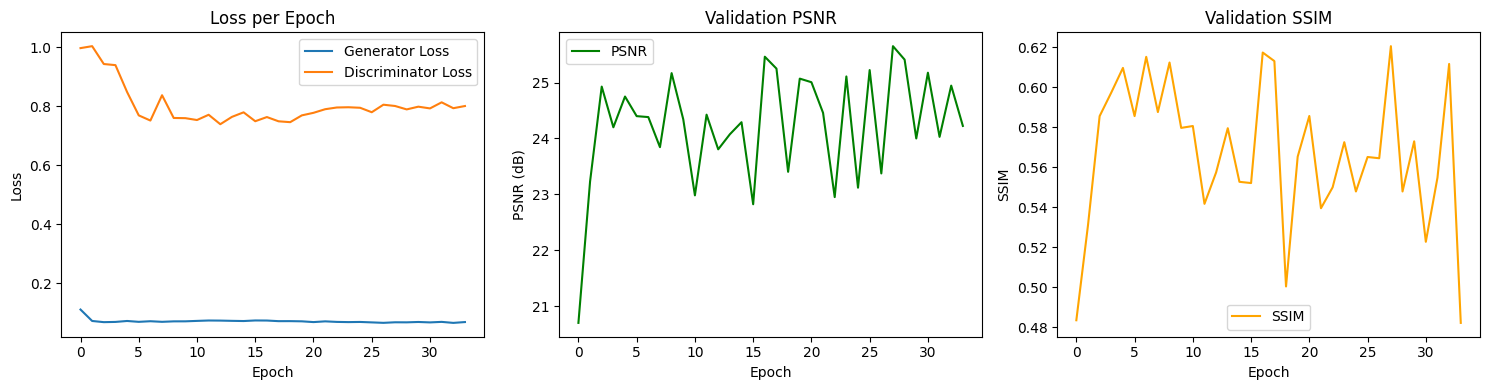

Epoch 35/100 [Validation]: 100%|██████████| 100/100 [00:19<00:00,  5.23it/s, PSNR=25.7, SSIM=0.711]



Epoch 35/100 Summary -- G Loss: 0.0663, D Loss: 0.8034, PSNR: 25.44, SSIM: 0.628


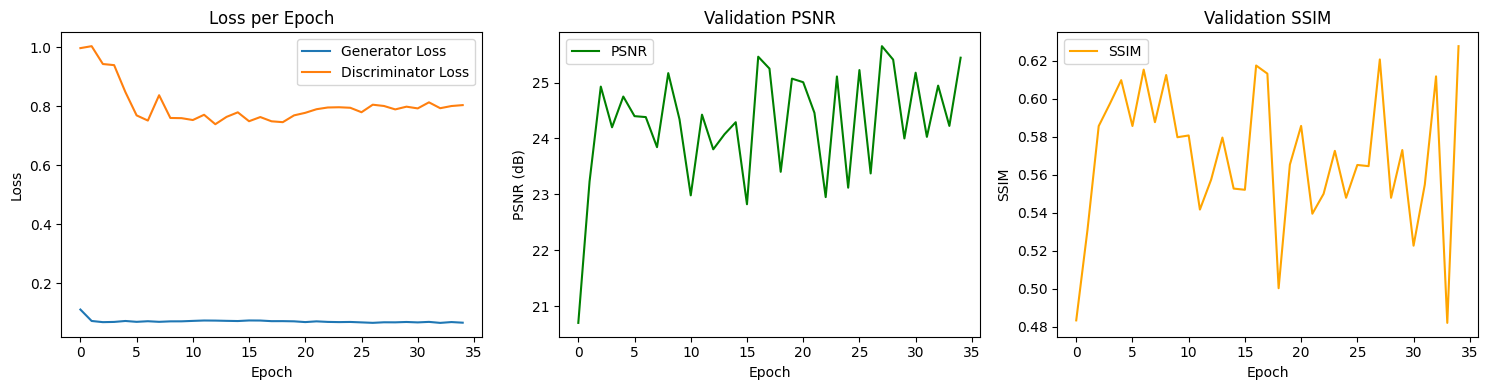

Epoch 36/100 [Validation]: 100%|██████████| 100/100 [00:19<00:00,  5.23it/s, PSNR=23.1, SSIM=0.71] 



Epoch 36/100 Summary -- G Loss: 0.0665, D Loss: 0.8188, PSNR: 24.70, SSIM: 0.601


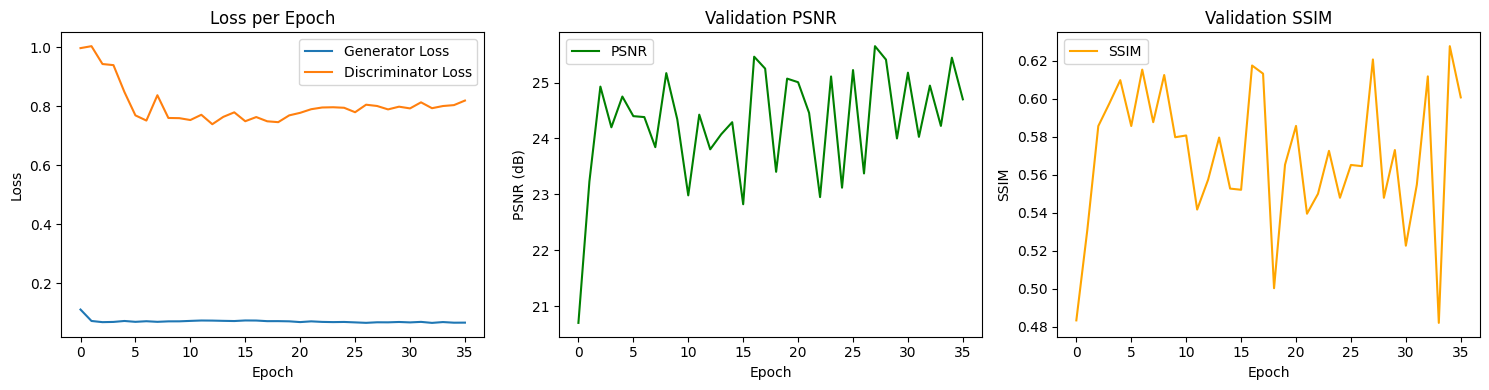

Epoch 37/100 [Validation]: 100%|██████████| 100/100 [00:19<00:00,  5.25it/s, PSNR=20.1, SSIM=0.563]



Epoch 37/100 Summary -- G Loss: 0.0679, D Loss: 0.7885, PSNR: 23.46, SSIM: 0.515


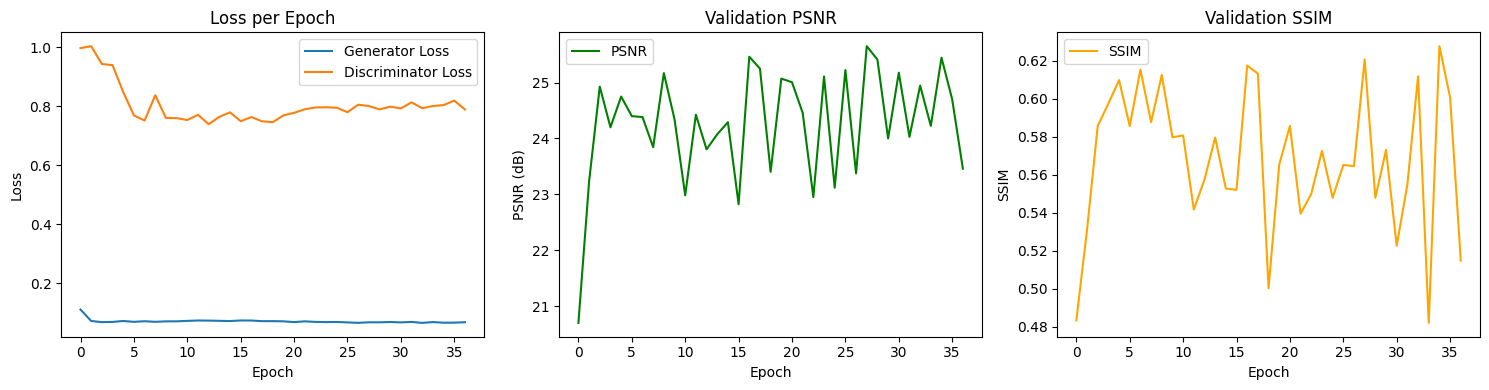

Epoch 38/100 [Validation]: 100%|██████████| 100/100 [00:19<00:00,  5.07it/s, PSNR=26.2, SSIM=0.765]



Epoch 38/100 Summary -- G Loss: 0.0663, D Loss: 0.8088, PSNR: 25.61, SSIM: 0.568


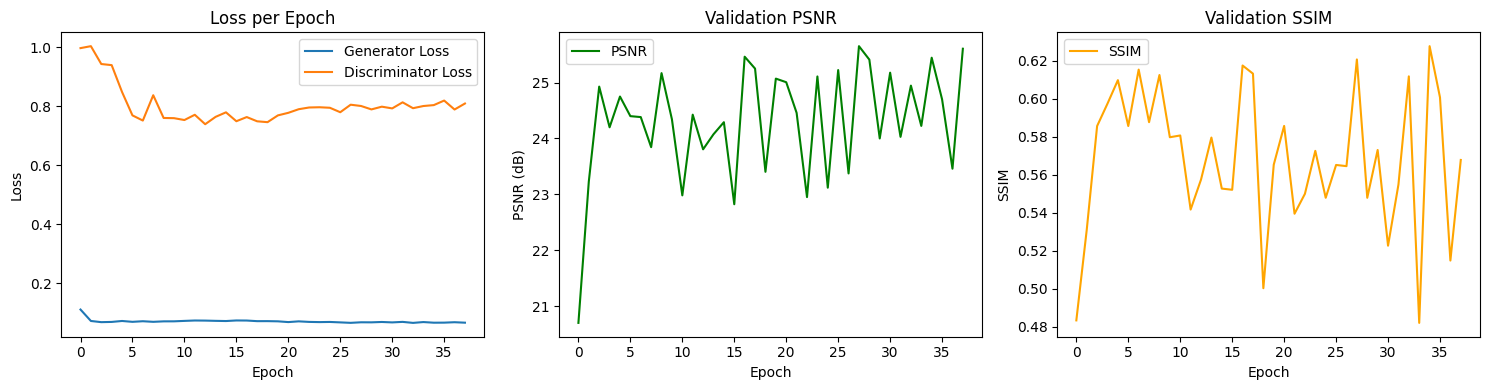

Epoch 39/100 [Validation]: 100%|██████████| 100/100 [00:19<00:00,  5.07it/s, PSNR=21.9, SSIM=0.6]  



Epoch 39/100 Summary -- G Loss: 0.0673, D Loss: 0.8104, PSNR: 25.61, SSIM: 0.390


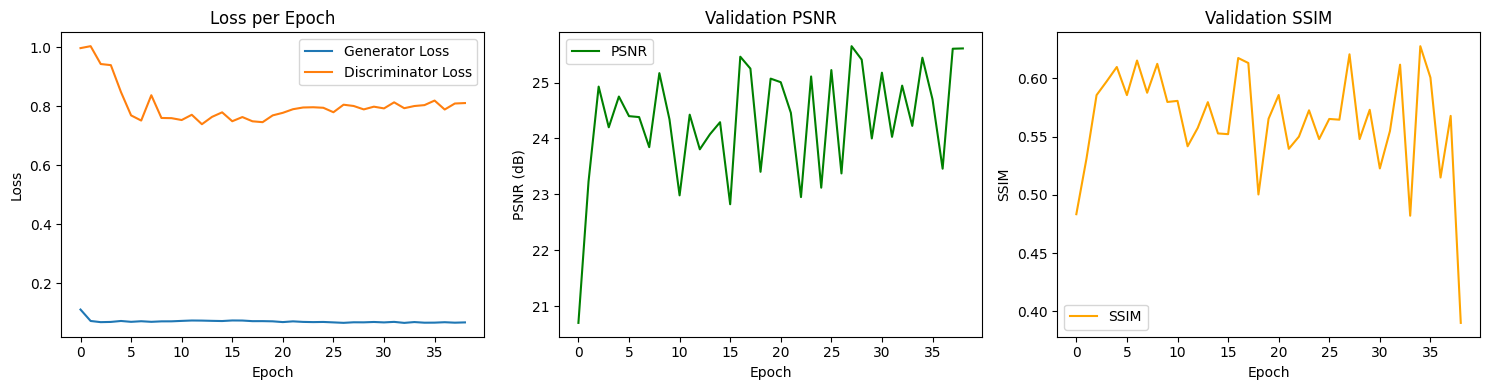

Epoch 40/100 [Validation]: 100%|██████████| 100/100 [00:19<00:00,  5.11it/s, PSNR=23.2, SSIM=0.69] 



Epoch 40/100 Summary -- G Loss: 0.0660, D Loss: 0.7955, PSNR: 25.74, SSIM: 0.617


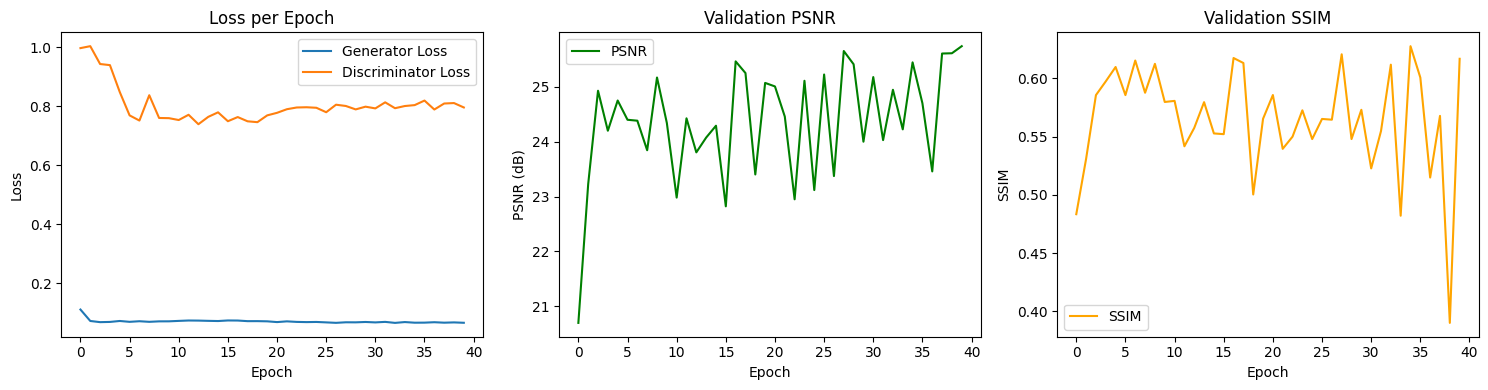

Epoch 41/100 [Validation]: 100%|██████████| 100/100 [00:19<00:00,  5.10it/s, PSNR=24.1, SSIM=0.739] 



Epoch 41/100 Summary -- G Loss: 0.0658, D Loss: 0.7965, PSNR: 24.78, SSIM: 0.552


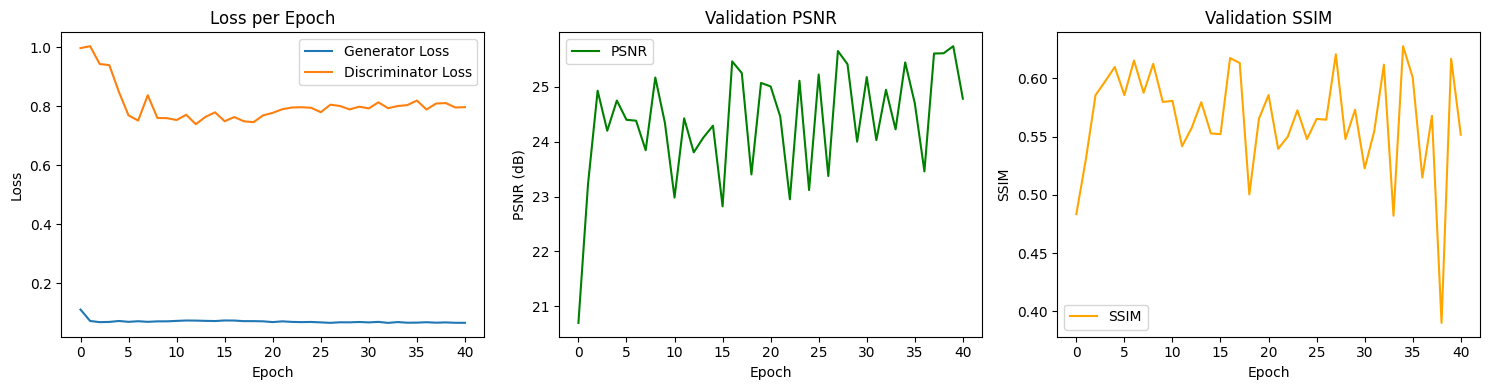

Epoch 42/100 [Validation]: 100%|██████████| 100/100 [00:19<00:00,  5.16it/s, PSNR=18.8, SSIM=0.645]



Epoch 42/100 Summary -- G Loss: 0.0651, D Loss: 0.8187, PSNR: 24.64, SSIM: 0.488


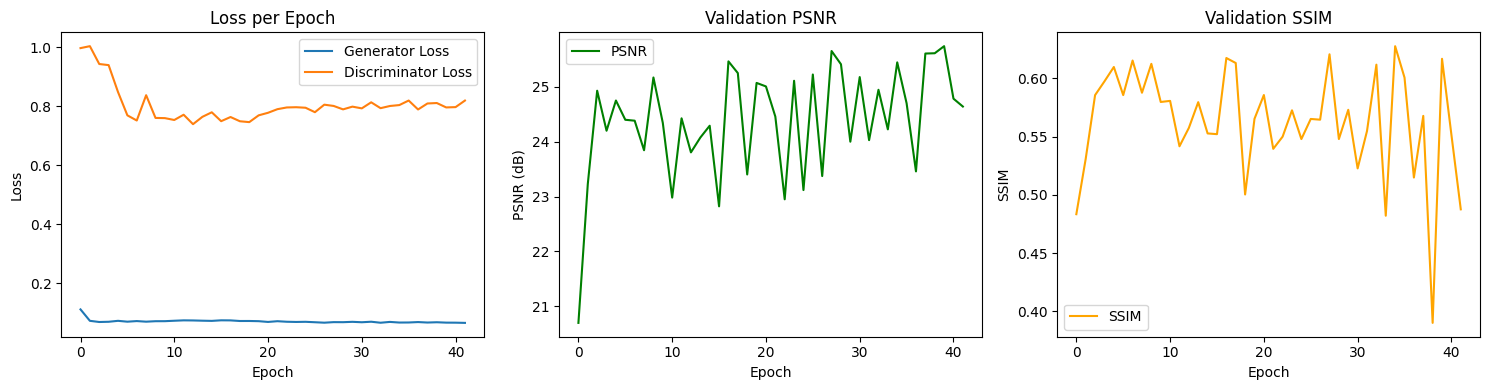

Epoch 43/100 [Validation]: 100%|██████████| 100/100 [00:19<00:00,  5.21it/s, PSNR=23.6, SSIM=0.662]



Epoch 43/100 Summary -- G Loss: 0.0643, D Loss: 0.8137, PSNR: 24.49, SSIM: 0.524


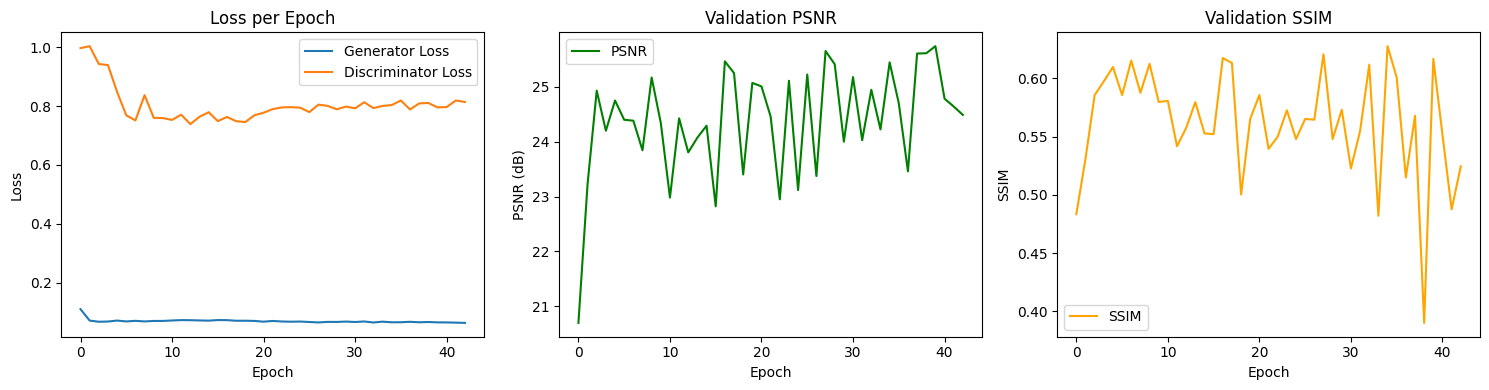

Epoch 44/100 [Validation]: 100%|██████████| 100/100 [00:19<00:00,  5.17it/s, PSNR=25.5, SSIM=0.669]



Epoch 44/100 Summary -- G Loss: 0.0638, D Loss: 0.8289, PSNR: 23.05, SSIM: 0.507


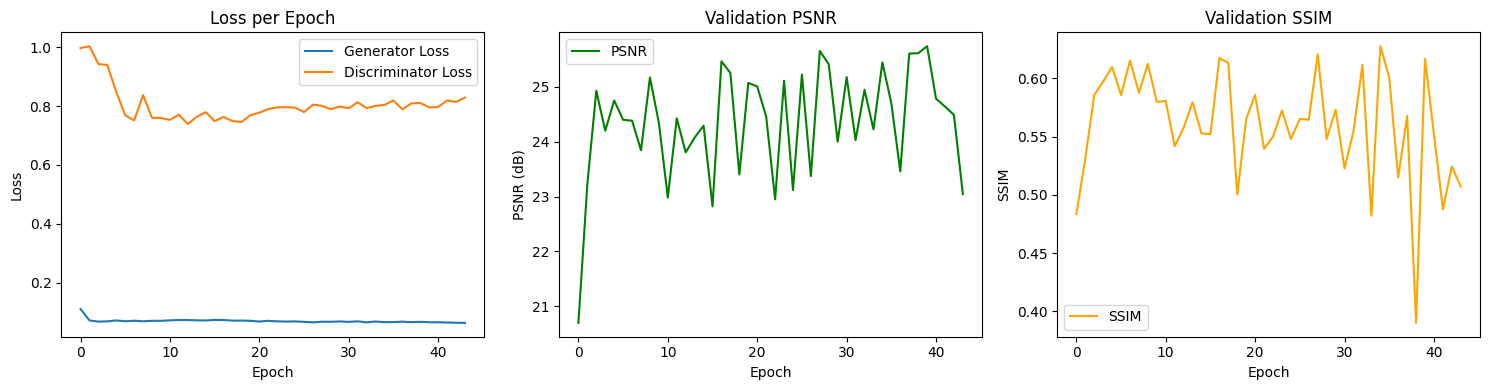

Epoch 45/100 [Validation]: 100%|██████████| 100/100 [00:19<00:00,  5.12it/s, PSNR=25.1, SSIM=0.686]



Epoch 45/100 Summary -- G Loss: 0.0651, D Loss: 0.8408, PSNR: 24.29, SSIM: 0.606


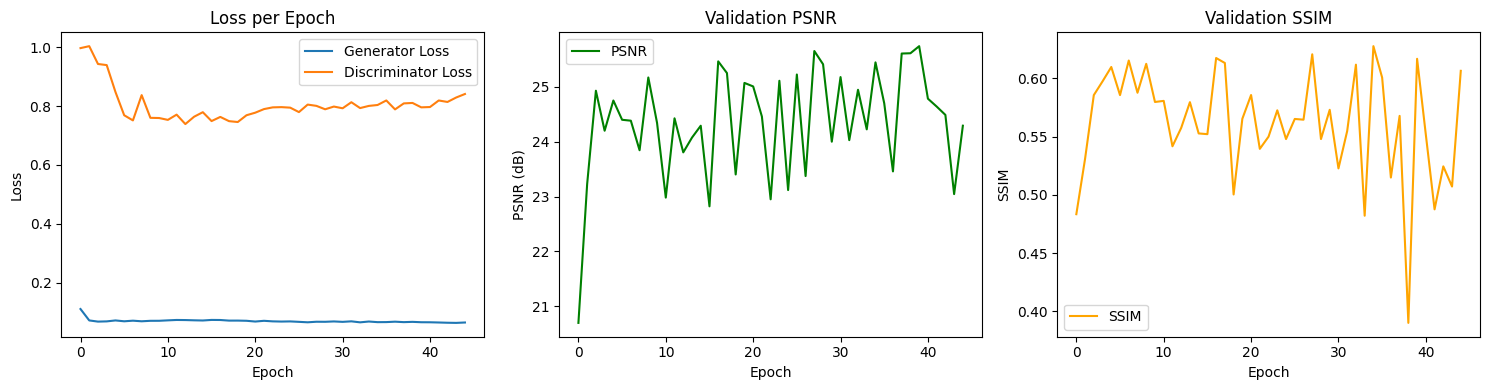

Epoch 46/100 [Validation]: 100%|██████████| 100/100 [00:19<00:00,  5.12it/s, PSNR=17.5, SSIM=0.531]



Epoch 46/100 Summary -- G Loss: 0.0631, D Loss: 0.8331, PSNR: 23.64, SSIM: 0.445


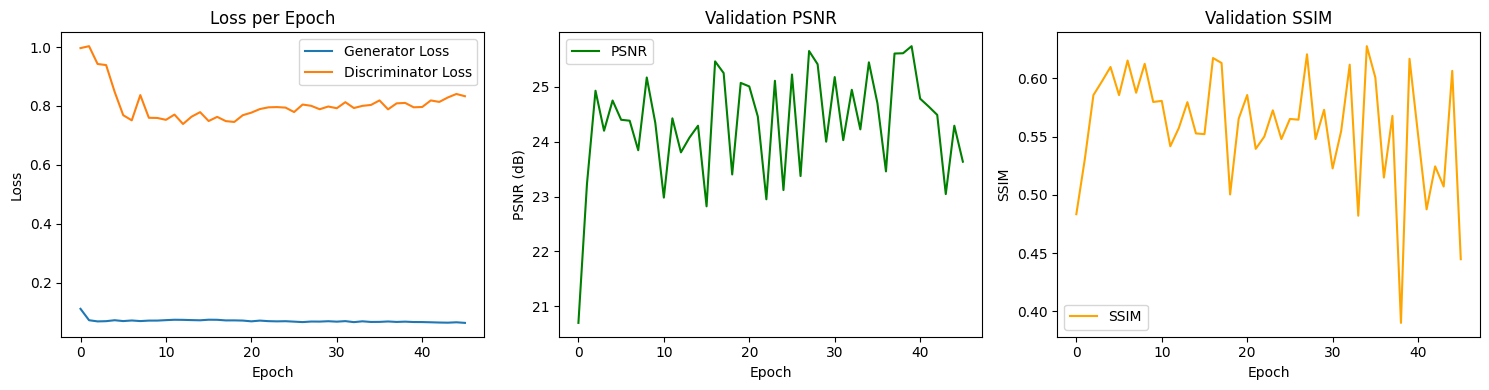

Epoch 47/100 [Validation]: 100%|██████████| 100/100 [00:19<00:00,  5.23it/s, PSNR=24.7, SSIM=0.704]  



Epoch 47/100 Summary -- G Loss: 0.0668, D Loss: 0.8171, PSNR: 25.03, SSIM: 0.590


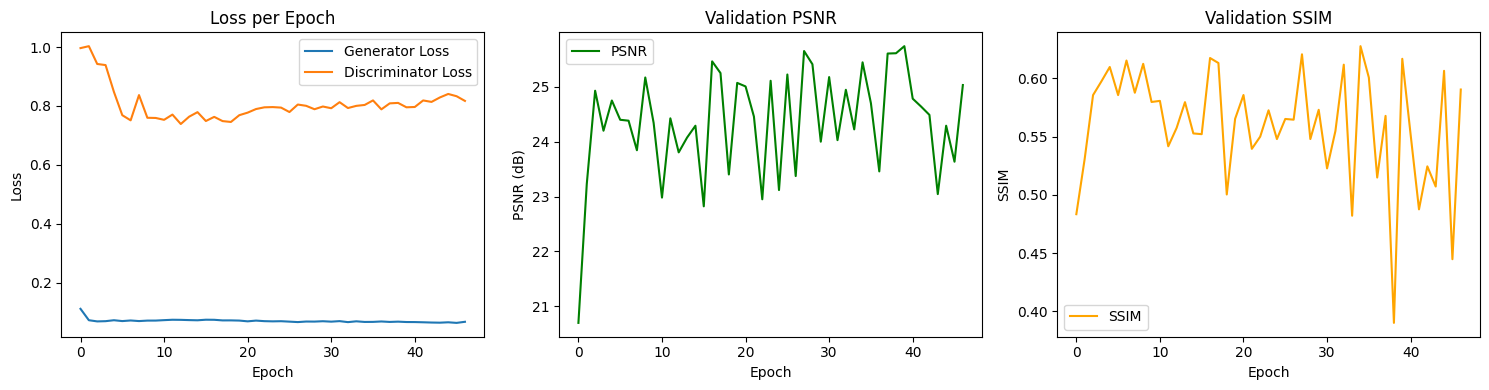

Epoch 48/100 [Validation]: 100%|██████████| 100/100 [00:19<00:00,  5.20it/s, PSNR=23.3, SSIM=0.683]



Epoch 48/100 Summary -- G Loss: 0.0652, D Loss: 0.8037, PSNR: 24.86, SSIM: 0.571


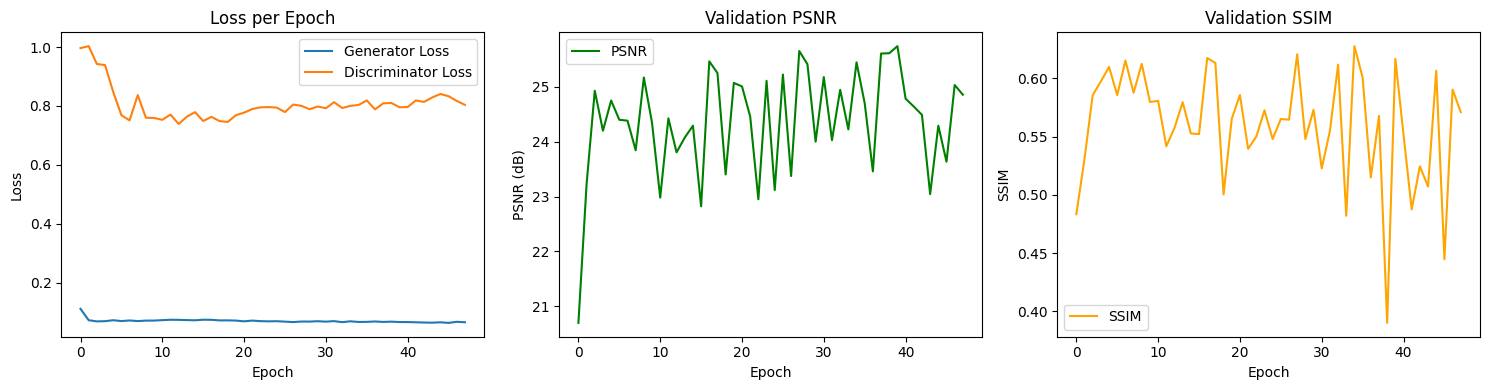

Epoch 49/100 [Validation]: 100%|██████████| 100/100 [00:19<00:00,  5.15it/s, PSNR=24.2, SSIM=0.724]



Epoch 49/100 Summary -- G Loss: 0.0640, D Loss: 0.8163, PSNR: 24.42, SSIM: 0.560


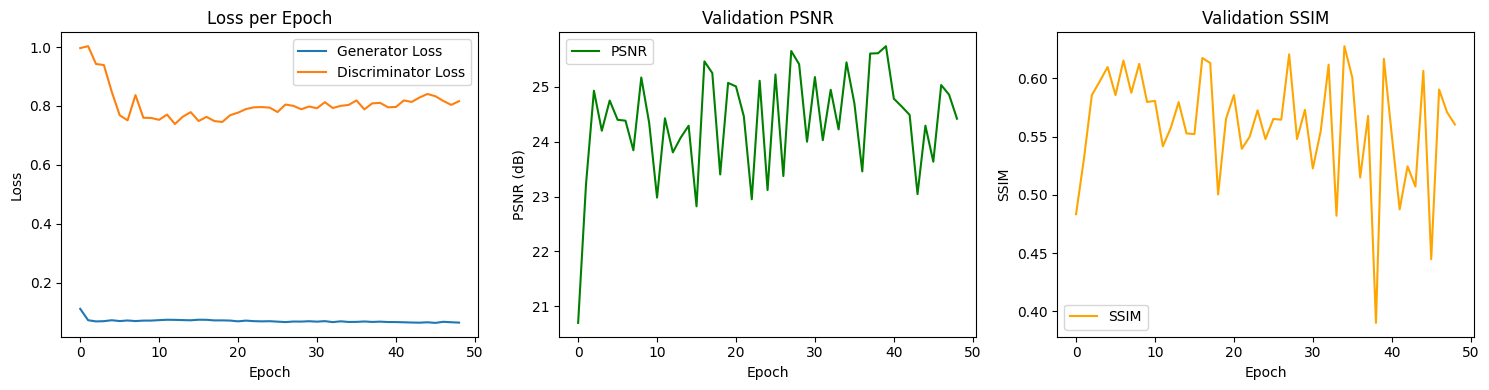

Epoch 50/100 [Validation]: 100%|██████████| 100/100 [00:19<00:00,  5.14it/s, PSNR=19.3, SSIM=0.71] 



Epoch 50/100 Summary -- G Loss: 0.0649, D Loss: 0.8176, PSNR: 25.37, SSIM: 0.560


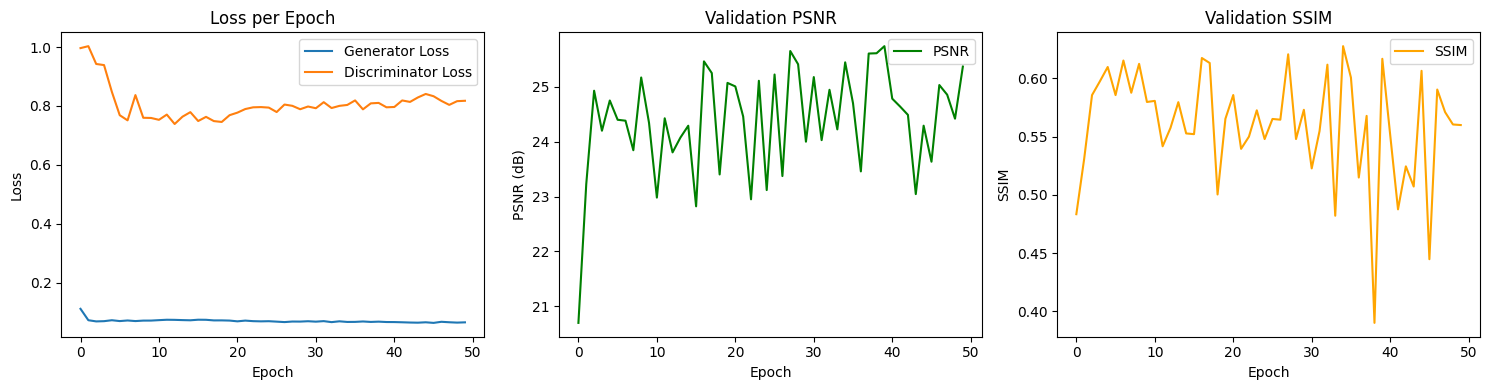

Epoch 51/100 [Validation]: 100%|██████████| 100/100 [00:19<00:00,  5.12it/s, PSNR=30.8, SSIM=nan]  



Epoch 51/100 Summary -- G Loss: 0.0647, D Loss: 0.8239, PSNR: 26.05, SSIM: 0.584


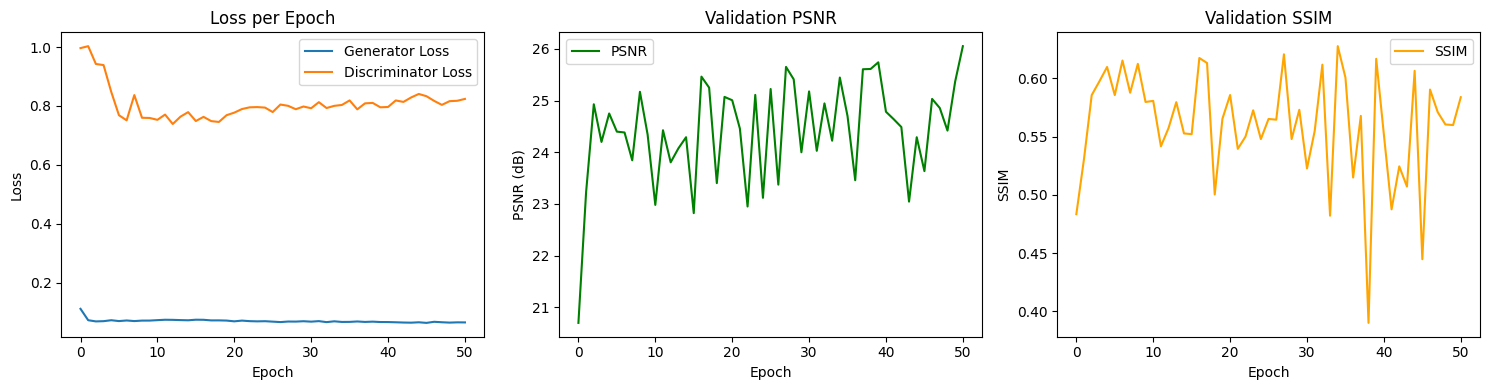

Epoch 52/100 [Validation]: 100%|██████████| 100/100 [00:19<00:00,  5.20it/s, PSNR=23.5, SSIM=0.641]



Epoch 52/100 Summary -- G Loss: 0.0634, D Loss: 0.8381, PSNR: 24.93, SSIM: 0.507


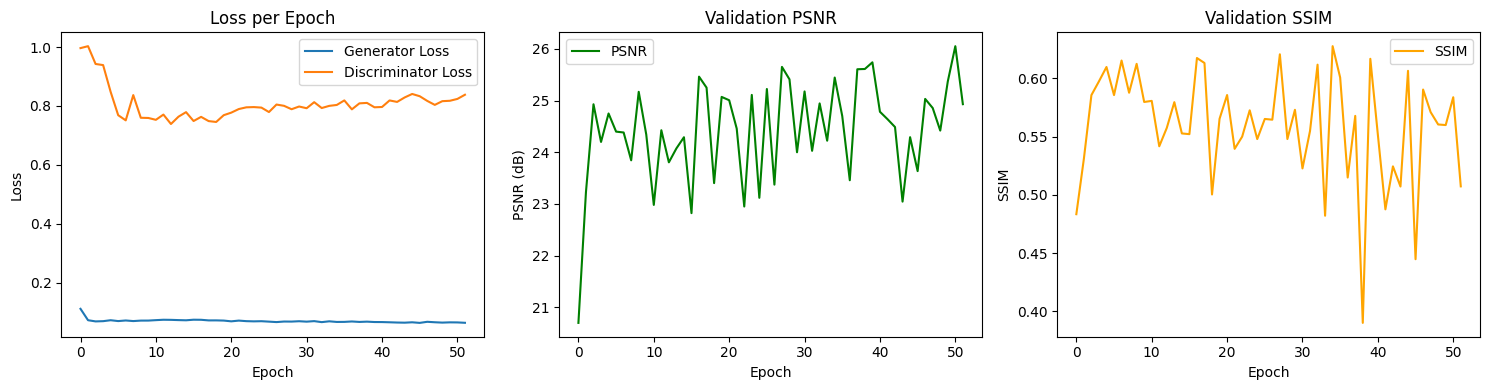

Epoch 53/100 [Validation]: 100%|██████████| 100/100 [00:18<00:00,  5.28it/s, PSNR=24.8, SSIM=0.673]



Epoch 53/100 Summary -- G Loss: 0.0627, D Loss: 0.8327, PSNR: 25.39, SSIM: 0.604


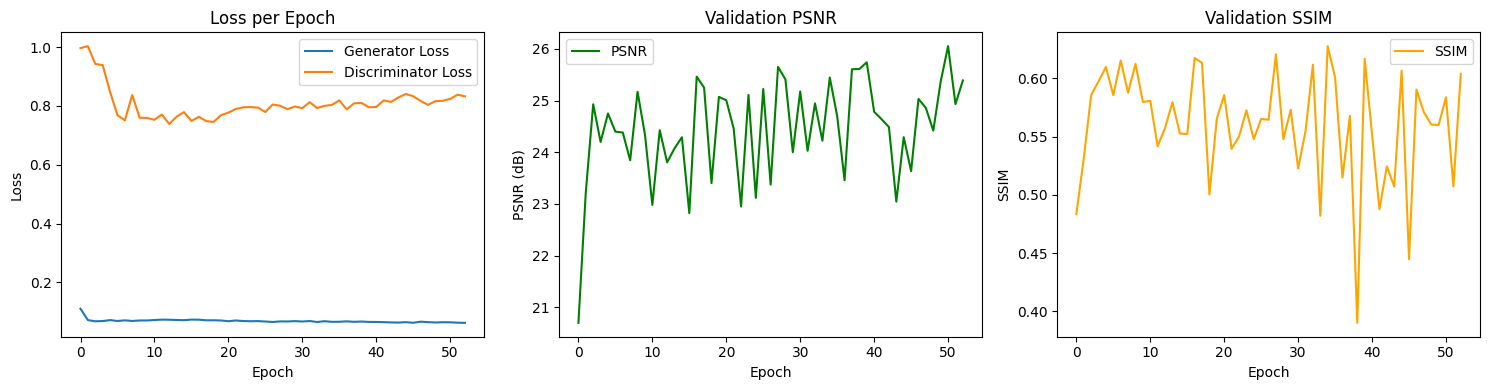

Epoch 54/100 [Validation]: 100%|██████████| 100/100 [00:19<00:00,  5.14it/s, PSNR=21.7, SSIM=0.622]



Epoch 54/100 Summary -- G Loss: 0.0656, D Loss: 0.8090, PSNR: 24.89, SSIM: 0.592


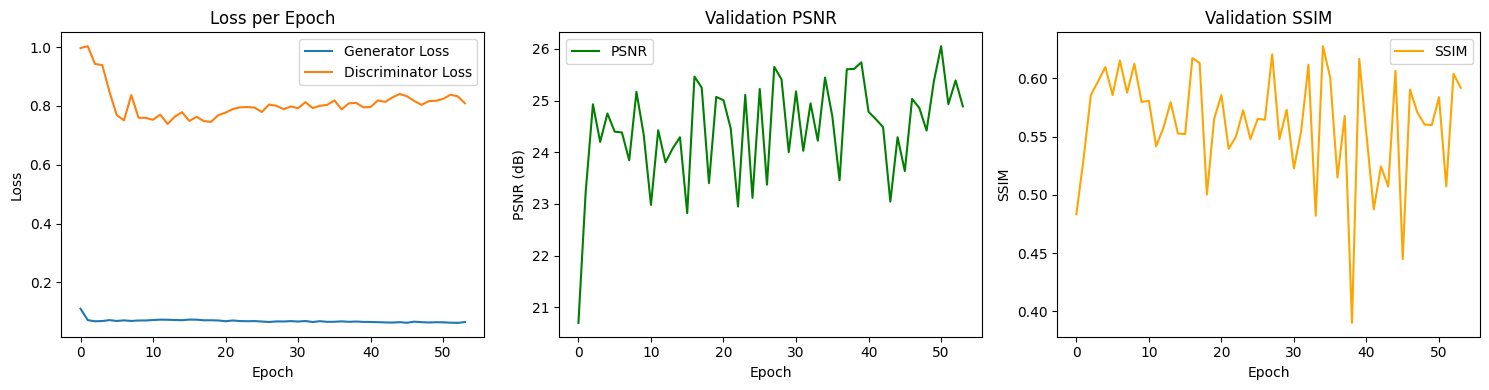

Epoch 55/100 [Validation]: 100%|██████████| 100/100 [00:19<00:00,  5.14it/s, PSNR=30.8, SSIM=0.774] 



Epoch 55/100 Summary -- G Loss: 0.0653, D Loss: 0.8247, PSNR: 24.70, SSIM: 0.544


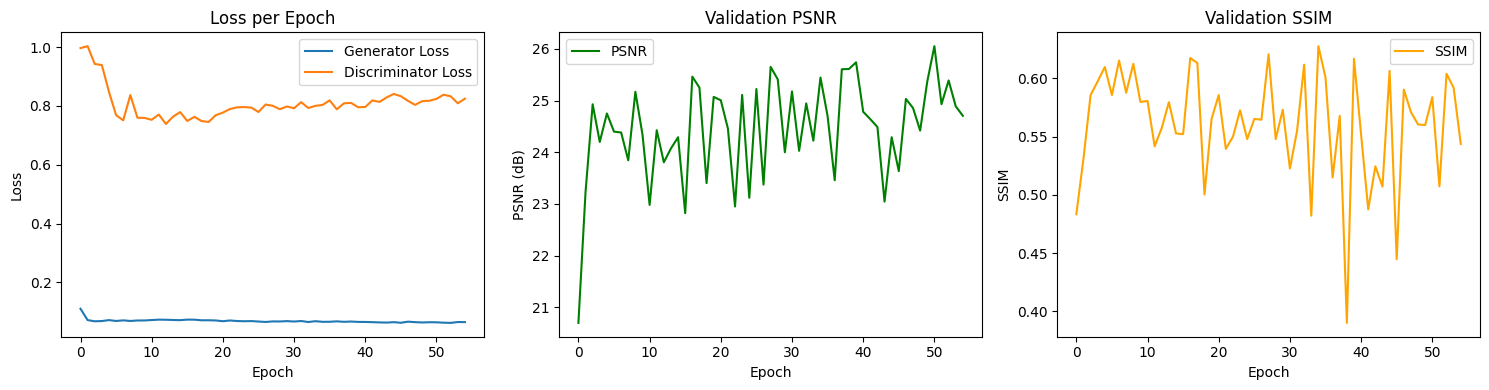

Epoch 56/100 [Validation]: 100%|██████████| 100/100 [00:19<00:00,  5.16it/s, PSNR=24.1, SSIM=0.768]



Epoch 56/100 Summary -- G Loss: 0.0661, D Loss: 0.8141, PSNR: 26.03, SSIM: 0.543


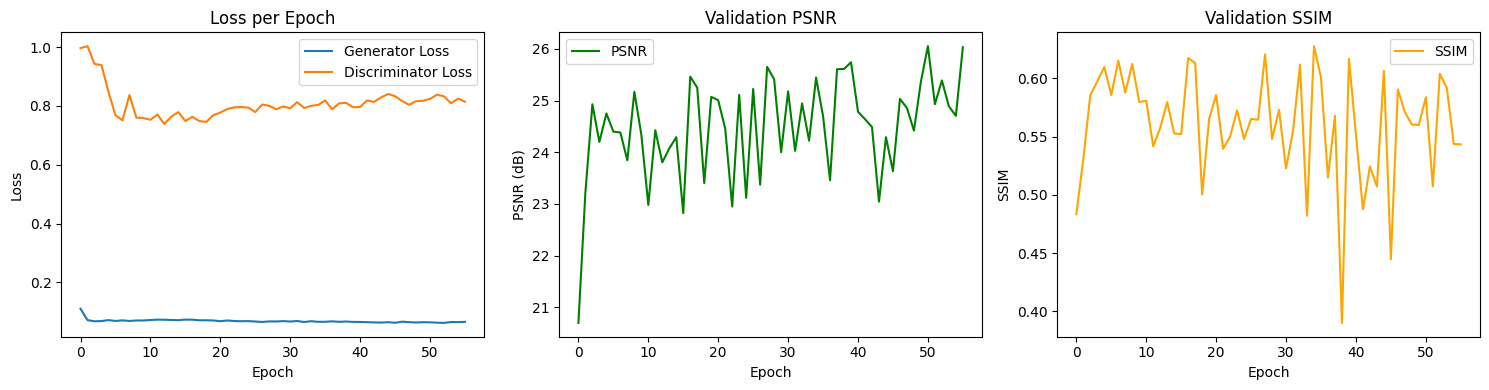

Epoch 57/100 [Validation]: 100%|██████████| 100/100 [00:19<00:00,  5.15it/s, PSNR=27.9, SSIM=0.811] 



Epoch 57/100 Summary -- G Loss: 0.0649, D Loss: 0.8288, PSNR: 24.74, SSIM: 0.577


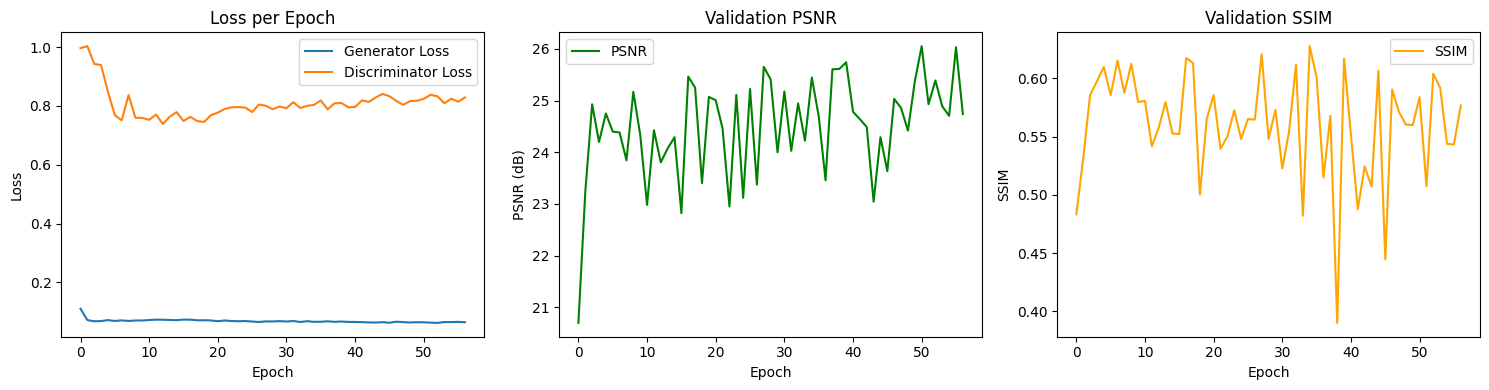

Epoch 58/100 [Validation]: 100%|██████████| 100/100 [00:19<00:00,  5.26it/s, PSNR=30.9, SSIM=0.775]



Epoch 58/100 Summary -- G Loss: 0.0639, D Loss: 0.7961, PSNR: 24.20, SSIM: 0.488


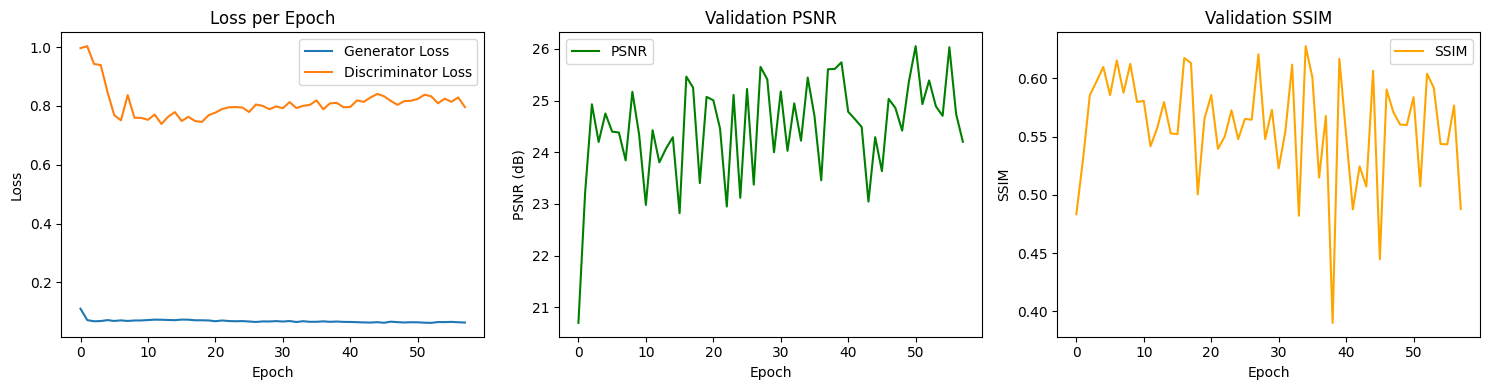

Epoch 59/100 [Validation]: 100%|██████████| 100/100 [00:19<00:00,  5.12it/s, PSNR=22.3, SSIM=0.702]



Epoch 59/100 Summary -- G Loss: 0.0657, D Loss: 0.8300, PSNR: 25.24, SSIM: 0.593


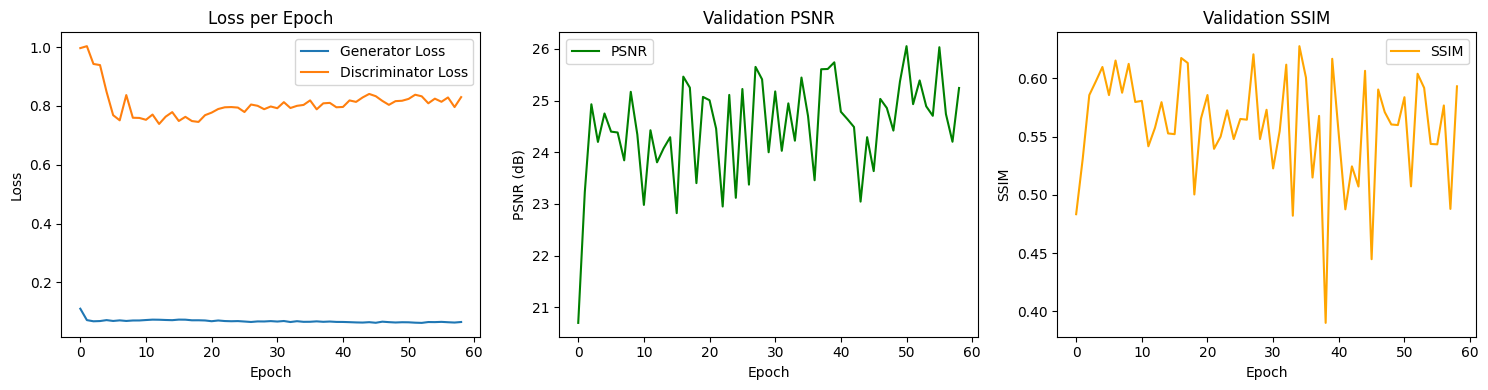

Epoch 60/100 [Validation]: 100%|██████████| 100/100 [00:19<00:00,  5.12it/s, PSNR=24.9, SSIM=0.589]



Epoch 60/100 Summary -- G Loss: 0.0656, D Loss: 0.8057, PSNR: 24.49, SSIM: 0.551


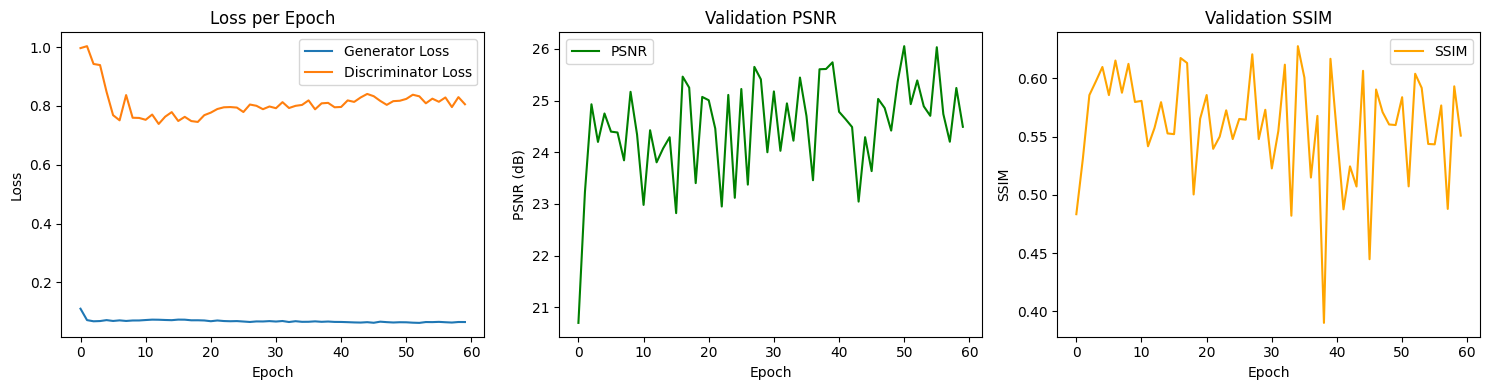

Epoch 61/100 [Validation]: 100%|██████████| 100/100 [00:19<00:00,  5.16it/s, PSNR=26.7, SSIM=0.694]



Epoch 61/100 Summary -- G Loss: 0.0646, D Loss: 0.8400, PSNR: 25.35, SSIM: 0.543


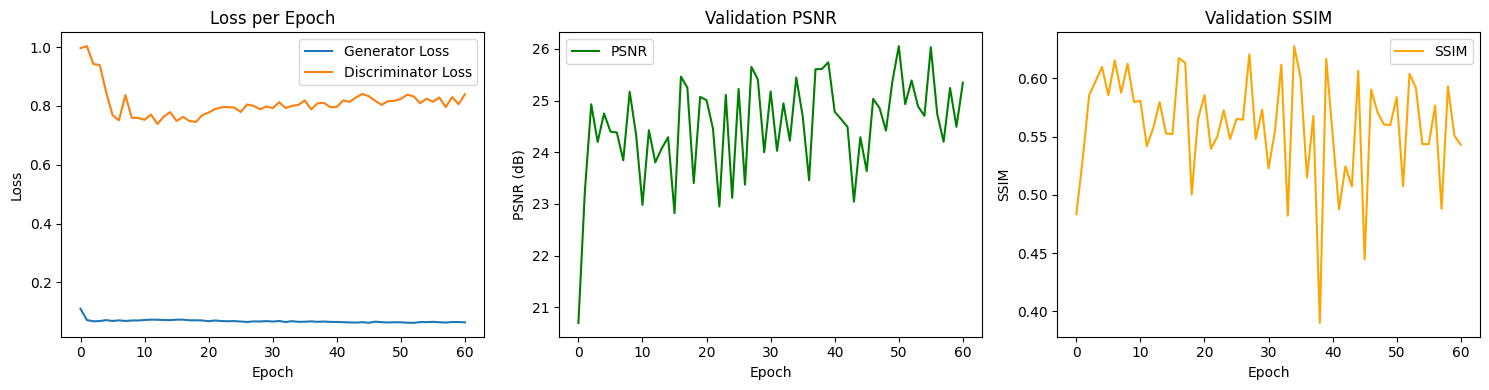

Epoch 62/100 [Validation]: 100%|██████████| 100/100 [00:19<00:00,  5.20it/s, PSNR=23.6, SSIM=0.701] 



Epoch 62/100 Summary -- G Loss: 0.0633, D Loss: 0.8234, PSNR: 24.16, SSIM: 0.423


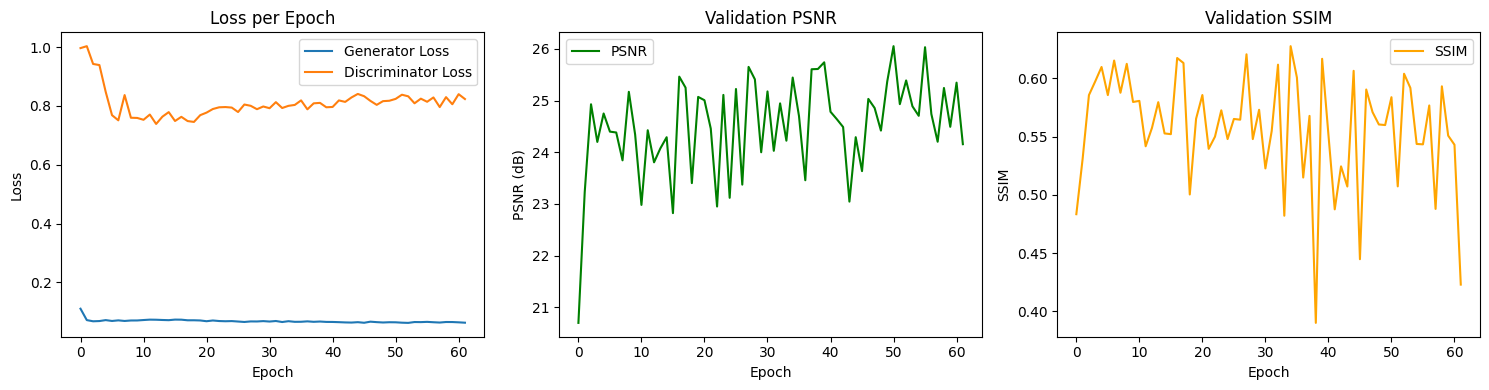

Epoch 63/100 [Validation]: 100%|██████████| 100/100 [00:18<00:00,  5.26it/s, PSNR=22.5, SSIM=0.707]



Epoch 63/100 Summary -- G Loss: 0.0644, D Loss: 0.8304, PSNR: 24.94, SSIM: 0.564


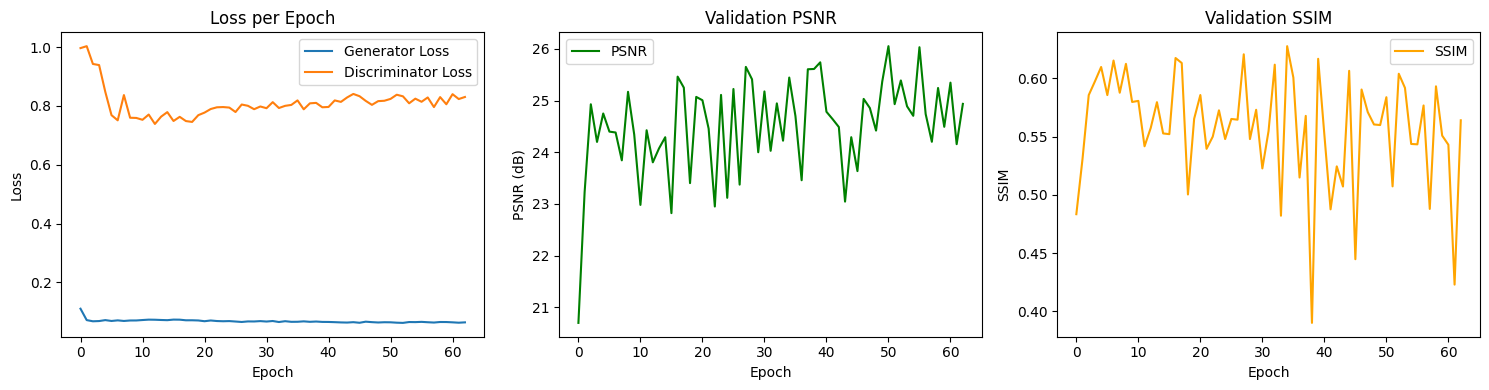

Epoch 64/100 [Validation]: 100%|██████████| 100/100 [00:19<00:00,  5.12it/s, PSNR=26.6, SSIM=0.677]



Epoch 64/100 Summary -- G Loss: 0.0653, D Loss: 0.8235, PSNR: 24.57, SSIM: 0.605


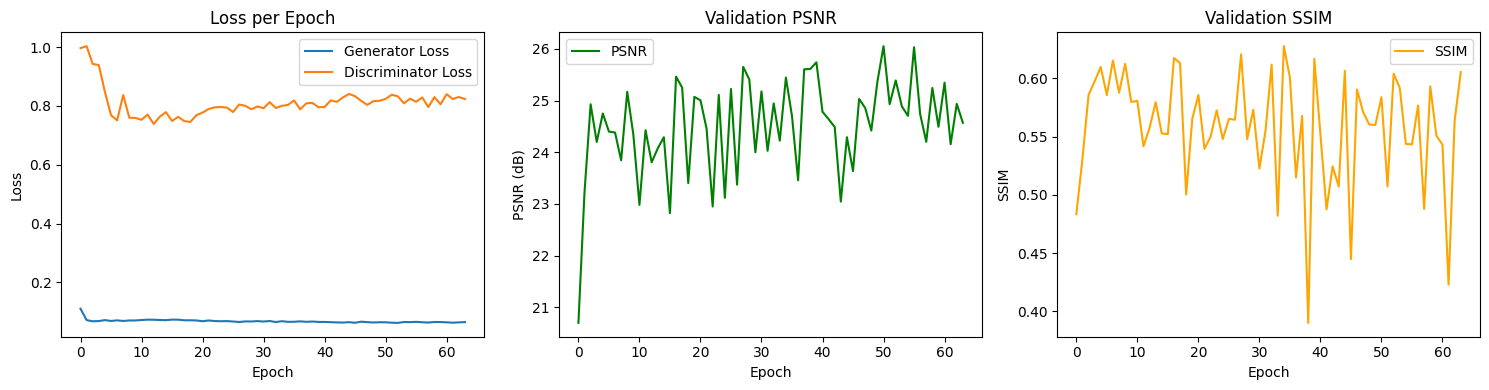

Epoch 65/100 [Validation]: 100%|██████████| 100/100 [00:19<00:00,  5.08it/s, PSNR=19.3, SSIM=0.688]



Epoch 65/100 Summary -- G Loss: 0.0635, D Loss: 0.8347, PSNR: 24.87, SSIM: 0.575


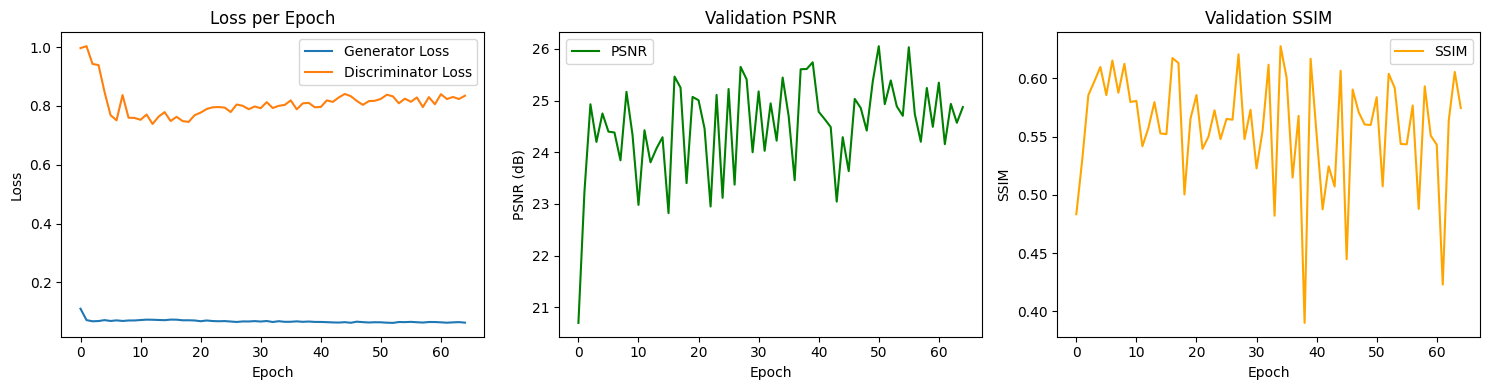

Epoch 66/100 [Validation]: 100%|██████████| 100/100 [00:19<00:00,  5.08it/s, PSNR=24.6, SSIM=0.738]



Epoch 66/100 Summary -- G Loss: 0.0628, D Loss: 0.8278, PSNR: 25.25, SSIM: 0.601


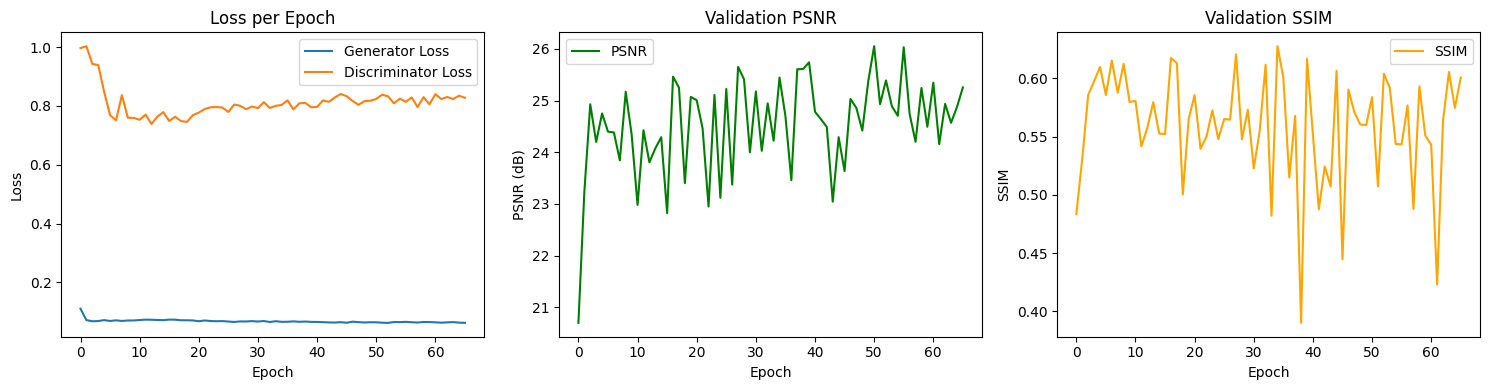

Epoch 67/100 [Validation]: 100%|██████████| 100/100 [00:19<00:00,  5.04it/s, PSNR=24, SSIM=nan]    



Epoch 67/100 Summary -- G Loss: 0.0650, D Loss: 0.8232, PSNR: 24.63, SSIM: 0.487


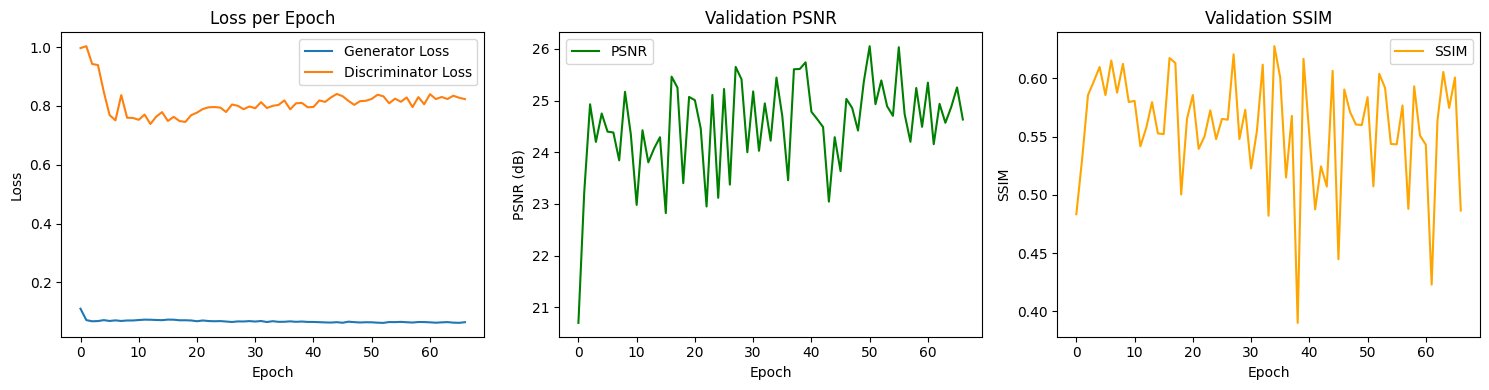

Epoch 68/100 [Validation]: 100%|██████████| 100/100 [00:18<00:00,  5.30it/s, PSNR=20.6, SSIM=0.73]  



Epoch 68/100 Summary -- G Loss: 0.0653, D Loss: 0.8202, PSNR: 26.09, SSIM: 0.453


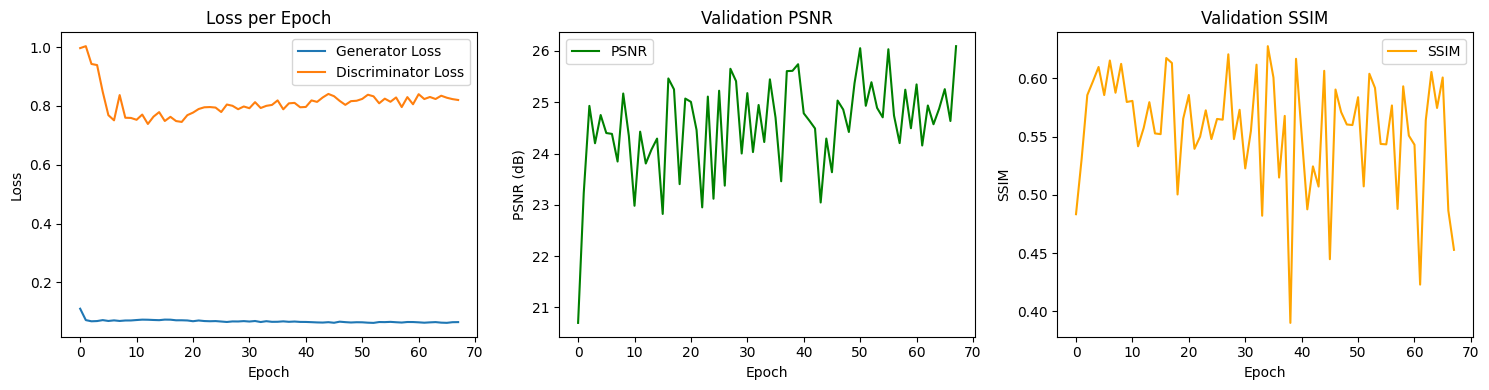

Epoch 69/100 [Validation]: 100%|██████████| 100/100 [00:20<00:00,  4.91it/s, PSNR=27.5, SSIM=0.809]



Epoch 69/100 Summary -- G Loss: 0.0640, D Loss: 0.8105, PSNR: 26.31, SSIM: 0.476


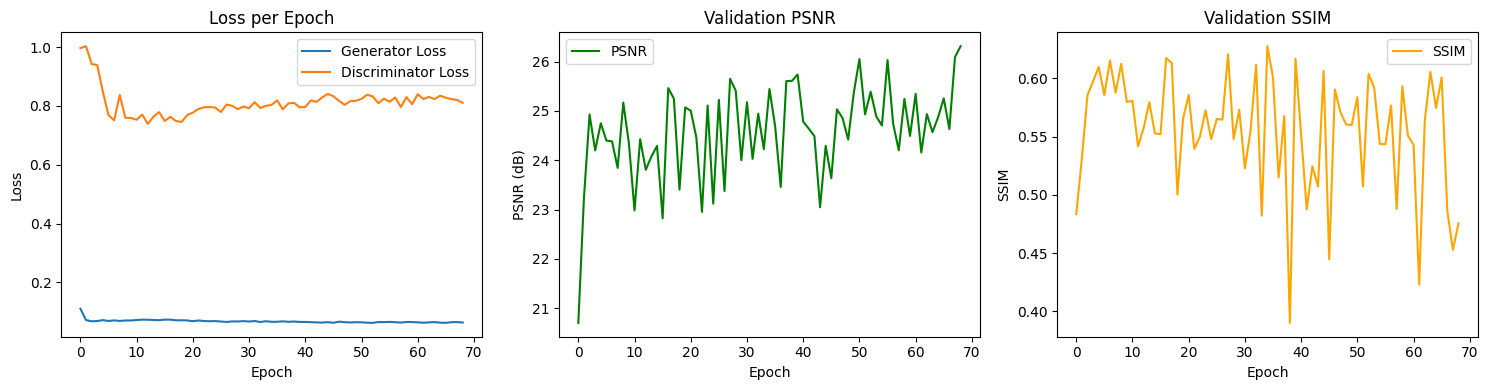

Epoch 70/100 [Validation]: 100%|██████████| 100/100 [00:23<00:00,  4.23it/s, PSNR=26.6, SSIM=0.725]



Epoch 70/100 Summary -- G Loss: 0.0620, D Loss: 0.8367, PSNR: 25.06, SSIM: 0.571


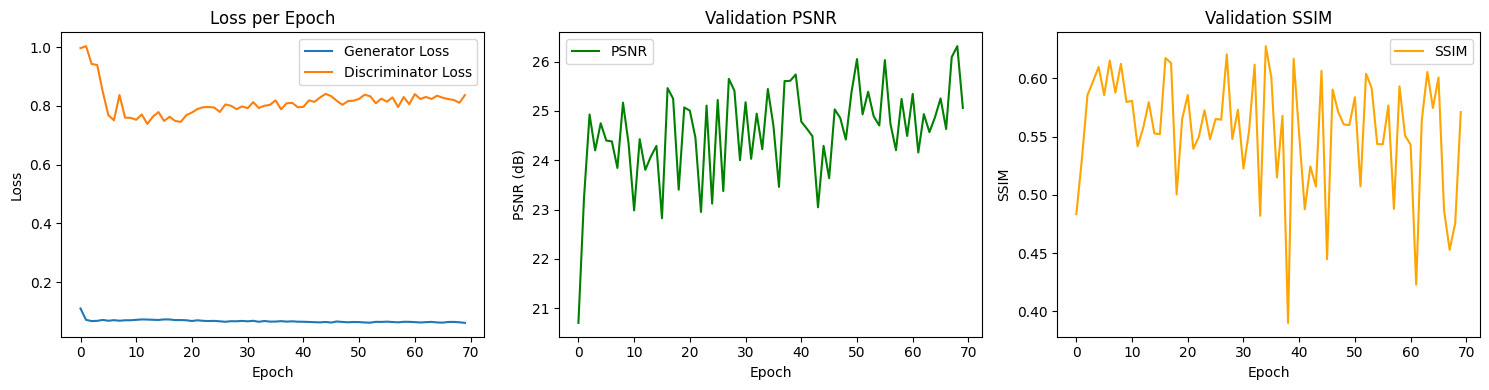

Epoch 71/100 [Validation]: 100%|██████████| 100/100 [00:19<00:00,  5.04it/s, PSNR=23.5, SSIM=0.706]



Epoch 71/100 Summary -- G Loss: 0.0648, D Loss: 0.8166, PSNR: 26.72, SSIM: 0.500


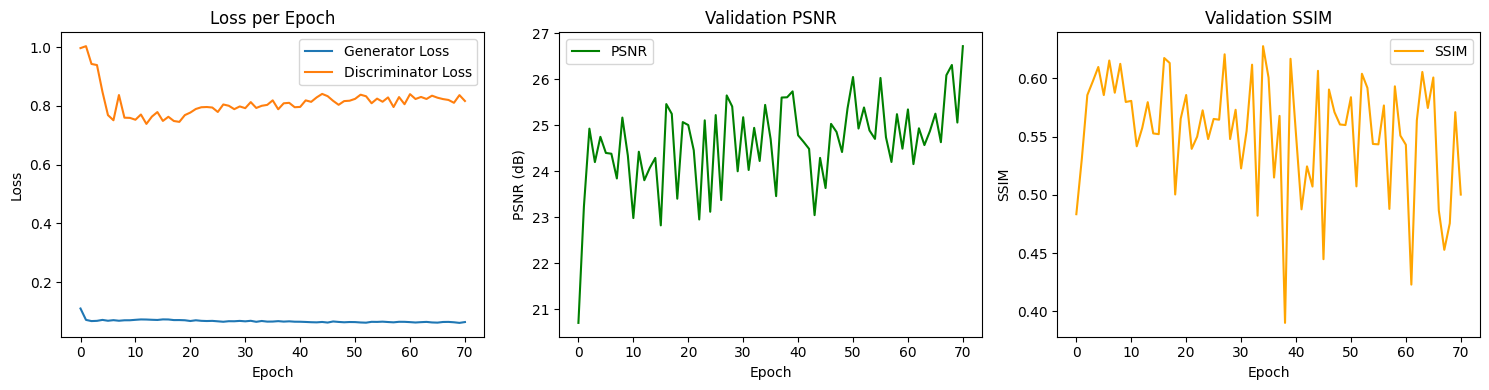

Epoch 72/100 [Validation]: 100%|██████████| 100/100 [00:19<00:00,  5.06it/s, PSNR=17.8, SSIM=0.598]



Epoch 72/100 Summary -- G Loss: 0.0636, D Loss: 0.8231, PSNR: 24.89, SSIM: 0.596


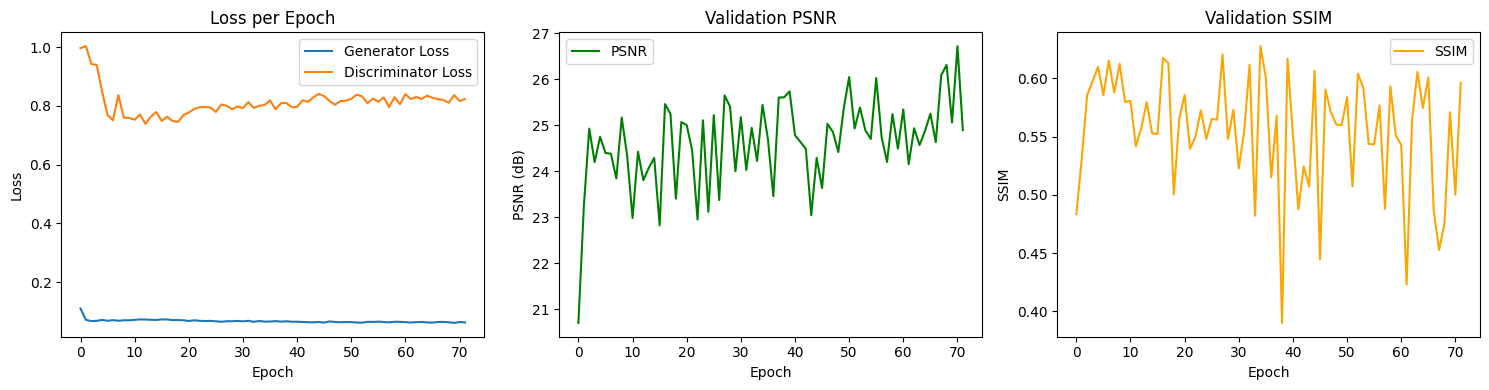

Epoch 73/100 [Validation]: 100%|██████████| 100/100 [00:22<00:00,  4.42it/s, PSNR=17.9, SSIM=0.583]



Epoch 73/100 Summary -- G Loss: 0.0626, D Loss: 0.8185, PSNR: 26.17, SSIM: 0.524


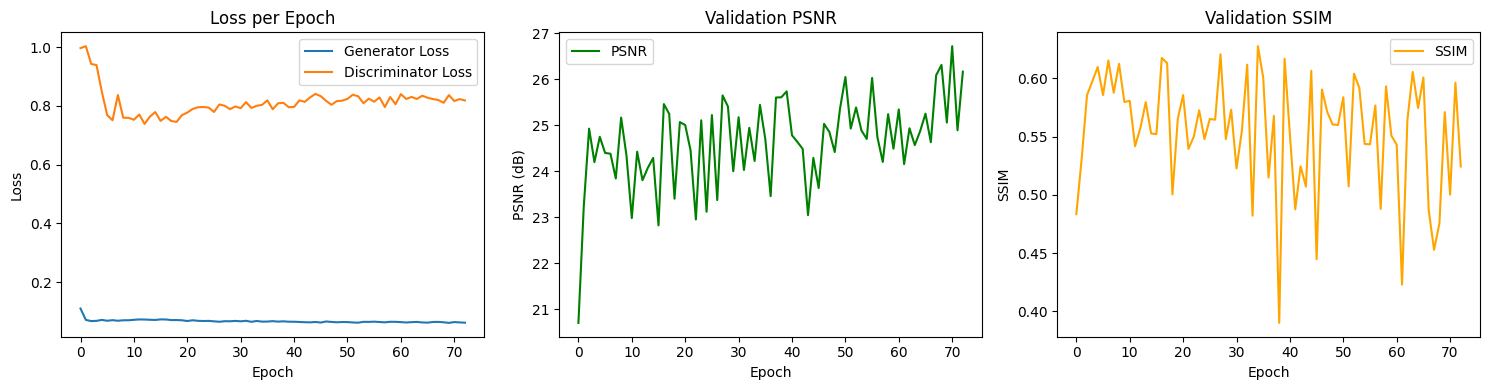

Epoch 74/100 [Validation]: 100%|██████████| 100/100 [00:40<00:00,  2.46it/s, PSNR=22.3, SSIM=0.741]



Epoch 74/100 Summary -- G Loss: 0.0642, D Loss: 0.8115, PSNR: 23.30, SSIM: 0.509


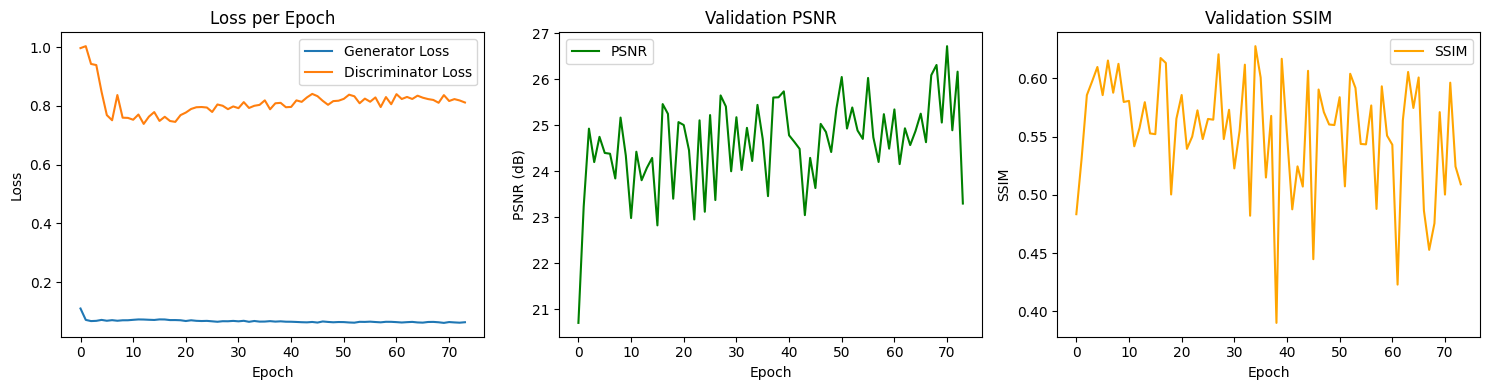

Epoch 75/100 [Validation]: 100%|██████████| 100/100 [00:19<00:00,  5.02it/s, PSNR=25.6, SSIM=0.677]



Epoch 75/100 Summary -- G Loss: 0.0653, D Loss: 0.8255, PSNR: 26.55, SSIM: 0.580


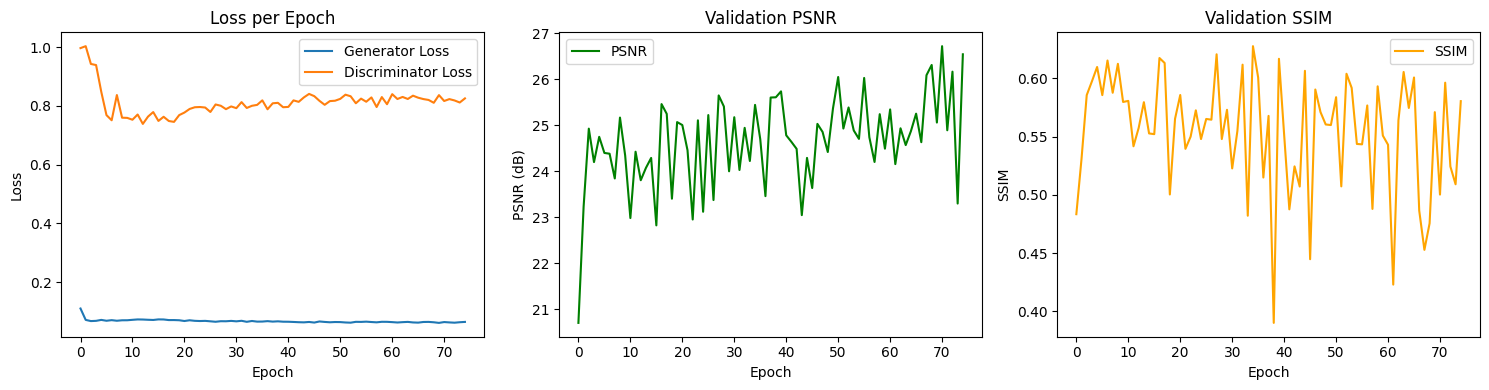

Epoch 76/100 [Validation]: 100%|██████████| 100/100 [00:19<00:00,  5.00it/s, PSNR=24.8, SSIM=0.606]



Epoch 76/100 Summary -- G Loss: 0.0621, D Loss: 0.8352, PSNR: 25.01, SSIM: 0.567


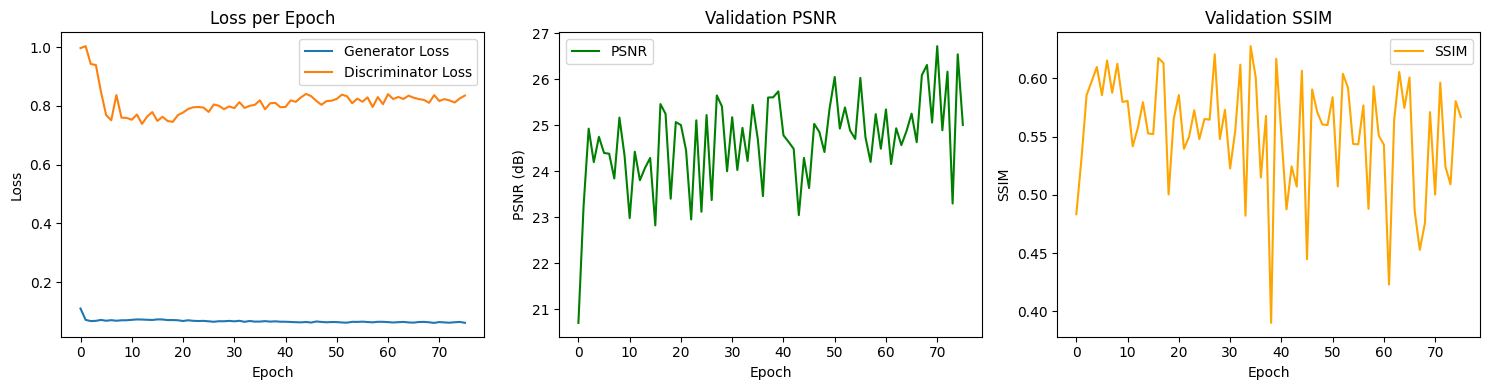

Epoch 77/100 [Validation]: 100%|██████████| 100/100 [00:20<00:00,  4.95it/s, PSNR=26.7, SSIM=0.782]



Epoch 77/100 Summary -- G Loss: 0.0648, D Loss: 0.8169, PSNR: 24.14, SSIM: 0.566


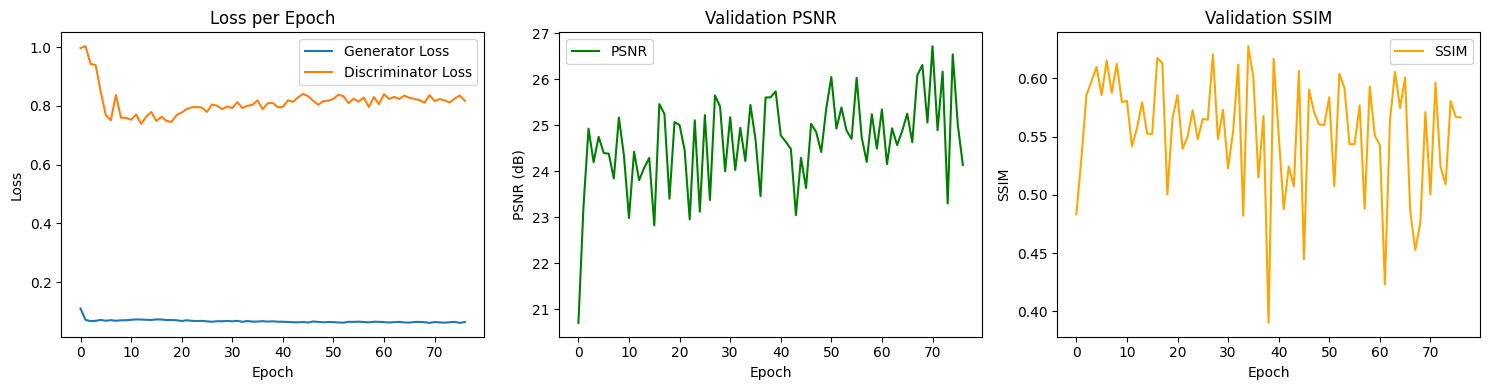

Epoch 78/100 [Validation]: 100%|██████████| 100/100 [00:19<00:00,  5.02it/s, PSNR=25, SSIM=0.708]    



Epoch 78/100 Summary -- G Loss: 0.0632, D Loss: 0.8360, PSNR: 24.22, SSIM: 0.538


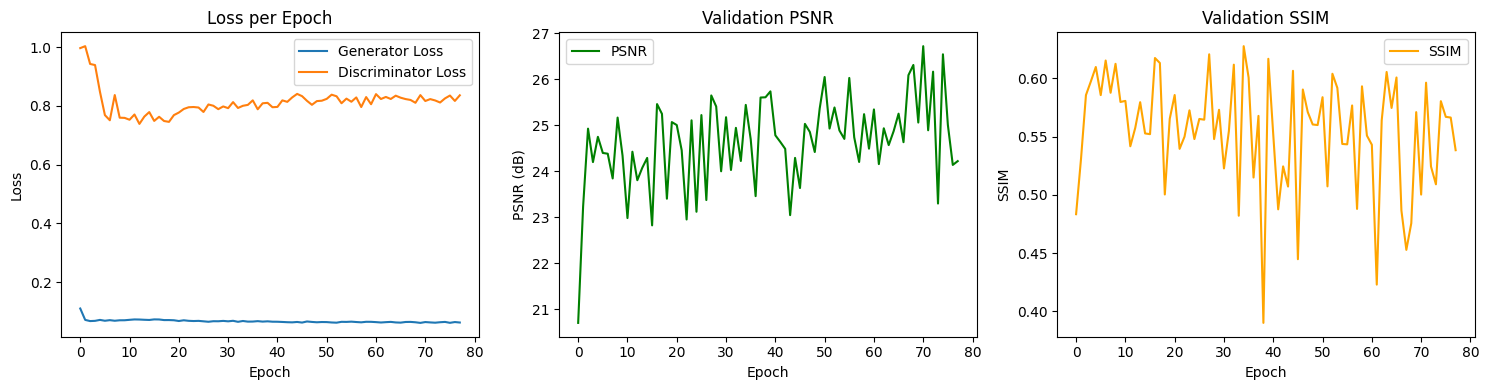

Epoch 79/100 [Validation]: 100%|██████████| 100/100 [00:19<00:00,  5.05it/s, PSNR=24.5, SSIM=0.665]



Epoch 79/100 Summary -- G Loss: 0.0637, D Loss: 0.8075, PSNR: 25.84, SSIM: 0.564


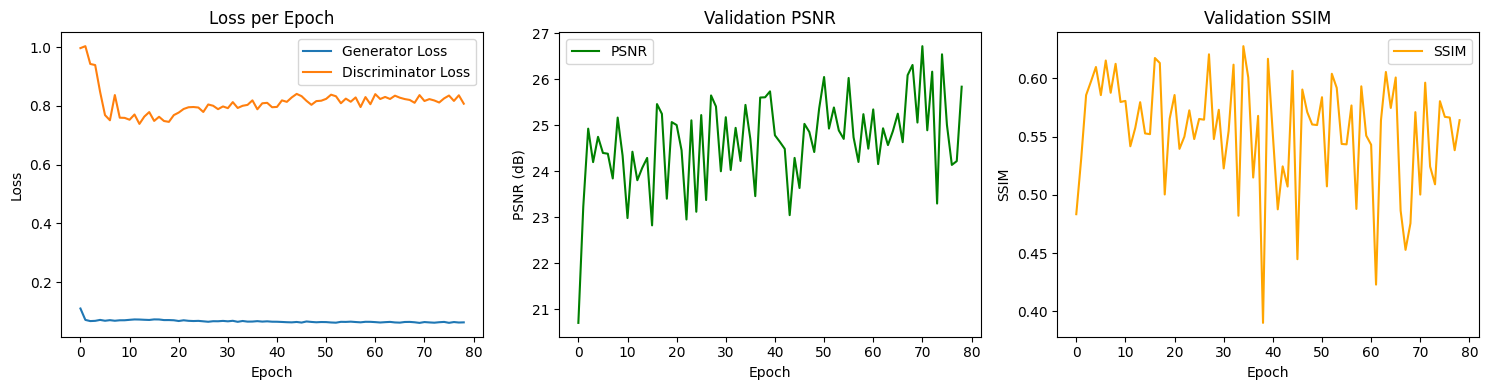

Epoch 80/100 [Validation]: 100%|██████████| 100/100 [00:20<00:00,  4.91it/s, PSNR=22.7, SSIM=0.693] 



Epoch 80/100 Summary -- G Loss: 0.0637, D Loss: 0.8127, PSNR: 24.12, SSIM: 0.569


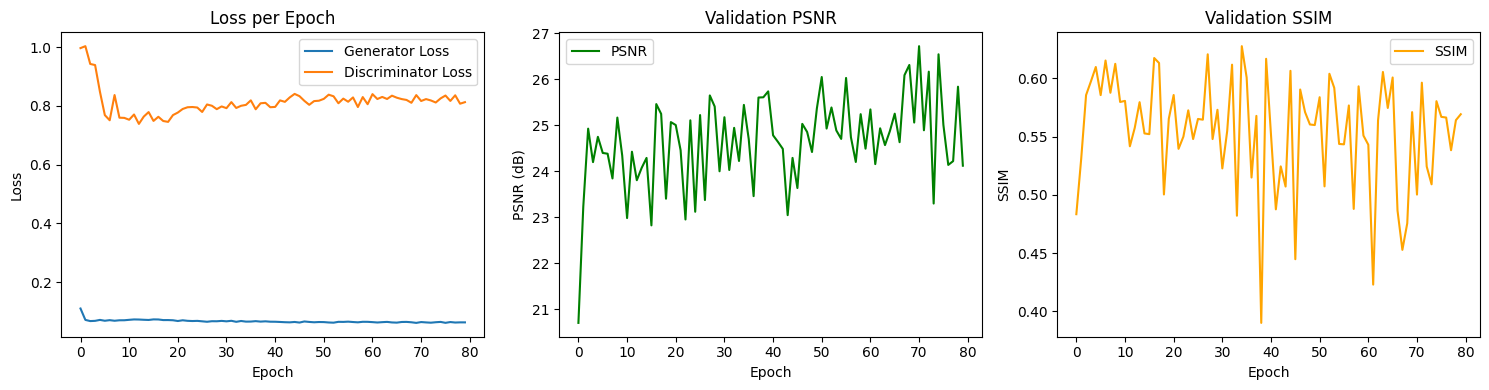

Epoch 81/100 [Validation]: 100%|██████████| 100/100 [00:20<00:00,  4.92it/s, PSNR=20.2, SSIM=0.658] 



Epoch 81/100 Summary -- G Loss: 0.0641, D Loss: 0.8014, PSNR: 24.63, SSIM: 0.596


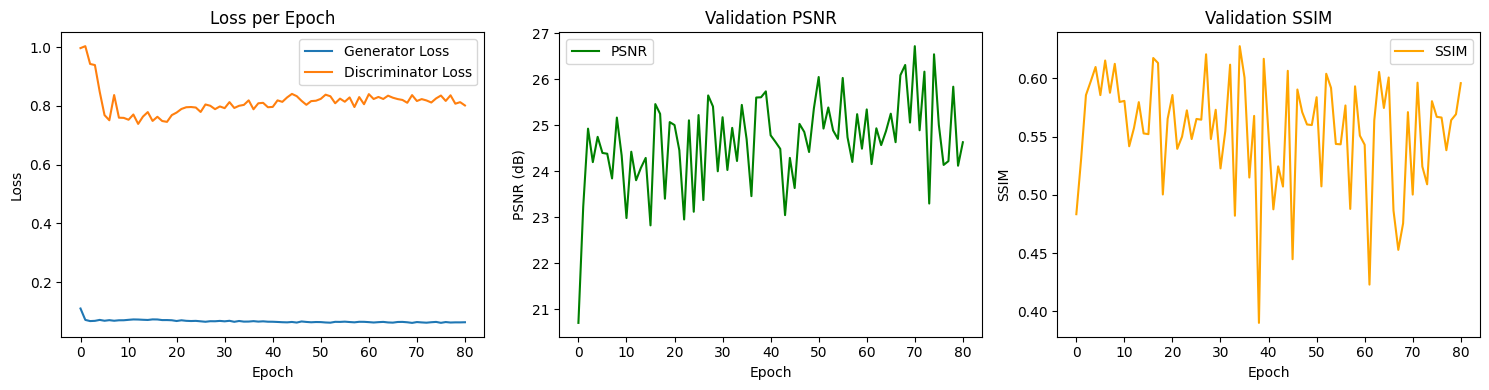

Epoch 82/100 [Validation]: 100%|██████████| 100/100 [00:20<00:00,  4.98it/s, PSNR=24.6, SSIM=0.73] 



Epoch 82/100 Summary -- G Loss: 0.0635, D Loss: 0.8281, PSNR: 23.82, SSIM: 0.588


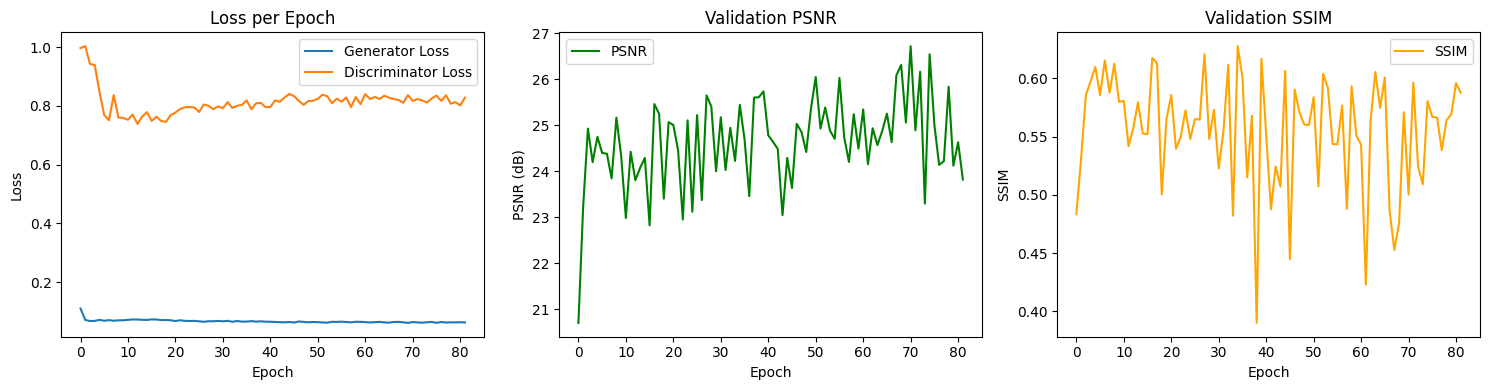

Epoch 83/100 [Validation]: 100%|██████████| 100/100 [00:19<00:00,  5.08it/s, PSNR=28.3, SSIM=0.807]



Epoch 83/100 Summary -- G Loss: 0.0632, D Loss: 0.8303, PSNR: 26.23, SSIM: 0.618


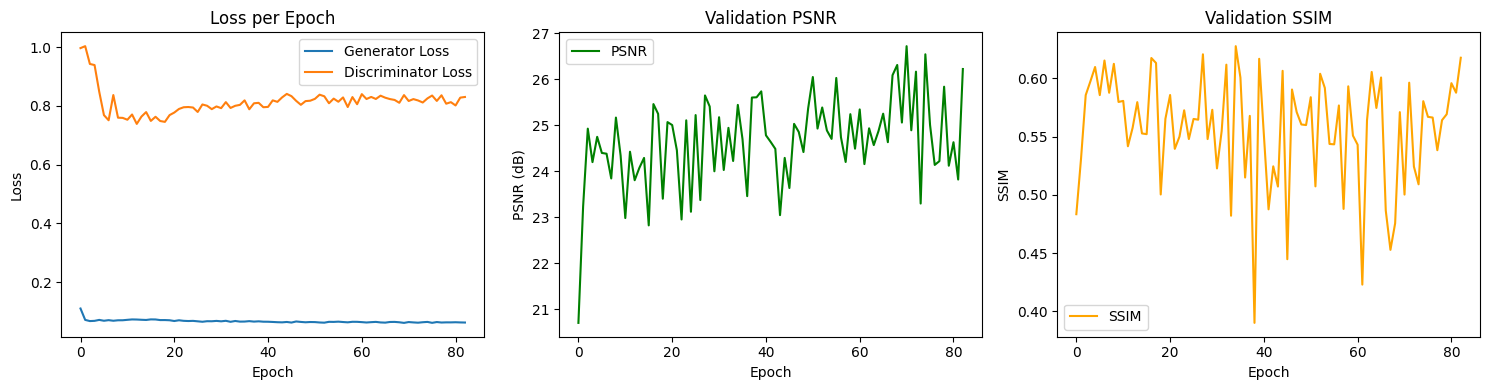

Epoch 84/100 [Validation]: 100%|██████████| 100/100 [00:19<00:00,  5.02it/s, PSNR=26.1, SSIM=0.699]



Epoch 84/100 Summary -- G Loss: 0.0623, D Loss: 0.8526, PSNR: 25.77, SSIM: 0.546


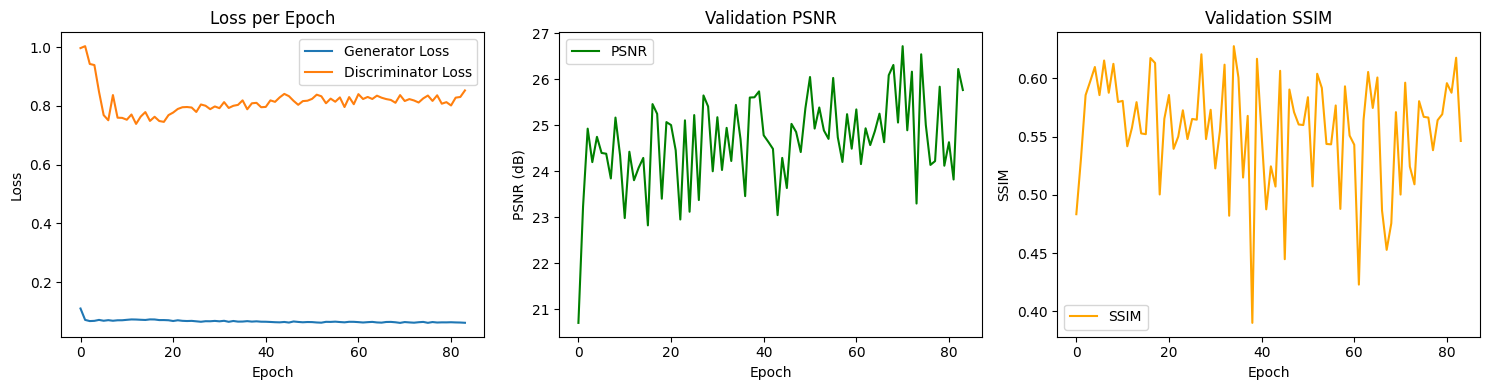

Epoch 85/100 [Validation]: 100%|██████████| 100/100 [00:20<00:00,  4.96it/s, PSNR=22.4, SSIM=0.707]



Epoch 85/100 Summary -- G Loss: 0.0645, D Loss: 0.8121, PSNR: 26.63, SSIM: 0.615


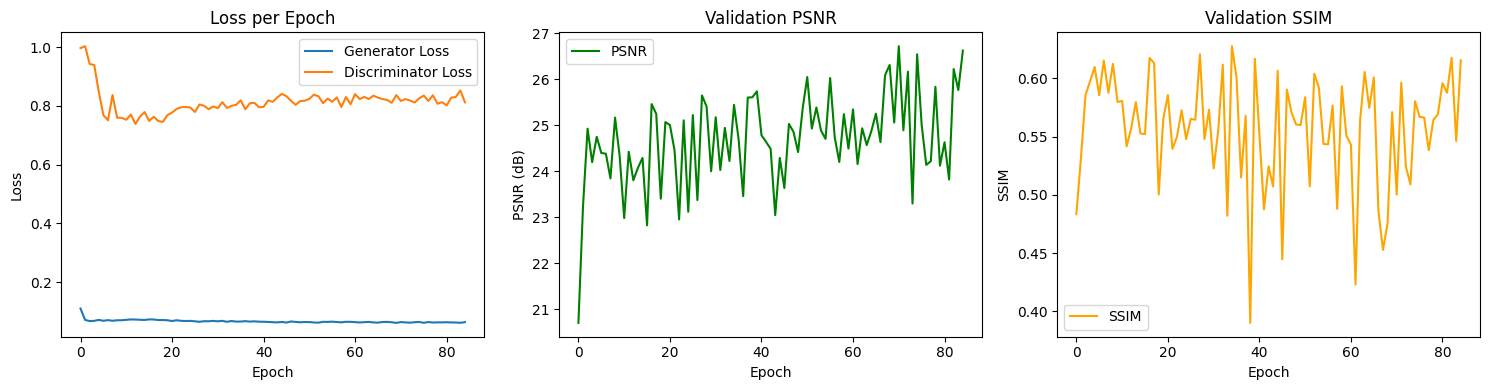

Epoch 86/100 [Validation]: 100%|██████████| 100/100 [00:20<00:00,  4.94it/s, PSNR=25.1, SSIM=0.673]



Epoch 86/100 Summary -- G Loss: 0.0639, D Loss: 0.8117, PSNR: 24.75, SSIM: 0.614


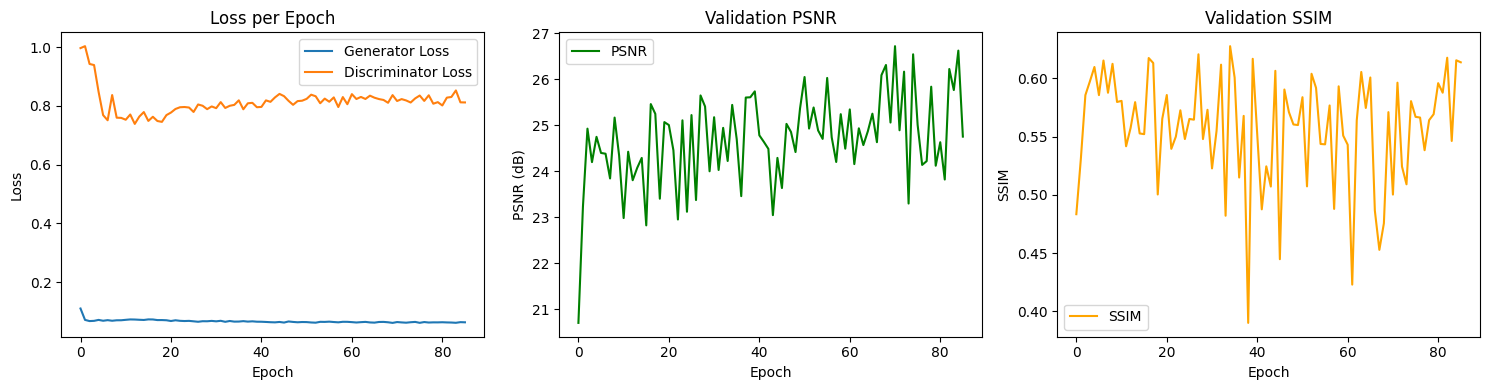

Epoch 87/100 [Validation]: 100%|██████████| 100/100 [00:20<00:00,  4.99it/s, PSNR=30.8, SSIM=0.825]



Epoch 87/100 Summary -- G Loss: 0.0647, D Loss: 0.8138, PSNR: 24.35, SSIM: 0.454


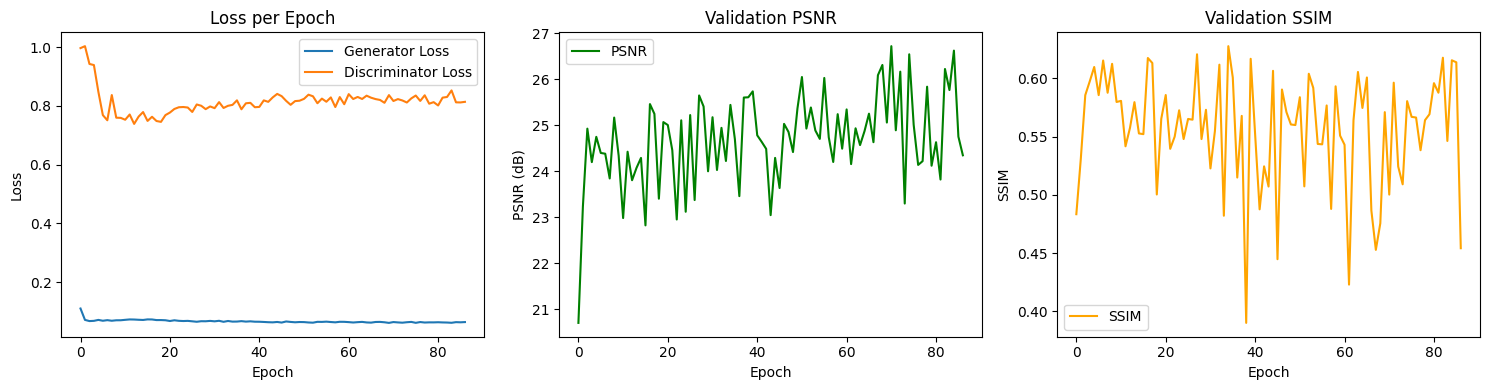

Epoch 88/100 [Validation]: 100%|██████████| 100/100 [00:19<00:00,  5.13it/s, PSNR=23.9, SSIM=0.725]



Epoch 88/100 Summary -- G Loss: 0.0625, D Loss: 0.8322, PSNR: 25.84, SSIM: 0.567


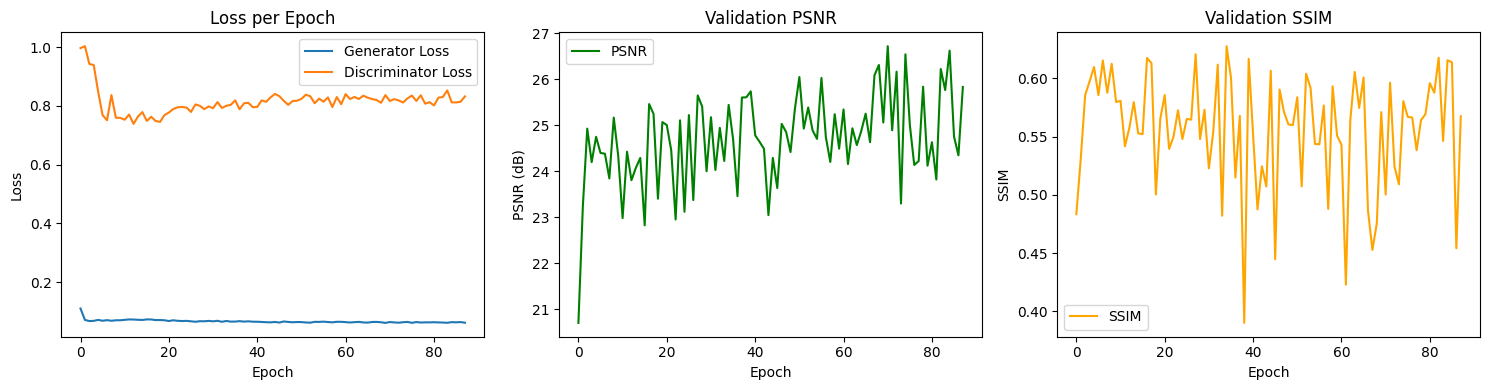

Epoch 89/100 [Validation]: 100%|██████████| 100/100 [00:19<00:00,  5.07it/s, PSNR=24.6, SSIM=0.63] 



Epoch 89/100 Summary -- G Loss: 0.0644, D Loss: 0.8041, PSNR: 23.90, SSIM: 0.517


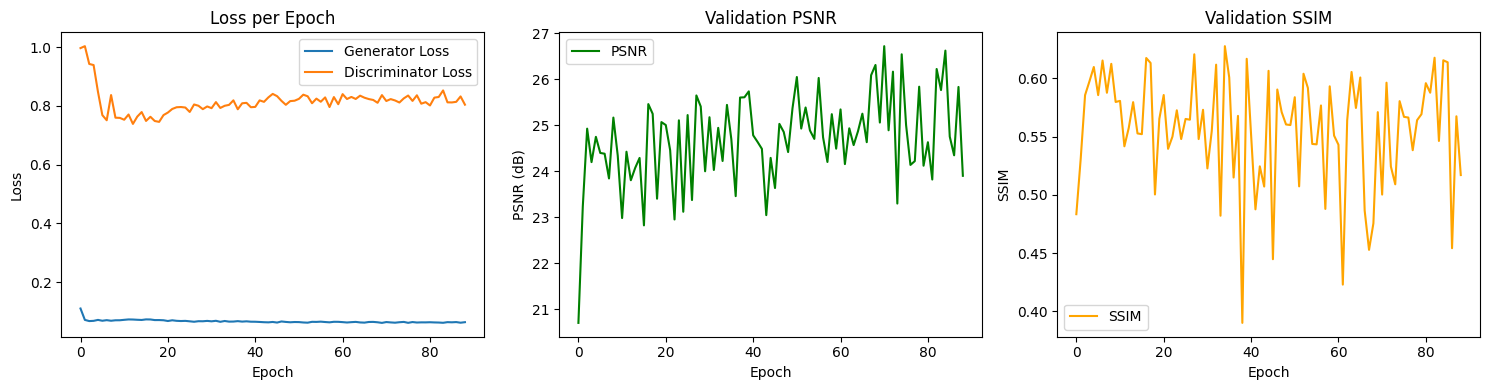

Epoch 90/100 [Validation]: 100%|██████████| 100/100 [00:20<00:00,  4.95it/s, PSNR=25.9, SSIM=0.766]



Epoch 90/100 Summary -- G Loss: 0.0626, D Loss: 0.8369, PSNR: 26.64, SSIM: 0.560


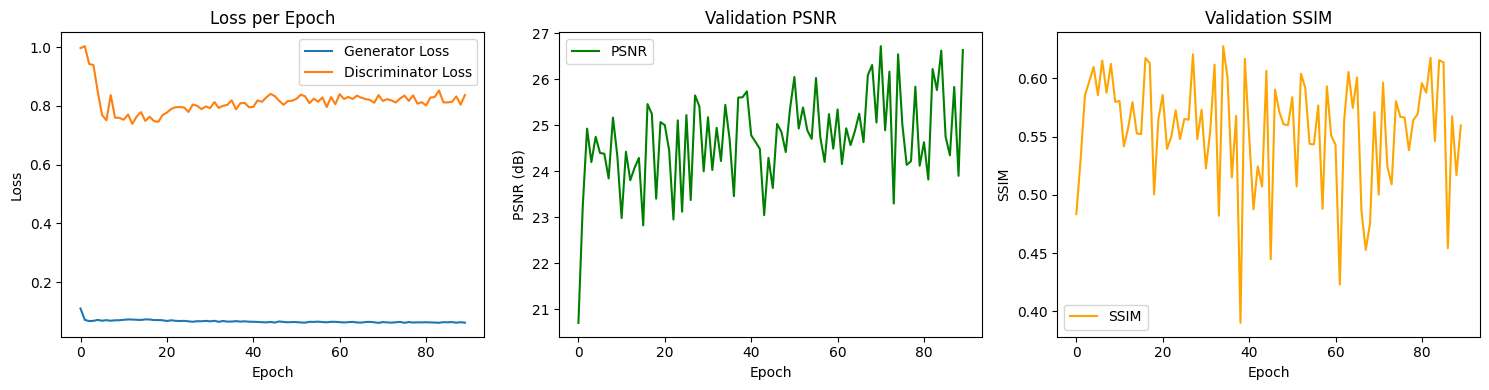

Epoch 91/100 [Validation]: 100%|██████████| 100/100 [00:19<00:00,  5.05it/s, PSNR=26.9, SSIM=0.704]



Epoch 91/100 Summary -- G Loss: 0.0648, D Loss: 0.8359, PSNR: 24.58, SSIM: 0.514


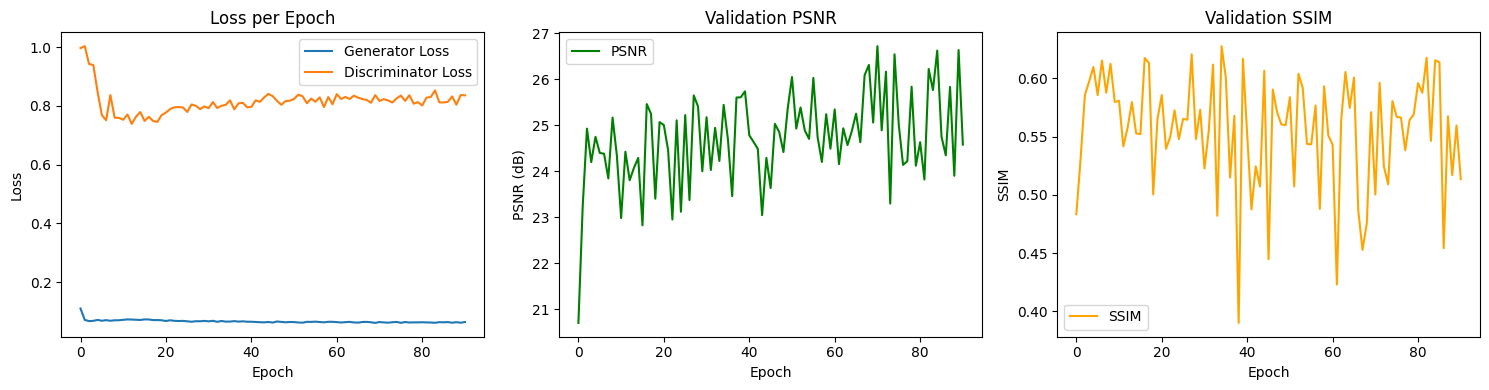

Epoch 92/100 [Validation]: 100%|██████████| 100/100 [00:19<00:00,  5.20it/s, PSNR=27.9, SSIM=0.825]



Epoch 92/100 Summary -- G Loss: 0.0616, D Loss: 0.8353, PSNR: 25.57, SSIM: 0.587


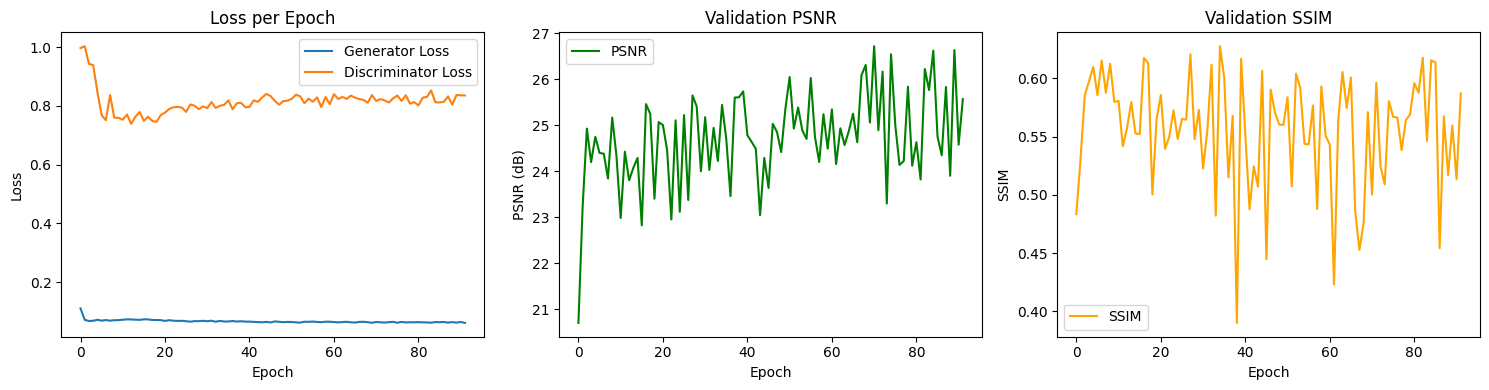

Epoch 93/100 [Validation]: 100%|██████████| 100/100 [00:19<00:00,  5.16it/s, PSNR=19.2, SSIM=0.715]



Epoch 93/100 Summary -- G Loss: 0.0622, D Loss: 0.8391, PSNR: 25.77, SSIM: 0.616


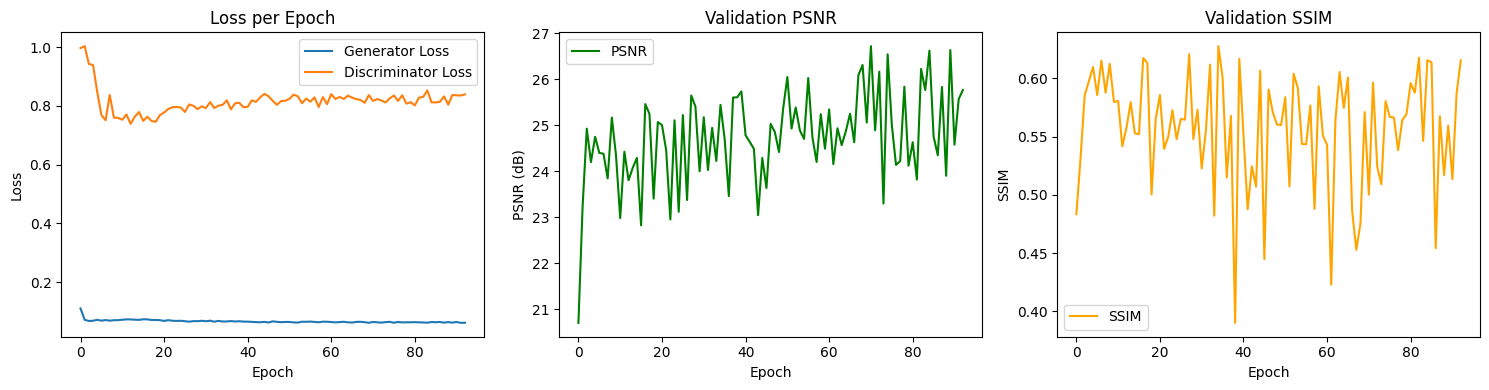

Epoch 94/100 [Validation]: 100%|██████████| 100/100 [00:19<00:00,  5.03it/s, PSNR=19.3, SSIM=0.719]



Epoch 94/100 Summary -- G Loss: 0.0617, D Loss: 0.8230, PSNR: 25.53, SSIM: 0.639


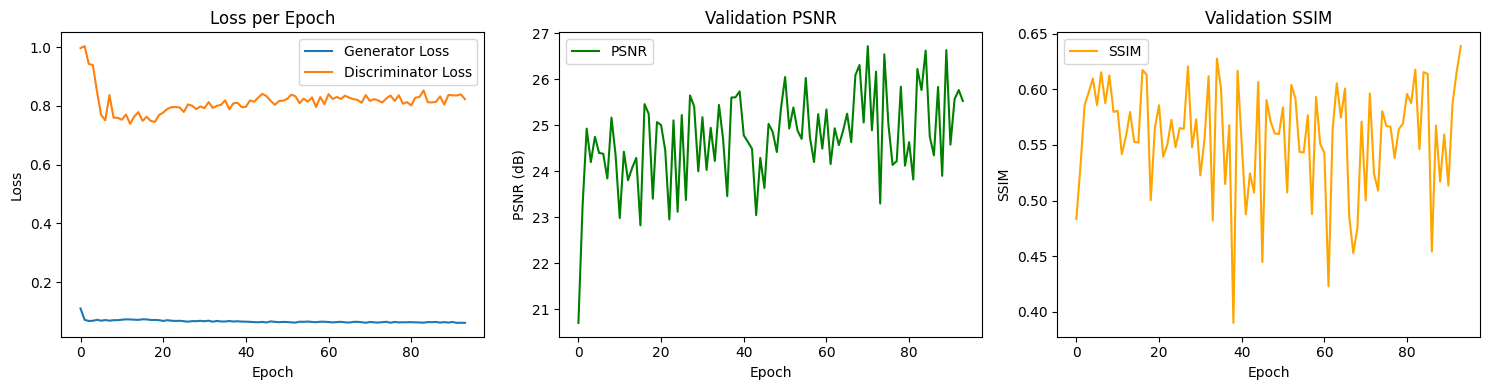

Epoch 95/100 [Validation]: 100%|██████████| 100/100 [00:19<00:00,  5.05it/s, PSNR=25.1, SSIM=0.762]



Epoch 95/100 Summary -- G Loss: 0.0626, D Loss: 0.8364, PSNR: 25.94, SSIM: 0.609


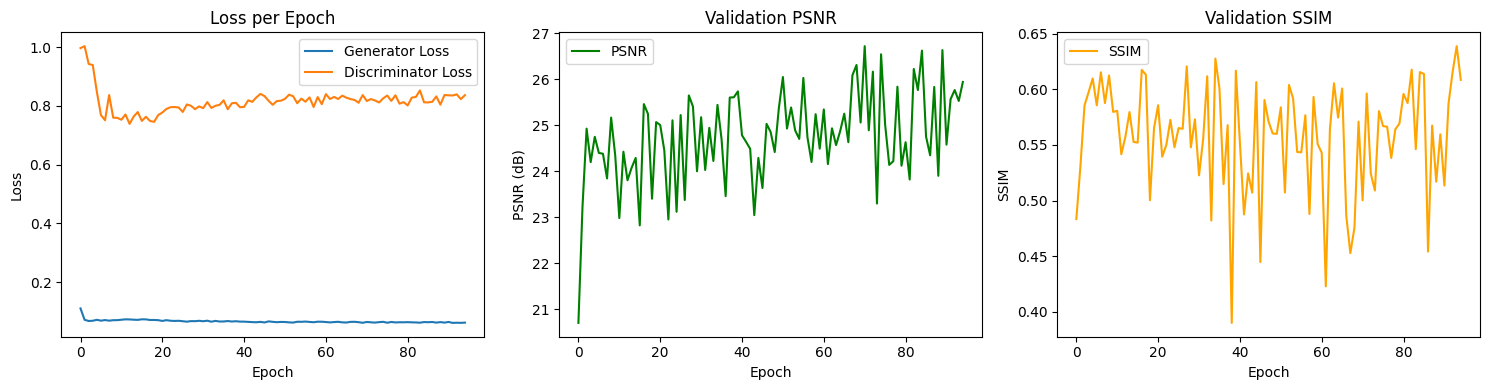

Epoch 96/100 [Validation]: 100%|██████████| 100/100 [00:19<00:00,  5.14it/s, PSNR=20, SSIM=0.625]   



Epoch 96/100 Summary -- G Loss: 0.0637, D Loss: 0.8309, PSNR: 23.72, SSIM: 0.462


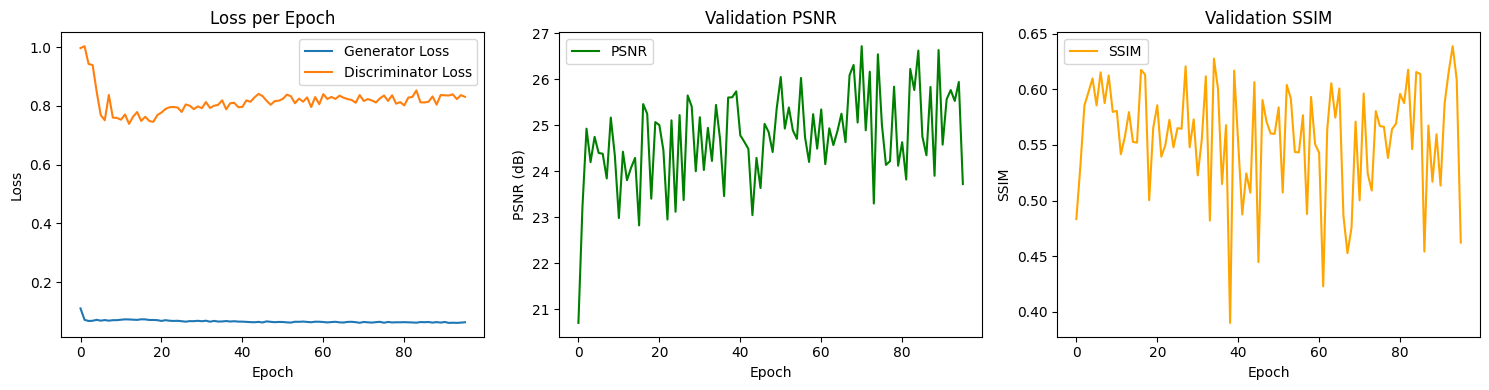

Epoch 97/100 [Validation]: 100%|██████████| 100/100 [00:19<00:00,  5.09it/s, PSNR=27.8, SSIM=0.784]



Epoch 97/100 Summary -- G Loss: 0.0613, D Loss: 0.8324, PSNR: 25.93, SSIM: 0.478


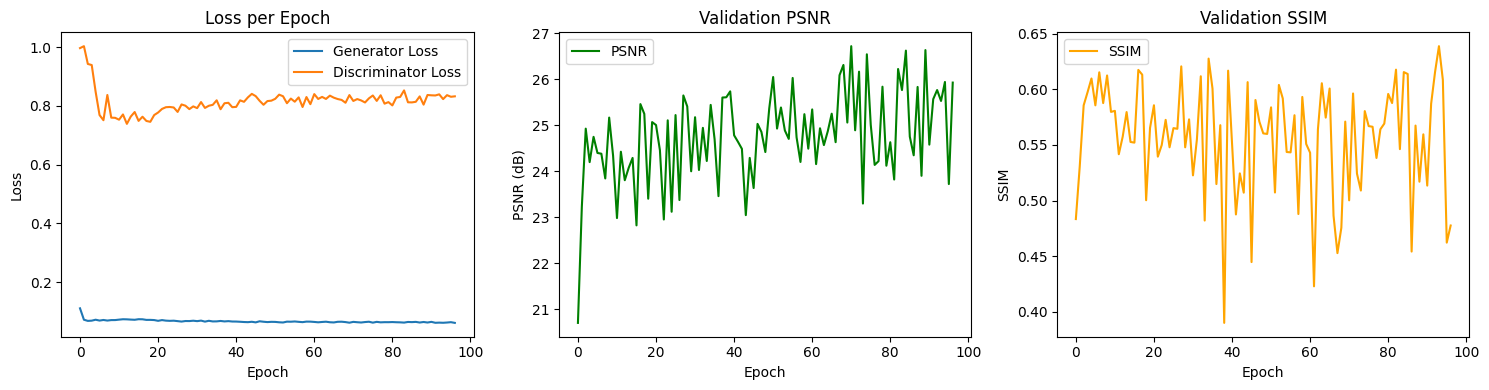

Epoch 98/100 [Validation]: 100%|██████████| 100/100 [00:19<00:00,  5.15it/s, PSNR=29.8, SSIM=0.78]   



Epoch 98/100 Summary -- G Loss: 0.0641, D Loss: 0.8194, PSNR: 25.06, SSIM: 0.421


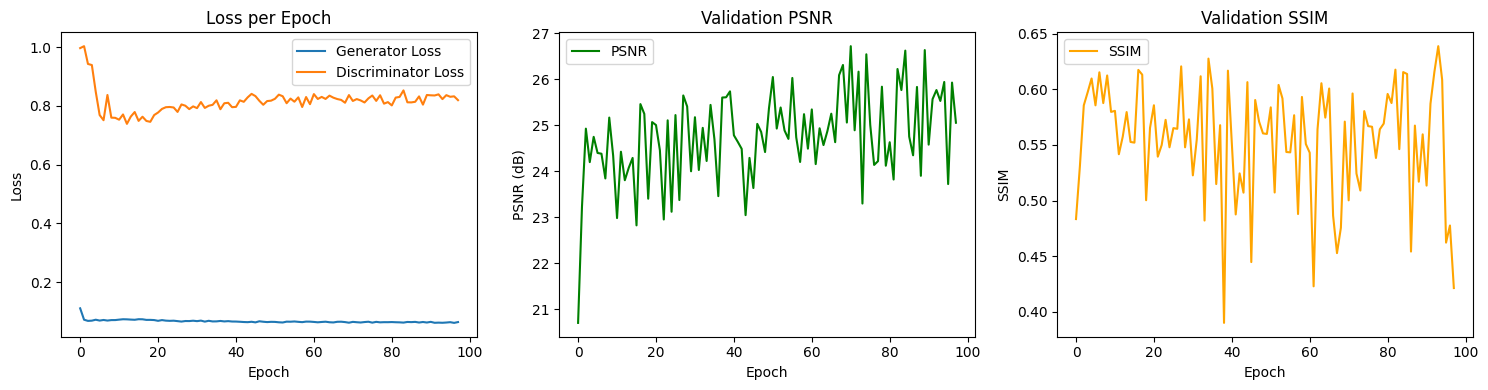

Epoch 99/100 [Validation]: 100%|██████████| 100/100 [00:19<00:00,  5.07it/s, PSNR=22.6, SSIM=0.686]



Epoch 99/100 Summary -- G Loss: 0.0636, D Loss: 0.8293, PSNR: 25.64, SSIM: 0.576


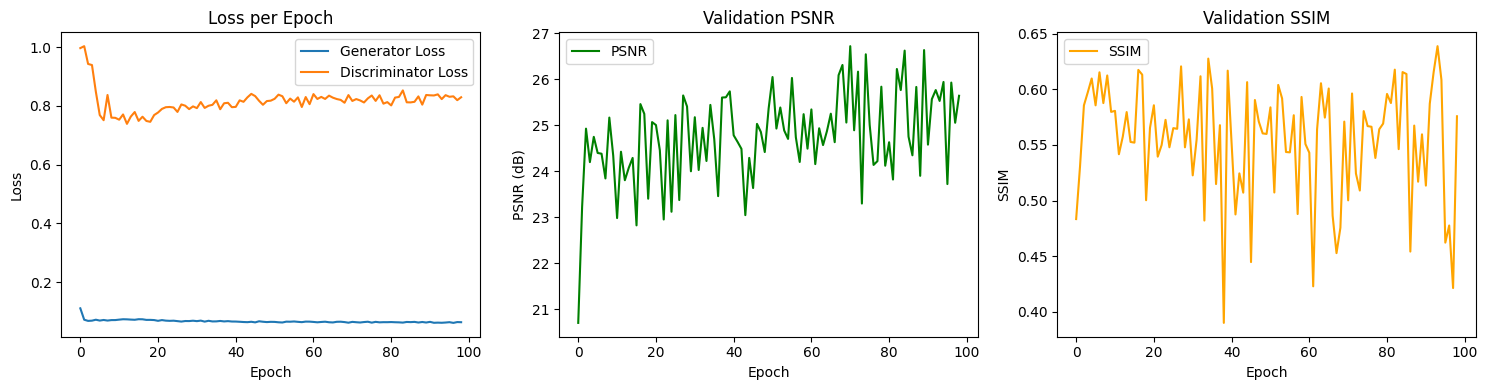

Epoch 100/100 [Validation]: 100%|██████████| 100/100 [00:20<00:00,  4.99it/s, PSNR=24.3, SSIM=0.65] 



Epoch 100/100 Summary -- G Loss: 0.0630, D Loss: 0.8051, PSNR: 24.61, SSIM: 0.572


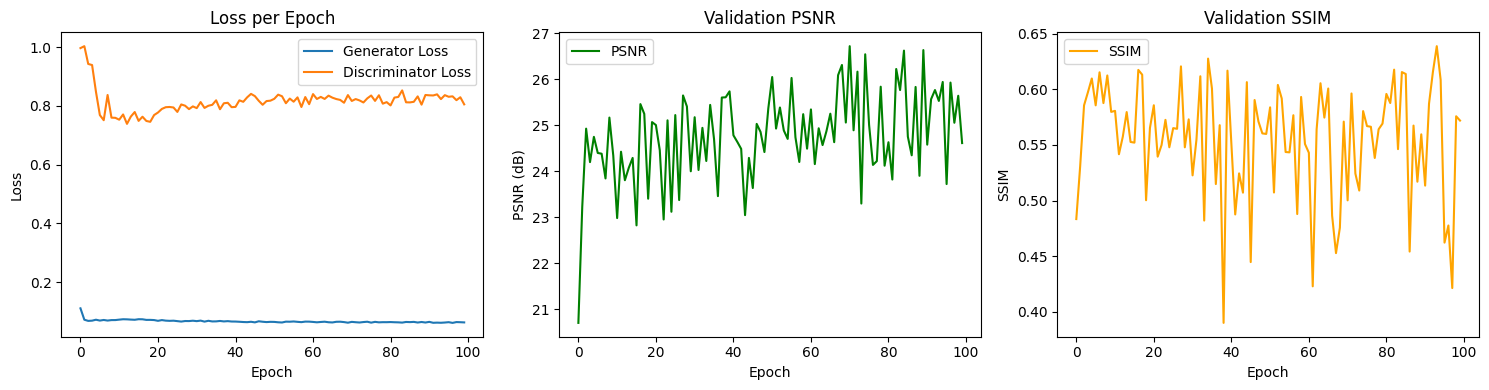

Training time: 241.83 minutes


In [37]:
import time
start = time.time()
trained_g, trained_d = train_srgan_with_plots(generator, discriminator, train_loader, val_loader, epochs, device)
end = time.time()   
# print time in minutes
print(f"Training time: {(end - start) / 60:.2f} minutes")


#### The model performance is not great the PSNR and SSIM show fluctuations which means that the learning process is not ideal. Also, the generator loss has not has not changed noticabely since the begining of the training. This could indicate that the model needs much more data and run on more epochs to catpure the patterns effectively. Additionally, the loss functions could be changed for better performance. 

In [38]:
torch.save(trained_g.state_dict(), "esrgan_generator.pth")
torch.save(trained_d.state_dict(), "esrgan_discriminator.pth")

# Inference

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator(num_blocks=23, scale_factor=4).to(device) # Adjust parameters if needed
generator.load_state_dict(torch.load("esrgan_generator.pth"))
generator.eval()

# Inference function
def super_resolve(model, lr_image, device):
    model.eval()
    with torch.no_grad():
        lr_image = lr_image.unsqueeze(0).to(device)  # Add batch dimension
        sr_image = model(lr_image)
        sr_image = torch.clamp(sr_image, 0, 1)
        sr_image = sr_image.squeeze(0).cpu()  # Remove batch dimension
    return sr_image



In [40]:
transform = transforms.ToTensor()

    # Load the full dataset (800 images assumed)
full_dataset = DIV2KDataset("./comparison_images", transform=transform, scale=2)

    # Dataloaders
val_loader = DataLoader(full_dataset, batch_size=1)

In [ ]:
import cv2
import numpy as np
import torch
from torchvision import transforms
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Generator(num_blocks=23, scale_factor=4).to(device)
model.load_state_dict(torch.load("esrgan_generator.pth"))
model.eval()

def tensor_to_cv2_img(tensor_img):
    img = tensor_img.permute(1, 2, 0).numpy()  
    img = np.clip(img * 255.0, 0, 255).astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    return img

def tensor_to_gray_numpy(tensor_img):
    img = tensor_img.permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    img_gray = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    return img_gray

# Loop through the first 4 examples
for idx, (lr_img, hr_img) in enumerate(val_loader):
    if idx >= 4:
        break

    lr_img = lr_img.squeeze(0)
    hr_img = hr_img.squeeze(0)

    with torch.no_grad():
        sr_img = model(lr_img.unsqueeze(0).to(device))
    sr_img = sr_img.squeeze(0).cpu()

    # Convert to OpenCV images
    lr_img_cv2 = tensor_to_cv2_img(lr_img)
    hr_img_cv2 = tensor_to_cv2_img(hr_img)
    sr_img_cv2 = tensor_to_cv2_img(sr_img)

    # Save the images
    cv2.imwrite(f"ESRGANlr_img_{idx+1}.png", lr_img_cv2)
    cv2.imwrite(f"ESRGANsr_img_{idx+1}.png", sr_img_cv2)
    cv2.imwrite(f"ESRGANhr_img_{idx+1}.png", hr_img_cv2)

    # Calculate metrics
    hr_gray = tensor_to_gray_numpy(hr_img)
    sr_gray = tensor_to_gray_numpy(sr_img)
    #psnr_value = psnr(hr_img_cv2, sr_img_cv2, data_range=255)
    #ssim_value = ssim(hr_gray, sr_gray, data_range=255)

    # print(f"Example {idx+1}")
    # print(f"PSNR: {psnr_value:.2f} dB")
    # print(f"SSIM: {ssim_value:.4f}")
    # print("=" * 30)

    # Show the images
    cv2.imshow(f'LR {idx+1}', lr_img_cv2)
    cv2.imshow(f'SR {idx+1}', sr_img_cv2)
    cv2.imshow(f'HR {idx+1}', hr_img_cv2)

    cv2.waitKey(0)
    cv2.destroyAllWindows()


### Images found in for_comparison_ESRGAN folder